<font color='#315aa0'>**Velarion - Data Modeling**</font>
---

## <font color='#b0aeae'>**Índice**</font>

1. **Descripción del Notebook**
2. **Configuraciones**
   * Importación de librerías
   * Paths
   * Paleta de Colores del Proyecto
   * Funciones
3. **Extracción de datos**
4. **Preparación de datos**
   * Feature Encoding
   * Train Test Split
   * Escalado Variables Numéricas
   * Balance del Dataset
5. **Modelado**
   * Baseline Model - Decision Tree Classifier
   * Logistic Regression
   * Random Forest
   * LightGBM Classifier
   * XGBoost Classifier
   * PyTorch Neural Network
   * Guardado de modelos
6. **Evaluación Best Models**
   * Métricas generales y Umbrales de decisión
   * Subajuste (Underfitting) y Sobreajuste (Overfitting)
   * Matrices de Confusión
7. **Champion Model: LightGBM Classifier**
   * Importancias
   * Análisis SHAP

# <font color='#315aa0'>**Descripción del Notebook**</font>

Para conseguir una solución robusta y eficiente al problema de abandono de la empresa Velarion, en el presente notebook se realizarán diversos experimentos referentes al modelado de datos disponibles de dicha empresa con el objetivo de construir un modelo de predicción ***(Modelo de Machine Learning)*** que permita anticipar el abandono de clientes, para que la empresa pueda tomar medidas estartégicas antes de que el evento de Churn suceda.

Además, una vez selecciónado el mejor contendiente, se explorará qué características son críticas para prever el abandono, para así contrastar las decisiones del modelo con las hipótesis planteadas en el proceso de Análisis Exploratorio de Datos *(EDA)*, lo cual permitirá desarrollar campañas de marketing y retención dirigidas y basadas en datos.

El estándar mínimo planteado será que el modelo consiga identificar correctamente 3 de cada 4 casos de abandono, que aún sean eficientes en costos y que evite la intervención excesiva de clientes que no pretenden abandonar la empresa.

# <font color='#315aa0'>**Cofiguraciones**</font>

## <font color='#c37171'>**Importación de librerías**</font>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

import warnings
import requests
import pickle

from timeit import default_timer as timer
from datetime import datetime

from pathlib import Path
from typing import Tuple, Callable, List
import os

import imblearn
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTENC, SMOTE

from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay, precision_recall_curve
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance

import xgboost
from xgboost import XGBClassifier

import lightgbm as lgb

In [2]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

RANDOM_SEED = 42

## <font color='#c37171'>**Paths**</font>

In [3]:
# Obtiene el path actual
PROJECT_PATH = os.getcwd()

src = Path('src')
DATA_PATH = PROJECT_PATH / src

img = Path('img')
GENERAL_IMG_PATH = PROJECT_PATH / img

models_img = Path('models_img')
IMG_PATH = GENERAL_IMG_PATH/ models_img

models = Path('models')
MODELS_PATH = PROJECT_PATH / models

reports = Path('reports')
REPORTS_PATH = PROJECT_PATH / reports

champion = Path('champion')
CHAMPION_PATH = PROJECT_PATH / champion

dirs = [DATA_PATH, IMG_PATH, MODELS_PATH, REPORTS_PATH, CHAMPION_PATH]


for directory in dirs:
    if not directory.exists():
        directory.mkdir(parents=True)
        print(f'Directorio creado:\n{directory}\n')
    else:
        print(f'El directorio ya existe:\n{directory}\n')

El directorio ya existe:
C:\Users\Ignacio\JupyterScripts\Fintech_NC\src

El directorio ya existe:
C:\Users\Ignacio\JupyterScripts\Fintech_NC\img\models_img

El directorio ya existe:
C:\Users\Ignacio\JupyterScripts\Fintech_NC\models

El directorio ya existe:
C:\Users\Ignacio\JupyterScripts\Fintech_NC\reports

El directorio ya existe:
C:\Users\Ignacio\JupyterScripts\Fintech_NC\champion



## <font color='#c37171'>**Paleta de Colores del Proyecto**</font>

**Bordós / Rojos**

<span style="display:inline-block; width:20px; height:20px; background:#620c0c; margin-right:5px;"></span> 
<span style="display:inline-block; width:20px; height:20px; background:#8b1f1f; margin-right:5px;"></span> 
<span style="display:inline-block; width:20px; height:20px; background:#a14b4b; margin-right:5px;"></span> 
<span style="display:inline-block; width:20px; height:20px; background:#c37171; margin-right:5px;"></span> 
<span style="display:inline-block; width:20px; height:20px; background:#e29c9c; margin-right:5px;"></span>

**Grises / Neutros**

<span style="display:inline-block; width:20px; height:20px; background:#5a5858; margin-right:5px;"></span> 
<span style="display:inline-block; width:20px; height:20px; background:#8c8a8a; margin-right:5px;"></span> 
<span style="display:inline-block; width:20px; height:20px; background:#b0aeae; margin-right:5px;"></span> 
<span style="display:inline-block; width:20px; height:20px; background:#d3d1d1; margin-right:5px;"></span> 
<span style="display:inline-block; width:20px; height:20px; background:#eae7e6; margin-right:5px;"></span>

**Azules**

<span style="display:inline-block; width:20px; height:20px; background:#0d1b3d; margin-right:5px;"></span> 
<span style="display:inline-block; width:20px; height:20px; background:#152a55; margin-right:5px;"></span> 
<span style="display:inline-block; width:20px; height:20px; background:#1e3a6c; margin-right:5px;"></span> 
<span style="display:inline-block; width:20px; height:20px; background:#274a84; margin-right:5px;"></span> 
<span style="display:inline-block; width:20px; height:20px; background:#315aa0; margin-right:5px;"></span>

**Cremas / Mostazas**

<span style="display:inline-block; width:20px; height:20px; background:#FCB53B; margin-right:5px;"></span> 
<span style="display:inline-block; width:20px; height:20px; background:#FDB860; margin-right:5px;"></span> 
<span style="display:inline-block; width:20px; height:20px; background:#FDC584; margin-right:5px;"></span> 
<span style="display:inline-block; width:20px; height:20px; background:#FDD2A9; margin-right:5px;"></span> 
<span style="display:inline-block; width:20px; height:20px; background:#FDE0CE; margin-right:5px;"></span>

In [4]:
BORDO_1, BORDO_2, BORDO_3, BORDO_4, BORDO_5 = '#620c0c', '#8b1f1f', '#a14b4b', '#c37171', '#e29c9c' 
GRIS_1, GRIS_2, GRIS_3, GRIS_4, GRIS_5 = '#5a5858', '#8c8a8a', '#b0aeae', '#d3d1d1', '#eae7e6' 
AZUL_1, AZUL_2, AZUL_3, AZUL_4, AZUL_5 = '#0d1b3d', '#152a55', '#1e3a6c', '#274a84', '#315aa0' 
CREMA_1, CREMA_2, CREMA_3, CREMA_4, CREMA_5 = '#FCB53B', '#FDB860', '#FDC584', '#FDD2A9', '#FDE0CE'

In [5]:
# Definir los colores personalizados
custom_colors = [

    '#620c0c', '#8b1f1f', '#a14b4b', '#c37171', '#e29c9c',
    '#FCB53B', '#FDB860', '#FDC584', '#FDD2A9', '#FDE0CE',
    '#315aa0', '#274a84', '#1e3a6c', '#152a55', '#0d1b3d'  
    
]

# Crear el colormap personalizado
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_colors)
reverse_custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_colors[::-1])

## <font color='#c37171'>**Funciones**</font>

In [6]:
def metricas_evaluacion(modelo, 
                       x_test: pd.core.frame.DataFrame,
                       y_test: pd.core.series.Series,
                       nombre: str,
                       umbral: float=None):
    """
    Funcion que calcula métricas de modelos clasificación
    ------------------------------------------------------------
    Parámetros:
    
        modelo:
            Modelo de Machine Learning Scikit-learn (debe contar con el método predict)
            
        x_test: pandas.core.frame.DataFrame
            DataFrame con las variables explicativas utilizadas para evaluar el modelo
            
        y_test:
            Pandas Series con las etiquetas reales de los datos utilizados para evaluar el modelo
            
        nombre: str
            Nombre que identificará el modelo para comparaciones
            
    ------------------------------------------------------------
    Returns:
        Diccionario con nombre del modelo, umbral utilizado y metricas: Accuracy, Precision, Recall, F1-score, AUC
    """
    
    if umbral == None:
        metricas = {}
        y_pred = modelo.predict(x_test)
        metricas['Model'] = nombre
        metricas['Accuracy'] = np.round(accuracy_score(y_test, y_pred), 4)
        metricas['Precision'] = np.round(precision_score(y_test, y_pred), 4)
        metricas['Recall'] = np.round(recall_score(y_test, y_pred), 4)
        metricas['F1-score'] = np.round(f1_score(y_test, y_pred), 4)
        if hasattr(modelo, "predict_proba"):
            y_proba = modelo.predict_proba(x_test)[:, 1]
            metricas['AUC'] = np.round(roc_auc_score(y_test, y_proba), 4)
        else:
            metricas['AUC'] = '---'
        metricas['Umbral'] = 0.50
    else:
        if hasattr(modelo, "predict_proba"):
            metricas = {}
            probs = modelo.predict_proba(x_test)[:, 1]
            y_pred = (probs >= umbral).astype(int)
            metricas['Model'] = nombre
            metricas['Accuracy'] = np.round(accuracy_score(y_test, y_pred), 4)
            metricas['Precision'] = np.round(precision_score(y_test, y_pred), 4)
            metricas['Recall'] = np.round(recall_score(y_test, y_pred), 4)
            metricas['F1-score'] = np.round(f1_score(y_test, y_pred), 4)
            metricas['AUC'] = np.round(roc_auc_score(y_test, probs), 4)
            metricas['Umbral'] = umbral
        else:
            raise ValueEror('El modelo no cuenta con el método "predict_proba"')
    
    return metricas

In [7]:
def cv_score_interval(results, 
                      nombre: str, 
                      score:str='Recall'):
    """
    Calcula e imprime el intervalo de confianza del 95% para una métrica de evaluación,
    a partir de los resultados de validación cruzada.

    Este análisis ayuda a entender la variabilidad del desempeño del modelo y 
    en qué rango se espera que se encuentre la métrica seleccionada (ej. recall, precisión, F1).
    ------------------------------------------------------------------------------------------
    Parámetros:
    
        results : dict o DataFrame-like
            Resultados obtenidos mediante cross_validate(), conteniendo la clave 'test_score'
            con los valores de la métrica evaluada en cada pliegue.
    
        nombre : str
            Nombre del modelo evaluado, utilizado para mostrarlo en los mensajes impresos.
    
        score : str - Default: Recall
            Nombre de la métrica evaluada (ej. 'Recall', 'F1-score'), utilizado con fines descriptivos.
    ------------------------------------------------------------------------------------------
    Returns:
    
        Imprime en pantalla el promedio, la desviación estándar y el intervalo
        de confianza del 95% para la métrica especificada.

    """
    score_mean = np.round(results['test_score'].mean(), 4)
    score_stdev = np.round(results['test_score'].std(), 4)
    lower_b = np.round(score_mean - 2 * score_stdev, 4)
    upper_b = np.round(min(1, score_mean + 2 * score_stdev), 4)
    
    print(f'Recall promedio de {nombre}: {score_mean}')
    print(f'Desviación estándar del Recall de {nombre}: {score_stdev}')
    print(f'El {score} de {nombre} estará entre [{lower_b:.4f},{upper_b:.4f}] con un 95% de confianza')

In [8]:
def plot_conf_mat(model,
                  x: pd.core.frame.DataFrame, 
                  y: pd.core.series.Series, 
                  name: str,
                  save: str,
                  save_path: Path=IMG_PATH,
                  umbral: float=None):

    """
    Función que grafíca la matriz de confusión de un modelo y guarda la figura en el Path indicado
    ----------------------------------------------------------------------------------------------
    Parámetros:
    
        model: Modelo sklearn
            Modelo de clasificación binaria que cuente con el método .predict()
            
        x: pandas.core.frame.DataFrame
            DataFrame con las variables explicativas
            
        y: pandas.core.series.Series
            Serie con el vector de etiquetas verdaderas (variable respuesta)
            
        name: str
            Nombre del modelo para el título de la figura
            
        save: str
            Nombre para guardar la figura como confmat_{nombre}.png
            
        save_path: Path
            Ruta donde debe guardarse la figura
    ---------------------------------------------------------------------------------------------
    Returns:
        Figura con matriz de confusion obtenida por el modelo seleccionado
    """
    
    if umbral == None:
        y_pred = model.predict(x)
    else:
        y_probs = model.predict_proba(x)[:, 1]
        y_pred = (y_probs >= umbral).astype(int) 
        
    confmat = confusion_matrix(y_true=y, y_pred=y_pred)

    confmat_plot = ConfusionMatrixDisplay(confmat, display_labels=['Retención', 'Evasión'])

    fig, ax = plt.subplots(figsize=(10,6))
    confmat_plot.plot(ax=ax, cmap=custom_cmap, colorbar=False, text_kw={'color': 'black', 'fontweight': 'bold'})

    plt.title(name, fontsize=18, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=16)
    plt.ylabel('True Label', fontsize=16)
    plt.tick_params(axis='both', labelsize=13)
    
    plt.subplots_adjust(right=0.88)
    plt.tight_layout(pad=3.0)
    
    fig.savefig(save_path / f'confmat_{save}.png',
                transparent=True,
                dpi=300,
                bbox_inches=None)

In [9]:
def plot_umbrales(modelo,
                  score: str,
                  x: pd.core.frame.DataFrame,
                  y: pd.core.series.Series,
                  caja_x: float,
                  caja_y: float,
                  nombre: str):
    """
    Función que genera gráfico para determinar el mejor umbral de decisión según F1-score
    ----------------------------------------------------------------------------------------------
    Parámetros:
    
        modelo: Scikit-learn model
            Para que la función trabaje correctamente debe contar con el método predict_proba
            
        score: str
            Toma solo valores: 'F1-score', 'Recall' y 'Precision'. Determina la métrica sobre la cual se quieren evaluar
            los umbrales de decisión.
            
        x: pandas.core.frames.DataFrame
            DataFrame con el conjunto de variables explicativas para realizar predicciones
            
        y: pandas.core.series.Series
            Serie con las etiquetas correspondientes a cada observación.
            
        caja_x:
            Valor para desplazar hacia la derecha la caja de texto con el valor del mejor umbral (usar valor negativo para 
            desplazar a la izquierda)
            
        caja_y:
            Valor para desplazar hacia abajo la caja de texto con el valor del mejor umbral (usar valor negativo para
            desplazar hacia arriba)
            
        nombre:
            Nombre del modelo sobre el cual se está calculando el umbral (SuperTitle)
    ----------------------------------------------------------------------------------------------
    Returns:
        Gráfico matpltolib con curva de umbrales de decisión y punto óptimo según F1-Score.
    """
    umbrales = np.linspace(0.0, 1.0, 100)
    scores = []
    if hasattr(modelo, 'predict_proba'):    
        modelo_pred_proba = modelo.predict_proba(x)[:, 1]
    else:
        raise ValueError('El modelo no cuenta con el método predict_proba')
    for t in umbrales:        
        y_pred = (modelo_pred_proba >= t).astype(int)
        scores.append(f1_score(y, y_pred))
    
    fig, ax = plt.subplots(figsize=(7,5))
    plt.suptitle(nombre, fontsize=18, fontweight='bold')
    
    plt.plot(umbrales, scores, label='F1-Score', color=AZUL_1)
    plt.title(f'{score} vs Umbral', fontsize=15)
    plt.xlabel("Umbral de decisión", fontsize=13)
    plt.ylabel(score, fontsize=13)
    
    plt.grid(True, alpha=0.3)


    idx_max = np.argmax(scores)
    mejor_umbral = umbrales[idx_max]
    mejor_valor = scores[idx_max]
    plt.scatter(mejor_umbral, mejor_valor, color=CREMA_1, zorder=5)
    plt.annotate(
        f'Umbral óptimo\nsegún F1-score: {mejor_umbral:.2f}',
        xy=(mejor_umbral, mejor_valor),
        xytext=(mejor_umbral + caja_x, mejor_valor - caja_y),
        arrowprops=dict(facecolor='black', arrowstyle='->'),
        bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.3),
        fontsize=9
    )
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
    return mejor_umbral, fig

In [10]:
def plot_precision_recall_curve(modelo,
                                x: pd.core.frame.DataFrame,
                                y: pd.core.series.Series,
                                nombre:str):
    """
    Grafica la curva Precision vs Recall para un modelo binario.

    Esta visualización permite analizar el trade-off entre la Precisión y el Recall 
    a medida que varía el umbral de decisión. Es especialmente útil en contextos de 
    clases desbalanceadas.
    --------------------------------------------------------------------------------
    Parámetros:     
        modelo: estimador de sklearn
            Modelo entrenado con un método predict_proba implementado.
            
        x: pandas.core.frame.DataFrame
            Conjunto de variables independientes para la predicción.
            
        y: pandas.core.series.Series
            Valores reales (observados) de la variable objetivo.
            
        nombre: str
            Nombre que se le dará a la curva en la leyenda del gráfico.
    --------------------------------------------------------------------------------
    Returns:
        Muestra un gráfico matplotlib con la curva Precision vs Recall.
    """
    y_pred = modelo.predict_proba(x)[:, 1]
    
    # Calcular precisión, recall y umbrales
    precision, recall, thresholds = precision_recall_curve(y, y_pred)
    
    # Graficar la curva
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', color=AZUL_1, label='Baseline Model')
    plt.title(f'{nombre}: Curva Precision-Recall', fontsize=18, fontweight='bold')
    plt.xlabel('Recall', fontsize=13)
    plt.ylabel('Precision', fontsize=13)

    plt.grid(True, alpha=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.show()

In [11]:
def plot_analisis_variables(df: pd.core.frame.DataFrame, 
                            analisis: str,
                            nombre_modelo: str, 
                            save: str,
                            n_vars: int= None,
                            save_path: Path=IMG_PATH,
                            space: float=0.5,
                            cmap=custom_cmap):
    """
    Funcion que permite visualizar Importancias o Coeficientes de modelos, guardando la figura en la ruta correspondiente.
    -----------------------------------------------------------------------------------
    Parámetros:
        df: pandas.core.frame.DataFrame
            DataFrame con las variables del modelo y sus importancias o coeficientes.
            
        analisis: str
            Acepta solo 'Importancia' o 'Coeficiente' para determinar qué analizar.
            
        nombre_modelo: str
            Nombre que aparecerá en el título del gráfico.
            
        save: str
            Nombre que se utilizará para guardar el gráfico con: "{analisis}_variables_{save}.png"
            
        n_vars: int
            Cantidad de variables que se desean analizar. Para análisis de coeficientes toma (n_vars / 2) para head y tail.
            
        save_path: Path
            Ruta para guardar el gráfico. Default IMG_PATH
    -----------------------------------------------------------------------------------
    Returns:
        Gráfico de barras horizontales con Importancia o Coeficientes de variables determinadas por modelo.
    """
    
    if analisis != 'Coeficiente' and analisis != 'Importancia':
        raise ValueError('Esta función acepta solo los valores "Importancia" o "Coeficiente" para el parámetro <analisis>') 
        
    if n_vars:
        if analisis == 'Coeficiente':
            n_vars = int(n_vars / 2)
            df1 = df.head(n_vars)
            df2 = df.tail(n_vars)
            df = pd.concat([df1, df2])
        else:
            df = df.head(n_vars)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax = sns.barplot(data=df, x=analisis, y='Feature', orient='h', hue=analisis, palette=cmap)
    plt.title(f'{analisis}s de Variables - {nombre_modelo}', fontsize=18, loc='left', fontweight='bold')
    plt.xlabel(analisis, fontsize=16)
    plt.ylabel('Feature', fontsize=16)

    
    x_max = df[analisis].max()
    x_min = df[analisis].min()
    
    for p in ax.patches:
        width = p.get_width()
        y = p.get_y() + p.get_height() / 2
        if width != 0:
            if analisis == 'Coeficiente':                
                if width > 0:
                    ax.text(
                        (width + (x_max * space)), y,
                        f'{width:.4f}',
                        ha='right', va='center',
                        fontsize=9, color='black', fontweight='bold')
                else:
                    ax.text(
                        (width - (x_max * space)), y,
                        f'{width:.4f}',
                        ha='left', va='center',
                        fontsize=9, color='black', fontweight='bold')
            else:
                ax.text(
                    (width + (x_max * space)), y,
                    f'{width*100:.2f}%',
                    ha='center', va='center',
                    fontsize=9, color='black', fontweight='bold'
                    )
        
    sns.despine()
    if analisis == 'Coeficiente':
        plt.xlim(x_min-1, x_max+1) 
    plt.tight_layout()

    fig.savefig(IMG_PATH / f'{analisis}_variables_{save}.png',
                transparent=False,
                dpi=300,
                bbox_inches='tight')
    
    plt.show()

In [12]:
def generar_tabla(df,
                 title: str,
                 save: str,
                 figsize: Tuple=(8,6),
                 path: Path=IMG_PATH):
    """
    Función que genera una tabla visual en formato imagen a partir de un DataFrame dado.
    ---------------------------------------------------------------------------------------------------------
    Parámetros:
    
        df: pandas.core.frame.DataFrame
            DataFrame con los datos que se desean visualizar en formato tabular.
            
        title: str
            Título que se mostrará en la parte superior de la tabla.
            
        save: str
            Nombre con el que se guardará la imagen de la tabla como archivo .png.
            
        figsize: Tuple
            Tamaño de la figura (ancho, alto). Default: (8, 6).
            
        path: Path
            Ruta donde se guardará la imagen. Default: IMG_PATH.
    ---------------------------------------------------------------------------------------------------------
    Returns:
        Imagen .png con la tabla renderizada y coloreada, útil para presentaciones ejecutivas o informes.
    """
    
    # Crear tabla para exportar como imagen
    fig, ax = plt.subplots(figsize=figsize)
    # Eliminar los ejes
    ax.axis('off')
    
    colors = [GRIS_3, GRIS_4]
    
    
    color_order = []
    for i in range(len(df)):
        if i % 2 == 0:
            color_order.append(colors[0])
        else:
            color_order.append(colors[1])
    max_rate = max(df, key=lambda x: x[1])
    idx_max = df[df == max_rate].index[0]
    
    cols_names = df.columns        
    cell_colors = [[color, color, color, color] for color in color_order]
    table = df.values.tolist()
    
    for row in table:
        row[1] = np.round(row[1], 4)
    tabla = ax.table(cellText=table,
                     colLabels=cols_names,
                     cellLoc='center',
                     loc='center',
                     colColours=[CREMA_1 for i in range(df.shape[0])],
                     cellColours=cell_colors)
    
    tabla.auto_set_font_size(False)
    for (row, col), cell in tabla.get_celld().items():
        cell.set_fontsize(10)
        
    plt.title(f'{title}', fontsize=18, fontweight='bold')
    
    # Escalar la tabla para mayor legibilidad
    tabla.scale(1, 2)
    
    plt.tight_layout()
    
    fig.savefig(path / f'{save}.png', transparent=True, dpi=300, bbox_inches='tight')
    
    
    plt.show()

# <font color='#315aa0'>**Extracción de Datos**</font>

In [13]:
df = pd.read_csv(DATA_PATH / 'ml_dataset.csv')

In [14]:
df.head()

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,avg_tx_amount,std_tx_amount,days_since_last_tx,tx_q1q2_rate_of_change,tx_q2q3_rate_of_change,avg_ss_duration,std_ss_duration,days_since_last_ss,ss_q1q2_rate_of_change,ss_q2q3_rate_of_change,failed_ratio_spike_q2,failed_ratio_spike_q3,failed_ratio_volatility,Exited
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,8064.092727,14262.838217,7,0.250000,0.500000,12.002691,9.650826,13,-0.111111,-0.750000,0.000000,0.000000,0.000000,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,10649.591364,23131.239254,83,-0.090909,-0.900000,16.205341,9.605109,39,0.500000,0.166667,0.166667,-0.166667,0.096225,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,18517.161693,21464.081296,1,-0.134783,0.050251,27.300036,25.513240,2,-0.088235,-0.258065,0.000000,0.000000,0.000000,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,9999.292800,17367.459946,2,0.266667,-0.157895,11.649609,16.069910,16,0.666667,-0.400000,-0.333333,0.000000,0.192450,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,11543.002979,16771.723627,9,-0.400000,-0.533333,15.913111,14.578846,1,-0.352941,0.272727,-0.176471,0.000000,0.101885,0


In [15]:
ids = df['CustomerId']

In [16]:
df.drop('CustomerId', axis=1, inplace=True)

In [17]:
df['Geography'].value_counts()

Geography
France     4595
Spain      2281
Germany    2280
Name: count, dtype: int64

# <font color='#315aa0'>**Preparación de datos**</font>

In [18]:
df.isna().sum()

CreditScore                0
Geography                  0
Gender                     0
Age                        0
Tenure                     0
Balance                    0
NumOfProducts              0
HasCrCard                  0
IsActiveMember             0
EstimatedSalary            0
avg_tx_amount              0
std_tx_amount              0
days_since_last_tx         0
tx_q1q2_rate_of_change     0
tx_q2q3_rate_of_change     0
avg_ss_duration            0
std_ss_duration            0
days_since_last_ss         0
ss_q1q2_rate_of_change     0
ss_q2q3_rate_of_change     0
failed_ratio_spike_q2      0
failed_ratio_spike_q3      0
failed_ratio_volatility    0
Exited                     0
dtype: int64

In [19]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,avg_tx_amount,std_tx_amount,days_since_last_tx,tx_q1q2_rate_of_change,tx_q2q3_rate_of_change,avg_ss_duration,std_ss_duration,days_since_last_ss,ss_q1q2_rate_of_change,ss_q2q3_rate_of_change,failed_ratio_spike_q2,failed_ratio_spike_q3,failed_ratio_volatility,Exited
count,9156.000000,9156.000000,9156.000000,9156.000000,9156.000000,9156.000000,9156.000000,9156.000000,9156.000000,9156.000000,9156.000000,9156.000000,9156.000000,9156.000000,9156.000000,9156.000000,9156.000000,9156.000000,9156.000000,9156.000000,9156.000000,9156.000000
mean,650.232525,38.839450,5.242573,76409.767313,1.534404,0.707951,0.518458,100154.742789,11026.660226,17223.578311,4.224989,-0.009247,0.079020,17.159618,14.738658,10.583443,0.125471,0.077612,-0.000156,-0.000427,0.028178,0.189493
std,96.752028,10.465329,2.756735,62630.531275,0.577964,0.454730,0.499686,57452.560494,3284.014147,4666.867790,8.007278,1.324496,1.985674,6.080393,7.688110,12.579583,0.987474,0.816131,0.062079,0.065182,0.035160,0.391921
min,350.000000,18.000000,1.000000,0.000000,1.000000,0.000000,0.000000,11.580000,1.000000,0.000000,1.000000,-0.992647,-0.972973,5.181824,0.925643,1.000000,-0.960000,-0.941176,-0.500000,-0.800000,0.000000,0.000000
25%,583.000000,32.000000,3.000000,0.000000,1.000000,0.000000,0.000000,51385.550000,9083.830828,14114.936320,1.000000,-0.245096,-0.215686,12.342080,8.767502,3.000000,-0.285714,-0.333333,0.000000,0.000000,0.000000,0.000000
50%,652.000000,37.000000,5.000000,97145.940000,1.000000,1.000000,1.000000,100350.530000,10415.459179,17028.700795,2.000000,-0.101868,-0.056824,17.131280,13.566052,6.000000,0.000000,-0.071429,0.000000,0.000000,0.020115,0.000000
75%,718.000000,44.000000,8.000000,127819.872500,2.000000,1.000000,1.000000,149216.320000,12031.276108,20145.533451,4.000000,0.069767,0.125000,20.741047,18.967819,13.000000,0.300000,0.276341,0.000000,0.000000,0.048113,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,27882.656000,42739.671790,90.000000,86.000000,92.000000,43.576516,50.096686,90.000000,39.000000,16.000000,0.952381,0.666667,0.511574,1.000000


In [20]:
y = df['Exited']
X = df.drop('Exited', axis=1)

## <font color='#c37171'>**Feature Encoding**</font>

In [21]:
categoricas = ['Geography', 'Gender']

In [22]:
one_hot = make_column_transformer(
                    (OneHotEncoder(drop='first'), categoricas),
                    remainder='passthrough',
                    sparse_threshold=0,
                    force_int_remainder_cols=False)


In [23]:
X.shape

(9156, 23)

In [24]:
X_encoded = one_hot.fit_transform(X)

In [25]:
X_encoded[0]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  6.19000000e+02,
        4.20000000e+01,  2.00000000e+00,  0.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.01348880e+05,  8.06409273e+03,
        1.42628382e+04,  7.00000000e+00,  2.50000000e-01,  5.00000000e-01,
        1.20026912e+01,  9.65082587e+00,  1.30000000e+01, -1.11111111e-01,
       -7.50000000e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [26]:
columnas = one_hot.get_feature_names_out()
columnas_encoded = []
for columna in columnas:
    columna = columna.split('__')[1]
    columnas_encoded.append(columna)

In [27]:
df_encoded = pd.DataFrame(X_encoded, 
                          columns=columnas_encoded, 
                          index=X.index)

In [28]:
df_encoded

,Geography_Germany,Geography_Spain,Gender_Male,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,avg_tx_amount,std_tx_amount,days_since_last_tx,tx_q1q2_rate_of_change,tx_q2q3_rate_of_change,avg_ss_duration,std_ss_duration,days_since_last_ss,ss_q1q2_rate_of_change,ss_q2q3_rate_of_change,failed_ratio_spike_q2,failed_ratio_spike_q3,failed_ratio_volatility
0,0.0,0.0,0.0,619.0,42.0,2.0,0.00,1.0,1.0,1.0,101348.88,8064.092727,14262.838217,7.0,0.250000,0.500000,12.002691,9.650826,13.0,-0.111111,-0.750000,0.000000,0.000000,0.000000
1,0.0,1.0,0.0,608.0,41.0,1.0,83807.86,1.0,0.0,1.0,112542.58,10649.591364,23131.239254,83.0,-0.090909,-0.900000,16.205341,9.605109,39.0,0.500000,0.166667,0.166667,-0.166667,0.096225
2,0.0,0.0,0.0,502.0,42.0,8.0,159660.80,3.0,1.0,0.0,113931.57,18517.161693,21464.081296,1.0,-0.134783,0.050251,27.300036,25.513240,2.0,-0.088235,-0.258065,0.000000,0.000000,0.000000
3,0.0,0.0,0.0,699.0,39.0,1.0,0.00,2.0,0.0,0.0,93826.63,9999.292800,17367.459946,2.0,0.266667,-0.157895,11.649609,16.069910,16.0,0.666667,-0.400000,-0.333333,0.000000,0.192450
4,0.0,1.0,0.0,850.0,43.0,2.0,125510.82,1.0,1.0,1.0,79084.10,11543.002979,16771.723627,9.0,-0.400000,-0.533333,15.913111,14.578846,1.0,-0.352941,0.272727,-0.176471,0.000000,0.101885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9151,0.0,0.0,1.0,771.0,39.0,5.0,0.00,2.0,1.0,0.0,96270.64,10565.753077,19755.870346,6.0,0.032787,0.126984,12.421880,7.785316,22.0,0.111111,0.300000,0.000000,0.000000,0.000000
9152,0.0,0.0,1.0,516.0,35.0,10.0,57369.61,1.0,1.0,1.0,101699.77,8050.113842,12569.542201,1.0,-0.225166,-0.153846,20.778687,16.712139,6.0,-0.933333,13.000000,0.000000,0.000000,0.000000
9153,0.0,0.0,0.0,709.0,36.0,7.0,0.00,1.0,0.0,1.0,42085.58,9658.935489,17896.016669,1.0,-0.256757,-0.181818,11.240852,6.345703,39.0,4.000000,-0.800000,0.000000,0.000000,0.000000
9154,1.0,0.0,1.0,772.0,42.0,3.0,75075.31,2.0,1.0,0.0,92888.52,9794.797449,19370.632437,7.0,-0.342105,0.400000,19.923180,14.549291,2.0,-0.346154,-0.647059,0.020362,-0.058824,0.029872


In [29]:
df_encoded['Exited'] = y

In [30]:
df_encoded

,Geography_Germany,Geography_Spain,Gender_Male,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,avg_tx_amount,std_tx_amount,days_since_last_tx,tx_q1q2_rate_of_change,tx_q2q3_rate_of_change,avg_ss_duration,std_ss_duration,days_since_last_ss,ss_q1q2_rate_of_change,ss_q2q3_rate_of_change,failed_ratio_spike_q2,failed_ratio_spike_q3,failed_ratio_volatility,Exited
0,0.0,0.0,0.0,619.0,42.0,2.0,0.00,1.0,1.0,1.0,101348.88,8064.092727,14262.838217,7.0,0.250000,0.500000,12.002691,9.650826,13.0,-0.111111,-0.750000,0.000000,0.000000,0.000000,1
1,0.0,1.0,0.0,608.0,41.0,1.0,83807.86,1.0,0.0,1.0,112542.58,10649.591364,23131.239254,83.0,-0.090909,-0.900000,16.205341,9.605109,39.0,0.500000,0.166667,0.166667,-0.166667,0.096225,0
2,0.0,0.0,0.0,502.0,42.0,8.0,159660.80,3.0,1.0,0.0,113931.57,18517.161693,21464.081296,1.0,-0.134783,0.050251,27.300036,25.513240,2.0,-0.088235,-0.258065,0.000000,0.000000,0.000000,1
3,0.0,0.0,0.0,699.0,39.0,1.0,0.00,2.0,0.0,0.0,93826.63,9999.292800,17367.459946,2.0,0.266667,-0.157895,11.649609,16.069910,16.0,0.666667,-0.400000,-0.333333,0.000000,0.192450,0
4,0.0,1.0,0.0,850.0,43.0,2.0,125510.82,1.0,1.0,1.0,79084.10,11543.002979,16771.723627,9.0,-0.400000,-0.533333,15.913111,14.578846,1.0,-0.352941,0.272727,-0.176471,0.000000,0.101885,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9151,0.0,0.0,1.0,771.0,39.0,5.0,0.00,2.0,1.0,0.0,96270.64,10565.753077,19755.870346,6.0,0.032787,0.126984,12.421880,7.785316,22.0,0.111111,0.300000,0.000000,0.000000,0.000000,0
9152,0.0,0.0,1.0,516.0,35.0,10.0,57369.61,1.0,1.0,1.0,101699.77,8050.113842,12569.542201,1.0,-0.225166,-0.153846,20.778687,16.712139,6.0,-0.933333,13.000000,0.000000,0.000000,0.000000,0
9153,0.0,0.0,0.0,709.0,36.0,7.0,0.00,1.0,0.0,1.0,42085.58,9658.935489,17896.016669,1.0,-0.256757,-0.181818,11.240852,6.345703,39.0,4.000000,-0.800000,0.000000,0.000000,0.000000,1
9154,1.0,0.0,1.0,772.0,42.0,3.0,75075.31,2.0,1.0,0.0,92888.52,9794.797449,19370.632437,7.0,-0.342105,0.400000,19.923180,14.549291,2.0,-0.346154,-0.647059,0.020362,-0.058824,0.029872,1


In [31]:
corr = df_encoded.corr()

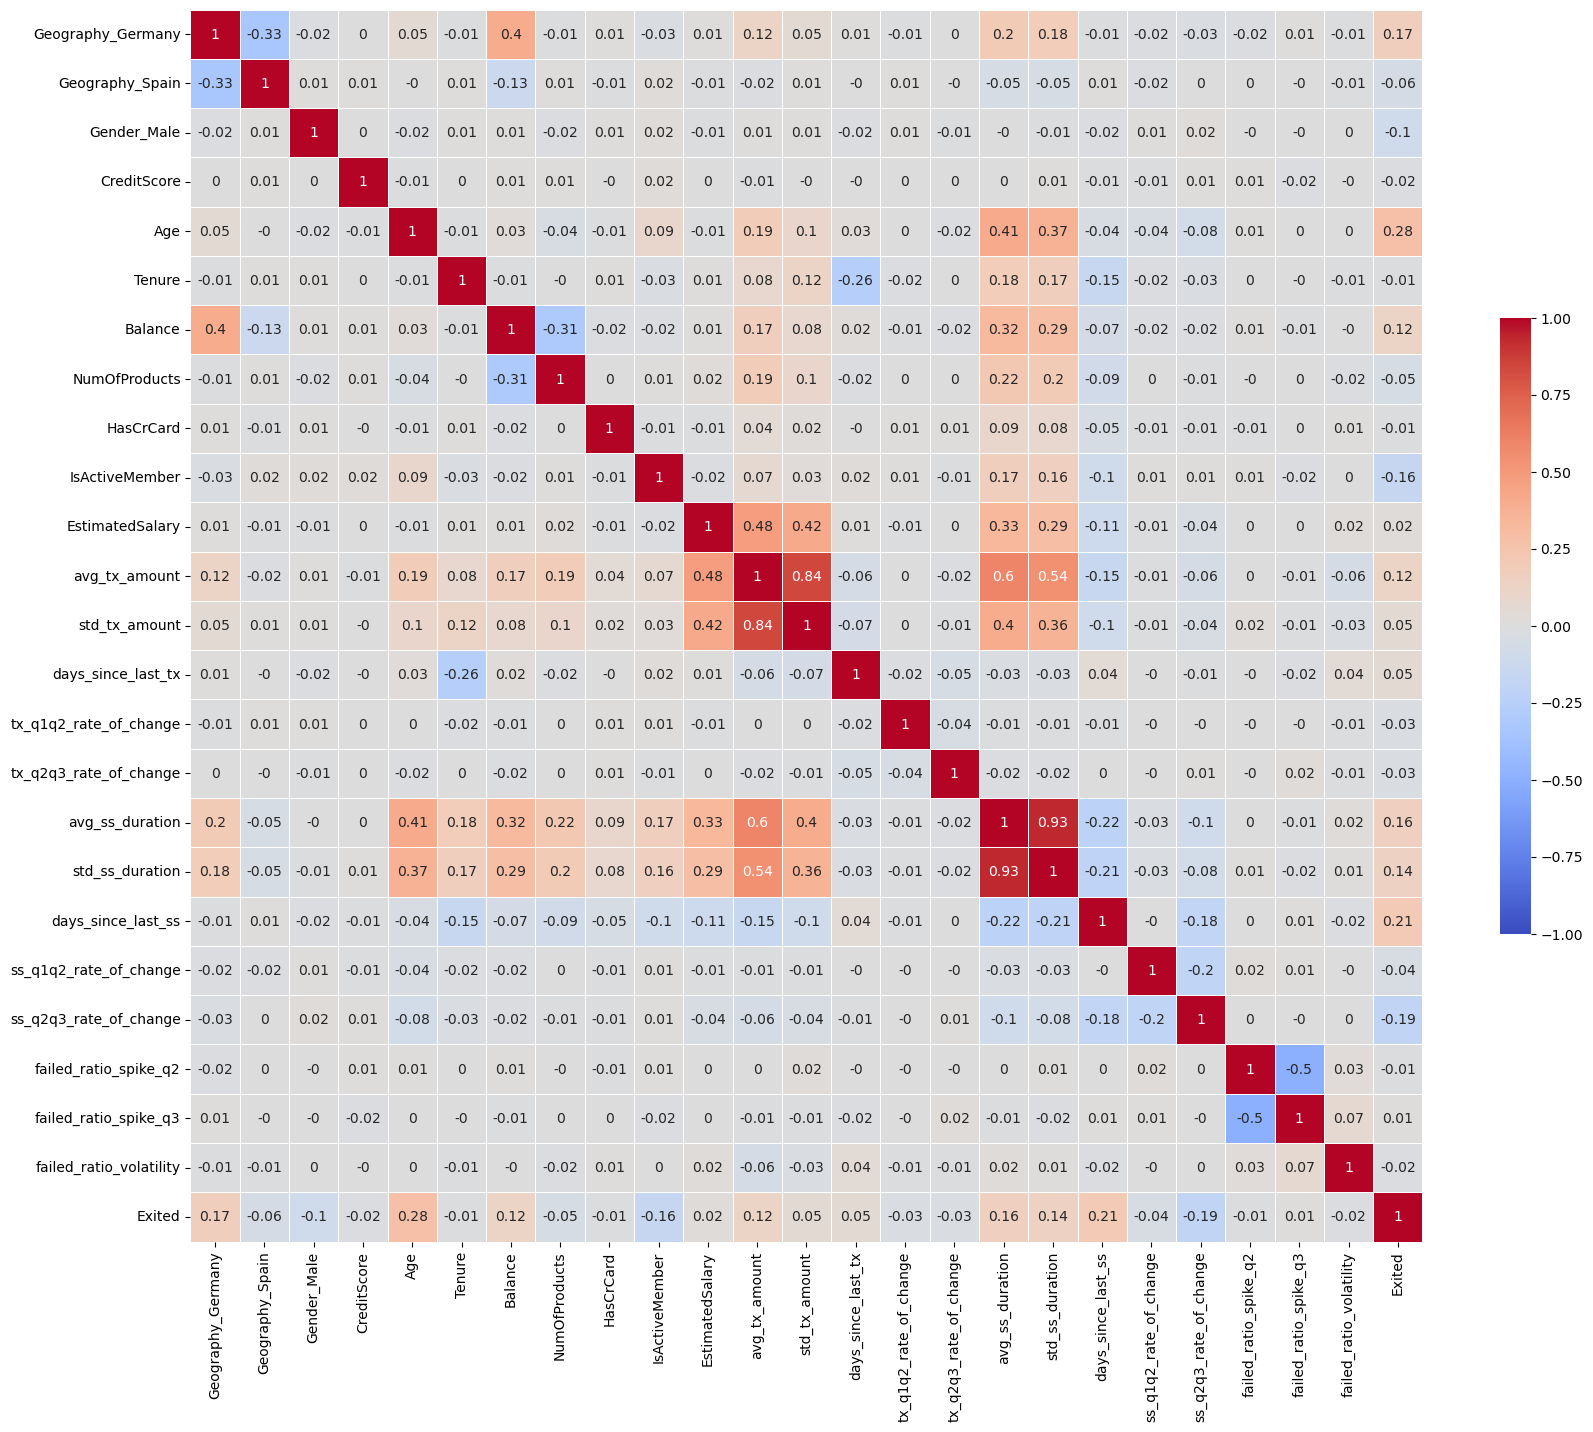

In [32]:
fig, ax = plt.subplots(figsize=(20,16))
ax = sns.heatmap(np.round(corr, 2), vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5}, cmap='coolwarm')
plt.show()

In [33]:
cols = corr.loc['Exited'].abs()[corr.loc['Exited'].abs() >= 0.04].index
corr_selected = corr[cols].loc[cols]

In [34]:
corr_selected

,Geography_Germany,Geography_Spain,Gender_Male,Age,Balance,NumOfProducts,IsActiveMember,avg_tx_amount,std_tx_amount,days_since_last_tx,avg_ss_duration,std_ss_duration,days_since_last_ss,ss_q1q2_rate_of_change,ss_q2q3_rate_of_change,Exited
Geography_Germany,1.000000,-0.331685,-0.020840,0.048777,0.399696,-0.008933,-0.029359,0.115070,0.048567,0.011293,0.199611,0.177461,-0.014843,-0.016646,-0.033302,0.173973
Geography_Spain,-0.331685,1.000000,0.013395,-0.000743,-0.134792,0.011808,0.019406,-0.018478,0.011046,-0.001205,-0.054961,-0.051212,0.006488,-0.016710,0.004038,-0.055565
Gender_Male,-0.020840,0.013395,1.000000,-0.020550,0.010288,-0.016324,0.024247,0.006568,0.005814,-0.019306,-0.003816,-0.006154,-0.016273,0.008089,0.017166,-0.102929
Age,0.048777,-0.000743,-0.020550,1.000000,0.029926,-0.035927,0.085789,0.185230,0.099301,0.029033,0.409598,0.369565,-0.041775,-0.040233,-0.081793,0.279908
Balance,0.399696,-0.134792,0.010288,0.029926,1.000000,-0.310738,-0.017528,0.166192,0.080718,0.019375,0.320472,0.290641,-0.071776,-0.019654,-0.024630,0.124301
NumOfProducts,-0.008933,0.011808,-0.016324,-0.035927,-0.310738,1.000000,0.012551,0.190756,0.102507,-0.024779,0.224772,0.201440,-0.093624,0.001444,-0.011082,-0.054100
IsActiveMember,-0.029359,0.019406,0.024247,0.085789,-0.017528,0.012551,1.000000,0.065415,0.028472,0.023887,0.170424,0.155191,-0.101250,0.010927,0.005691,-0.157580
avg_tx_amount,0.115070,-0.018478,0.006568,0.185230,0.166192,0.190756,0.065415,1.000000,0.835628,-0.055458,0.599630,0.540216,-0.146004,-0.014104,-0.061191,0.115650
std_tx_amount,0.048567,0.011046,0.005814,0.099301,0.080718,0.102507,0.028472,0.835628,1.000000,-0.072673,0.399883,0.361300,-0.101922,-0.009181,-0.041005,0.049986
days_since_last_tx,0.011293,-0.001205,-0.019306,0.029033,0.019375,-0.024779,0.023887,-0.055458,-0.072673,1.000000,-0.032117,-0.033339,0.038813,-0.002451,-0.007147,0.046524


In [35]:
# Generar una máscara para el triángulo superior
mascara = np.zeros_like(corr_selected, dtype=bool)
mascara[np.triu_indices_from(mascara)] = True

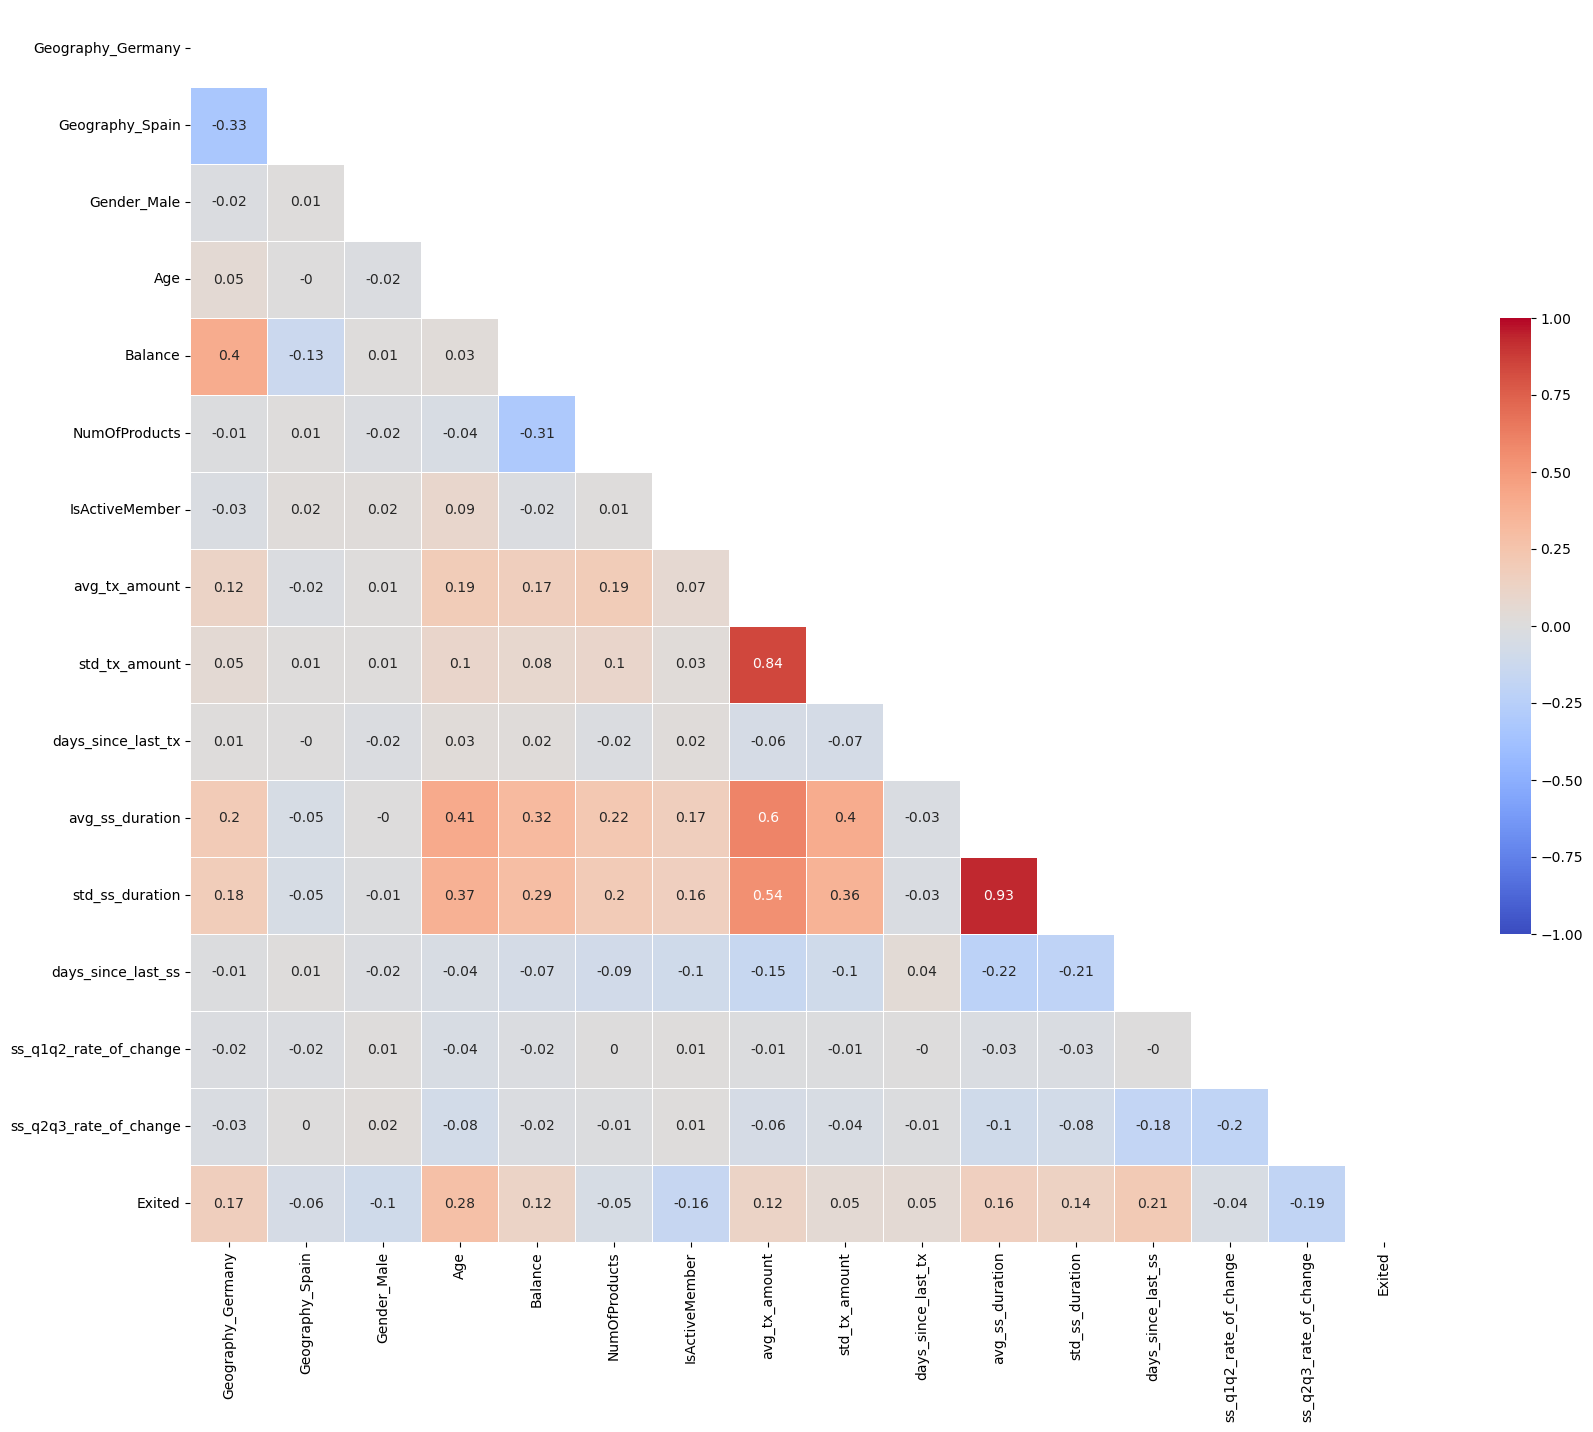

In [36]:
fig, ax = plt.subplots(figsize=(20,16))
ax = sns.heatmap(np.round(corr_selected, 2), mask=mascara, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5}, cmap='coolwarm')
fig.savefig(IMG_PATH / 'corr_matrix.png',
            transparent=False,
            dpi=300,
            bbox_inches='tight')
plt.show()

In [37]:
corr_features = corr_selected.index.to_list()

## <font color='#c37171'>**Train Test Split**</font>

In [38]:
y = df_encoded['Exited']
X = df_encoded.drop('Exited', axis=1)

In [39]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)

In [40]:
X_train.shape, X_test.shape

((7324, 24), (1832, 24))

## <font color='#c37171'>**Escalado Variables Numéricas**</font>

In [41]:
X.columns

Index(['Geography_Germany', 'Geography_Spain', 'Gender_Male', 'CreditScore',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'avg_tx_amount', 'std_tx_amount',
       'days_since_last_tx', 'tx_q1q2_rate_of_change',
       'tx_q2q3_rate_of_change', 'avg_ss_duration', 'std_ss_duration',
       'days_since_last_ss', 'ss_q1q2_rate_of_change',
       'ss_q2q3_rate_of_change', 'failed_ratio_spike_q2',
       'failed_ratio_spike_q3', 'failed_ratio_volatility'],
      dtype='object')

In [42]:
col_order = X.columns

In [43]:
numericas = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
             'EstimatedSalary', 'avg_tx_amount', 'std_tx_amount',
             'days_since_last_tx', 'tx_q1q2_rate_of_change',
             'tx_q2q3_rate_of_change', 'avg_ss_duration', 'std_ss_duration',
             'days_since_last_ss', 'ss_q1q2_rate_of_change',
             'ss_q2q3_rate_of_change', 'failed_ratio_spike_q2',
             'failed_ratio_spike_q3', 'failed_ratio_volatility']

# 2. Separar las columnas numéricas y binarias/categóricas
X_train_num = X_train[numericas]
X_test_num = X_test[numericas]

X_train_binary = X_train.drop(numericas, axis=1)
X_test_binary = X_test.drop(numericas, axis=1)

# 3. Escalar solo las columnas numéricas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_num)
X_test_scaled = scaler.transform(X_test_num)

# 4. Reconstruir los DataFrames escalados, PRESERVANDO EL ÍNDICE
X_train_cols = pd.DataFrame(X_train_scaled, columns=numericas, index=X_train_num.index)
X_test_cols = pd.DataFrame(X_test_scaled, columns=numericas, index=X_test_num.index)

# 5. Concatenar los DataFrames con los índices ahora alineados
X_train_final = pd.concat([X_train_cols, X_train_binary], axis=1)
X_test_final = pd.concat([X_test_cols, X_test_binary], axis=1)

# 6. Verificación de las formas correctas
print(X_train_final.shape, X_test_final.shape)

(7324, 24) (1832, 24)


In [44]:
with open(CHAMPION_PATH / 'scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
    
with open(CHAMPION_PATH / 'categoricas.pkl', 'wb') as f:
    pickle.dump(categoricas, f)
    
with open(CHAMPION_PATH / 'numericas.pkl', 'wb') as f:
    pickle.dump(numericas, f)

In [45]:
X_train = X_train_final[col_order].copy()
X_test = X_test_final[col_order].copy()

## <font color='#c37171'>**Balance del dataset**</font>

In [46]:
smote = SMOTE(random_state=RANDOM_SEED)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [47]:
"""
nearmiss = NearMiss(version=3)
X_train, y_train = nearmiss.fit_resample(X_train, y_train)
"""

'\nnearmiss = NearMiss(version=3)\nX_train, y_train = nearmiss.fit_resample(X_train, y_train)\n'

In [48]:
X_train.shape, y_train.shape

((11872, 24), (11872,))

In [49]:
y_train.sum()

5936

# <font color='#315aa0'>**Modelado**</font>

In [50]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

## <font color='#c37171'>**Baseline Model - Decision Tree Classifier**</font>

In [51]:
X_train.columns

Index(['Geography_Germany', 'Geography_Spain', 'Gender_Male', 'CreditScore',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'avg_tx_amount', 'std_tx_amount',
       'days_since_last_tx', 'tx_q1q2_rate_of_change',
       'tx_q2q3_rate_of_change', 'avg_ss_duration', 'std_ss_duration',
       'days_since_last_ss', 'ss_q1q2_rate_of_change',
       'ss_q2q3_rate_of_change', 'failed_ratio_spike_q2',
       'failed_ratio_spike_q3', 'failed_ratio_volatility'],
      dtype='object')

In [52]:
col_order = X_train.columns

with open(CHAMPION_PATH / 'col_order.pkl', 'wb') as f:
    pickle.dump(col_order, f)

In [53]:
best_models = []

In [54]:
baseline_model = DecisionTreeClassifier(max_depth=10, random_state=RANDOM_SEED)
baseline_cross_val_results = cross_validate(baseline_model, X_train, y_train, cv=skf, scoring='recall')

In [55]:
cv_score_interval(results=baseline_cross_val_results, 
                  nombre='Baseline Model',
                  score='Recall')

Recall promedio de Baseline Model: 0.8711
Desviación estándar del Recall de Baseline Model: 0.013
El Recall de Baseline Model estará entre [0.8451,0.8971] con un 95% de confianza


In [56]:
baseline_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [57]:
baseline_train_results = metricas_evaluacion(baseline_model,
                                        X_train,
                                        y_train,
                                        nombre='Baseline Model')
baseline_train_results

{'Model': 'Baseline Model',
 'Accuracy': 0.9378,
 'Precision': 0.9381,
 'Recall': 0.9375,
 'F1-score': 0.9378,
 'AUC': 0.9819,
 'Umbral': 0.5}

In [58]:
baseline_results = metricas_evaluacion(baseline_model,
                                        X_test,
                                        y_test,
                                        nombre='Baseline Model')

In [59]:
baseline_results

{'Model': 'Baseline Model',
 'Accuracy': 0.8226,
 'Precision': 0.5261,
 'Recall': 0.6398,
 'F1-score': 0.5774,
 'AUC': 0.7758,
 'Umbral': 0.5}

In [60]:
baseline_pred = baseline_model.predict(X_test)

In [61]:
print(classification_report(y_test, baseline_pred))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89      1485
           1       0.53      0.64      0.58       347

    accuracy                           0.82      1832
   macro avg       0.72      0.75      0.73      1832
weighted avg       0.84      0.82      0.83      1832



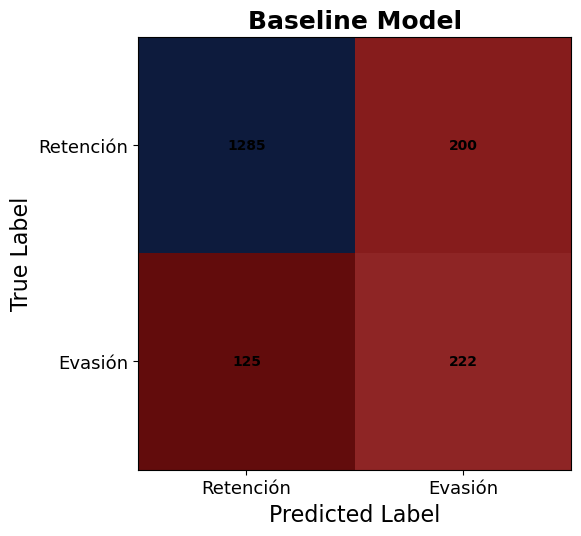

In [62]:
plot_conf_mat(baseline_model, X_test, y_test, 'Baseline Model', 'baseline')

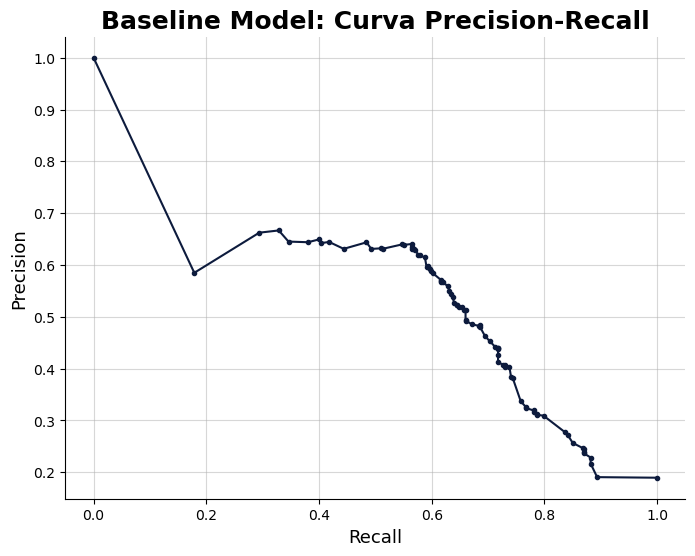

In [63]:
plot_precision_recall_curve(modelo=baseline_model,
                            x=X_test,
                            y=y_test,
                            nombre='Baseline Model')

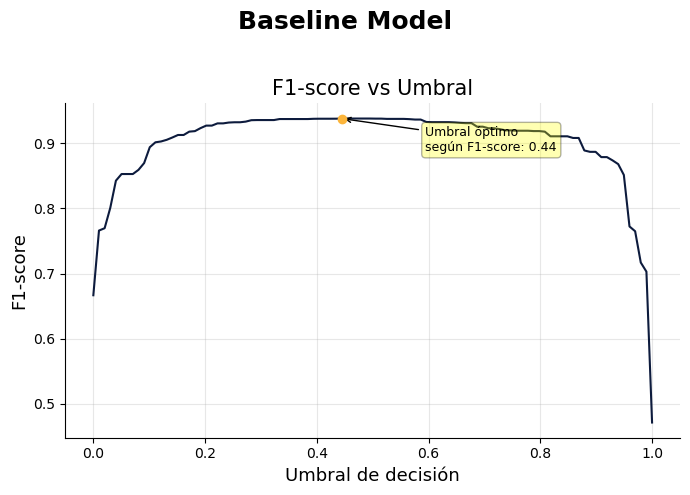

In [64]:
umbral_baseline, plot_umbral_baseline = plot_umbrales(modelo=baseline_model,
                                                      score='F1-score',
                                                      x=X_train,
                                                      y=y_train,
                                                      caja_x=0.15,
                                                      caja_y=0.05,
                                                      nombre='Baseline Model')

In [65]:
baseline_results_umbral = metricas_evaluacion(modelo=baseline_model,
                                              x_test=X_test,
                                              y_test=y_test,
                                              nombre='Baseline Model',
                                              umbral=umbral_baseline)
baseline_results_umbral

{'Model': 'Baseline Model',
 'Accuracy': 0.8215,
 'Precision': 0.5234,
 'Recall': 0.6455,
 'F1-score': 0.5781,
 'AUC': 0.7758,
 'Umbral': 0.4444444444444445}

In [66]:
baseline_importances = baseline_model.feature_importances_

In [67]:
df_baseline_importances = pd.DataFrame({'Feature': X_train.columns, 'Importancia': baseline_importances})
df_baseline_importances = df_baseline_importances.sort_values(by='Importancia', ascending=False)

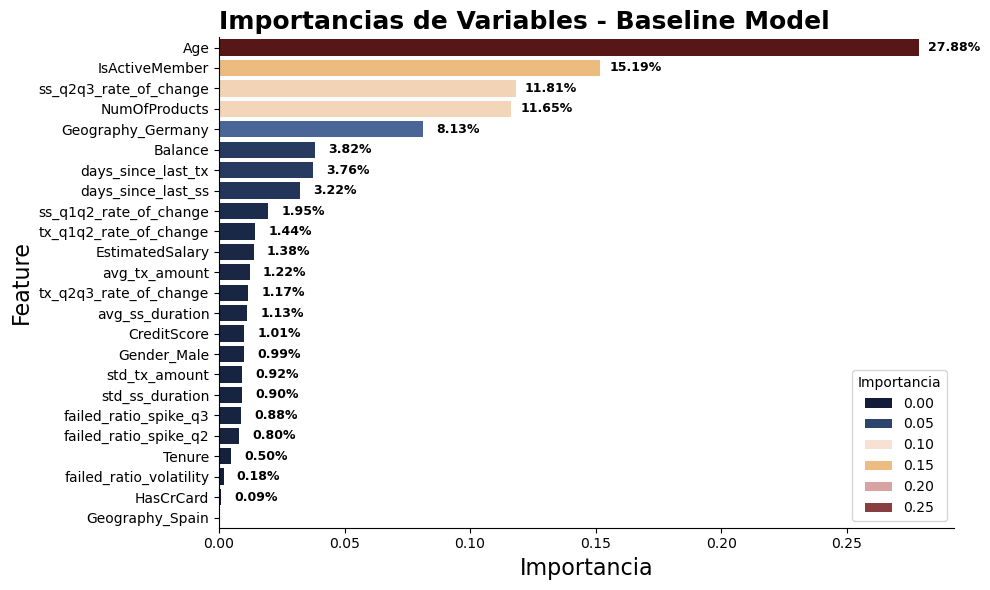

In [68]:
plot_analisis_variables(df=df_baseline_importances,
                        analisis='Importancia',
                        nombre_modelo='Baseline Model',
                        save='baseline_importances',
                        space=0.05,
                        cmap=reverse_custom_cmap)

### <font color='FCB53B'>**Importancias Baseline Model**</font>

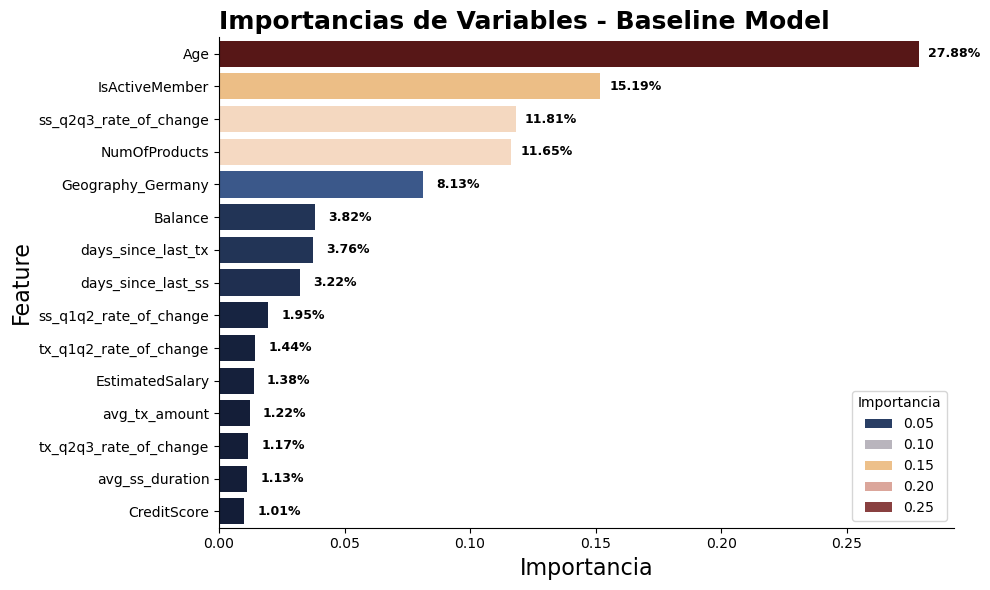

In [69]:
plot_analisis_variables(df=df_baseline_importances,
                        analisis='Importancia',
                        nombre_modelo='Baseline Model',
                        save='baseline_importances',
                        n_vars=15,
                        space=0.05,
                        cmap=reverse_custom_cmap)

In [70]:
df_baseline_importances.head(15)['Importancia'].sum()

0.9474959391850863

In [71]:
df_baseline_importances.head(15)

,Feature,Importancia
4,Age,0.278763
9,IsActiveMember,0.151911
20,ss_q2q3_rate_of_change,0.118148
7,NumOfProducts,0.116459
0,Geography_Germany,0.081283
6,Balance,0.038170
13,days_since_last_tx,0.037552
18,days_since_last_ss,0.032171
19,ss_q1q2_rate_of_change,0.019534
14,tx_q1q2_rate_of_change,0.014354


In [72]:
best_models.append(baseline_results_umbral)
pd.DataFrame(best_models)

,Model,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,Baseline Model,0.8215,0.5234,0.6455,0.5781,0.7758,0.444444


In [73]:
pd.DataFrame([baseline_train_results])

,Model,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,Baseline Model,0.9378,0.9381,0.9375,0.9378,0.9819,0.5


## <font color='#8b1f1f'>**Conclusiones: Baseline Model - Decision Tree Classifier**</font>

| Model	          | Conjunto   | Accuracy   | Precision	| Recall	| F1-score	| AUC	  | Umbral   |
|-----------------|------------|------------|-----------|-----------|-----------|---------|----------|
| Baseline Model  | Train      | 0.9292	    | 0.928	    | 0.9306	| 0.9293	| 0.9797  | 0.5      |
| Baseline Model  | Test       | 0.8019	    | 0.4797	| 0.6522	| 0.5528	| 0.7849  | 0.454545 |

El modelo tomado como base (`Decision Tree Classifier`) muestra un elevado sobreajuste a los datos de entrenamiento. Esto era esperable ya que no se realizó ningún ajuste de hiperparámetros.

Sin embargo, como modelo base la capacidad de separar las clases es bastante buena, con un **score AUC = 0.7849** en los datos de prueba. Esto indica que existe poder predictivo en el presente dataset. Por lo que se realizarán diversos experimentos con el objetivo de encontrar el modelo que mejor comprenda el patrón presente en los datos.

## <font color='#c37171'>**Logistic Regression**</font>

In [74]:
lr_results_tracking = []

### <font color='#FCB53B'>**Logistic Regression 1  - max_iter=100**</font>

In [75]:
lr_1 = LogisticRegression(max_iter=100, random_state=RANDOM_SEED)

In [76]:
lr_1.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [77]:
lr_1_train = metricas_evaluacion(lr_1,
                                X_train,
                                y_train,
                                nombre='Train LogisticRegression 1')

lr_1_train

{'Model': 'Train LogisticRegression 1',
 'Accuracy': 0.7877,
 'Precision': 0.7846,
 'Recall': 0.7933,
 'F1-score': 0.7889,
 'AUC': 0.8664,
 'Umbral': 0.5}

In [78]:
lr_results_tracking.append(lr_1_train)

In [79]:
lr_1_results = metricas_evaluacion(lr_1,
                                    X_test,
                                    y_test,
                                    nombre='LogisticRegression 1')

In [80]:
lr_1_results

{'Model': 'LogisticRegression 1',
 'Accuracy': 0.7587,
 'Precision': 0.423,
 'Recall': 0.7522,
 'F1-score': 0.5415,
 'AUC': 0.8267,
 'Umbral': 0.5}

In [81]:
lr_results_tracking.append(lr_1_results)

In [82]:
lr_1_coef = lr_1.coef_

In [83]:
df_lr_1_coef = pd.DataFrame({'Feature': X_train.columns, 'Coeficiente': lr_1_coef[0]})
df_lr_1_coef = df_lr_1_coef.sort_values(by='Coeficiente', ascending=False)
df_lr_1_coef

,Feature,Coeficiente
4,Age,0.846006
0,Geography_Germany,0.798496
18,days_since_last_ss,0.449795
11,avg_tx_amount,0.427619
16,avg_ss_duration,0.351660
6,Balance,0.124362
13,days_since_last_tx,0.050914
22,failed_ratio_spike_q3,0.003954
21,failed_ratio_spike_q2,-0.005016
5,Tenure,-0.006832


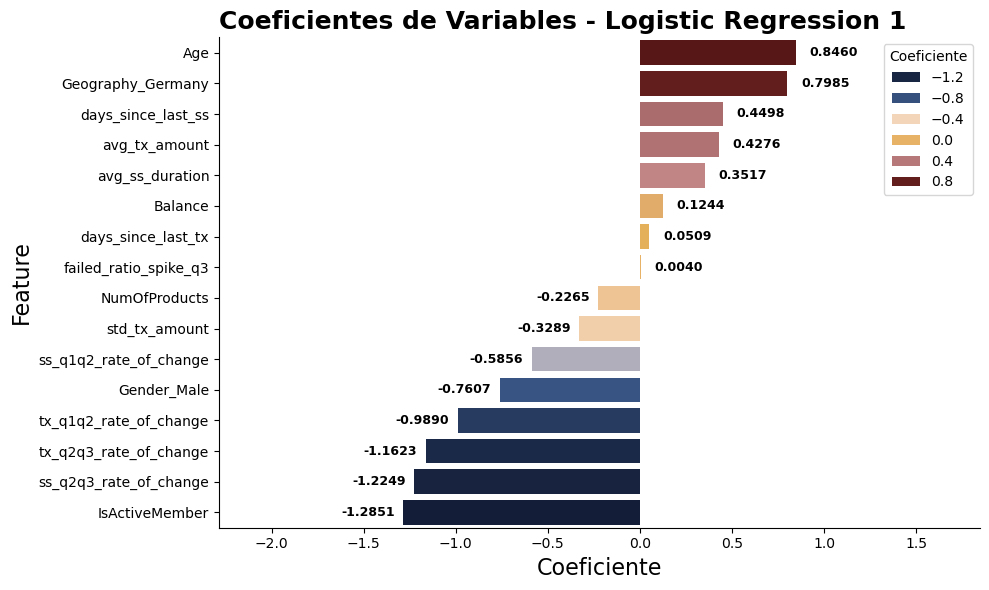

In [84]:
plot_analisis_variables(df=df_lr_1_coef,
                        analisis='Coeficiente',
                        nombre_modelo='Logistic Regression 1',
                        save='lr_1',
                        n_vars=16,
                        space=0.4,
                        cmap=reverse_custom_cmap)

In [85]:
pd.DataFrame(lr_results_tracking)

,Model,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,Train LogisticRegression 1,0.7877,0.7846,0.7933,0.7889,0.8664,0.5
1,LogisticRegression 1,0.7587,0.4230,0.7522,0.5415,0.8267,0.5


In [86]:
pd.DataFrame([baseline_train_results, baseline_results_umbral])

,Model,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,Baseline Model,0.9378,0.9381,0.9375,0.9378,0.9819,0.500000
1,Baseline Model,0.8215,0.5234,0.6455,0.5781,0.7758,0.444444


### <font color='#FDD2A9'>**Observaciones: Logistic Regression 1**</font>

El modelo de **Regresión Logística** presenta mejoras en la métrica prioritaria **Recall** en relación al `Baseline Model (Decision Tree Classifier)`.

Además, muestra un sobreajuste mucho menor en relación a este último.
Métricas como **AUC** y **Recall** caen ambas aproximadamente solo un 4%, mientras que **Precision** y por ende **F1-score** sufren una caída significativa en ambos modelos. Una de las razones para este fenómeno es el gran desbalanceo que existe entre ambas clases en el conjunto de evaluación, que respeta la distribución original de los datos.

Dado que `LogisticRegression 1`, sin ningún ajuste de hiperparámetros logró superar al modelo base, se realizarán experimentos con el objetivo de hallar el representante de esta familia de algoritmos.

### <font color='#FCB53B'>**Logistic Regression - Feature Selection**</font>

In [87]:
lr_1_coef = pd.DataFrame({'Feature': X_train.columns.values, 'Coeficiente': np.abs(lr_1.coef_[0])}).sort_values('Coeficiente', ascending=False)
len(lr_1_coef)

24

In [88]:
feature_selection = []

ct_features = [i if i != 0 else 1 for i in range(0, len(lr_1_coef) + 1, 3)]

for i in ct_features:
    model_features = LogisticRegression(random_state=RANDOM_SEED)
    selected_features = lr_1_coef['Feature'].values[:i]
    X_train_sel = X_train[selected_features]
    X_test_sel = X_test[selected_features]
    model_features.fit(X_train_sel, y_train)
    metricas = metricas_evaluacion(model_features, X_test_sel, y_test, f'Features: {i}')
    feature_selection.append(metricas)

pd.DataFrame(feature_selection)

,Model,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,Features: 1,0.5557,0.2379,0.6110,0.3425,0.5769,0.5
1,Features: 3,0.6588,0.3161,0.6888,0.4334,0.7234,0.5
2,Features: 6,0.7271,0.3821,0.7147,0.4980,0.7985,0.5
3,Features: 9,0.7544,0.4143,0.7176,0.5253,0.8155,0.5
4,Features: 12,0.7680,0.4348,0.7493,0.5503,0.8235,0.5
5,Features: 15,0.7631,0.4281,0.7464,0.5441,0.8257,0.5
6,Features: 18,0.7576,0.4214,0.7493,0.5394,0.8260,0.5
7,Features: 21,0.7587,0.4230,0.7522,0.5415,0.8268,0.5
8,Features: 24,0.7587,0.4230,0.7522,0.5415,0.8267,0.5


### <font color='#FDD2A9'>**Observaciones: Logistic Regression - Feature Selection**</font>

Es posible observar que el modelo no se beneficia de menor cantidad de features en este caso. Las mejores métricas se consiguen utilizando todas las variables, por lo que se realizarán otro tipo de experimentos relacionados al ajuste de hiperparámetros.

### <font color='#FCB53B'>**Logistic Regression 2 - Penalty L1 (Lasso)**</font>

In [89]:
lr_2 = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, random_state=RANDOM_SEED)

In [90]:
lr_2.fit(X_train, y_train)

LogisticRegression(penalty='l1', random_state=42, solver='liblinear')

In [91]:
lr_2_train = metricas_evaluacion(lr_2,
                                X_train,
                                y_train,
                                nombre='Train LogisticRegression 2')
lr_2_train

{'Model': 'Train LogisticRegression 2',
 'Accuracy': 0.7881,
 'Precision': 0.7851,
 'Recall': 0.7933,
 'F1-score': 0.7892,
 'AUC': 0.8664,
 'Umbral': 0.5}

In [92]:
lr_results_tracking.append(lr_2_train)

In [93]:
lr_2_results = metricas_evaluacion(lr_2,
                                    X_test,
                                    y_test,
                                    nombre='LogisticRegression 2')
lr_2_results

{'Model': 'LogisticRegression 2',
 'Accuracy': 0.7582,
 'Precision': 0.4221,
 'Recall': 0.7493,
 'F1-score': 0.54,
 'AUC': 0.8268,
 'Umbral': 0.5}

In [94]:
lr_results_tracking.append(lr_2_results)

In [95]:
lr_2_coef = lr_2.coef_
df_lr_2_coef = pd.DataFrame({'Feature': X_train.columns, 'Coeficiente': lr_2_coef[0]})
df_lr_2_coef = df_lr_2_coef.sort_values(by='Coeficiente', ascending=False)
df_lr_2_coef

,Feature,Coeficiente
4,Age,0.846656
0,Geography_Germany,0.800863
18,days_since_last_ss,0.449397
11,avg_tx_amount,0.425522
16,avg_ss_duration,0.343770
6,Balance,0.124367
13,days_since_last_tx,0.050190
22,failed_ratio_spike_q3,0.003522
21,failed_ratio_spike_q2,-0.004687
5,Tenure,-0.006316


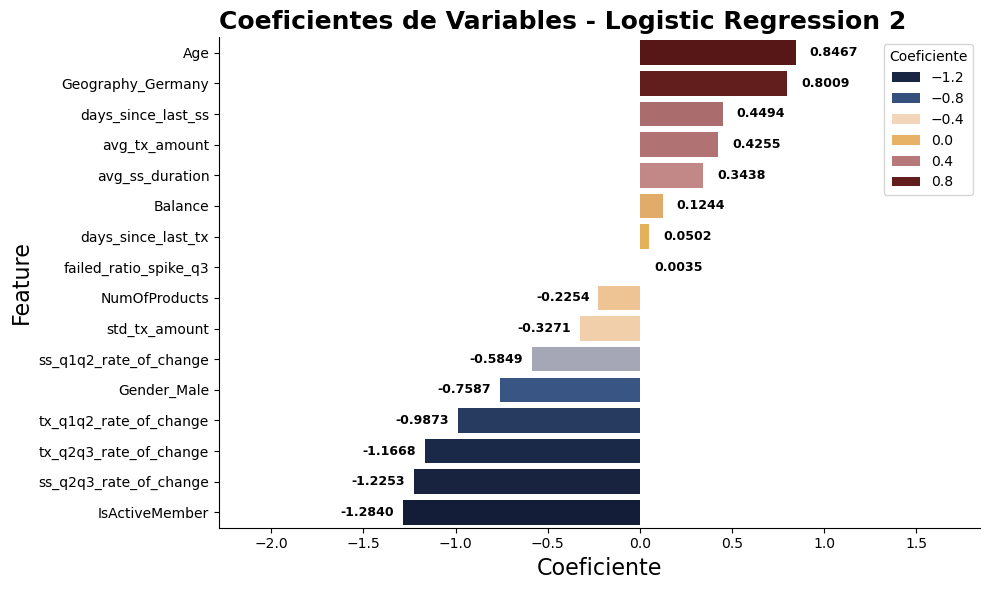

In [96]:
plot_analisis_variables(df=df_lr_2_coef,
                        analisis='Coeficiente',
                        nombre_modelo='Logistic Regression 2',
                        save='lr_2',
                        n_vars=16,
                        space=0.4,
                        cmap=reverse_custom_cmap)

In [97]:
pd.DataFrame(lr_results_tracking)

,Model,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,Train LogisticRegression 1,0.7877,0.7846,0.7933,0.7889,0.8664,0.5
1,LogisticRegression 1,0.7587,0.4230,0.7522,0.5415,0.8267,0.5
2,Train LogisticRegression 2,0.7881,0.7851,0.7933,0.7892,0.8664,0.5
3,LogisticRegression 2,0.7582,0.4221,0.7493,0.5400,0.8268,0.5


### <font color='#FDD2A9'>**Observaciones: Logistic Regression 2 - Penalty L1 (Lasso)**</font>

Los resultados de ambas **Regresiones Logísticas** son muy similares a pesar de utilizar una regularización distinta.

Si bien se observó anteriormente que la redeucción de features no beneficiaba al modelo, es posible que la combinación de iteraciones máximas **(max_iter)** y el factor de regularización **(C)** no hayan sido los adecuados para obtener los mejores resultados posibles, por lo que se llevará a cabo un GridSearch con L1 y L2 para ver si es posible mejorar las métricas de este algoritmo.

### <font color='#FCB53B'>**Logistic Regression 3 - GridSearch - L2**</font> 

In [98]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs'],            
    'max_iter': [100, 200, 500]
}

lr_3 = GridSearchCV(LogisticRegression(random_state=RANDOM_SEED),
                    param_grid=param_grid, 
                    scoring='recall',
                    cv=skf)

lr_3.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [100, 200, 500], 'solver': ['lbfgs']},
             scoring='recall')

In [99]:
lr_3_train = metricas_evaluacion(lr_3,
                                X_train,
                                y_train,
                                nombre='Train LogisticRegression 3')
lr_3_train

{'Model': 'Train LogisticRegression 3',
 'Accuracy': 0.7886,
 'Precision': 0.7856,
 'Recall': 0.7938,
 'F1-score': 0.7897,
 'AUC': 0.8663,
 'Umbral': 0.5}

In [100]:
lr_results_tracking.append(lr_3_train)

In [101]:
lr_3_results = metricas_evaluacion(lr_3,
                                X_test,
                                y_test,
                                nombre='LogisticRegression 3')
lr_3_results

{'Model': 'LogisticRegression 3',
 'Accuracy': 0.7587,
 'Precision': 0.4235,
 'Recall': 0.7579,
 'F1-score': 0.5434,
 'AUC': 0.8268,
 'Umbral': 0.5}

In [102]:
lr_results_tracking.append(lr_3_results)

In [103]:
pd.DataFrame(lr_results_tracking)

,Model,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,Train LogisticRegression 1,0.7877,0.7846,0.7933,0.7889,0.8664,0.5
1,LogisticRegression 1,0.7587,0.4230,0.7522,0.5415,0.8267,0.5
2,Train LogisticRegression 2,0.7881,0.7851,0.7933,0.7892,0.8664,0.5
3,LogisticRegression 2,0.7582,0.4221,0.7493,0.5400,0.8268,0.5
4,Train LogisticRegression 3,0.7886,0.7856,0.7938,0.7897,0.8663,0.5
5,LogisticRegression 3,0.7587,0.4235,0.7579,0.5434,0.8268,0.5


### <font color='#FDD2A9'>**Observaciones: Logistic Regression 3 - GridSearch - L2**</font>

Como se puede obsevar, la variación en las métricas es casi impercetible, por lo que se abandonará el siguiente expermiento para investigar otras familias de algoritmos que puedan presnetar una mayor variación.

Por el momento se conservará `LogisticRegression 3` como representante de la familia

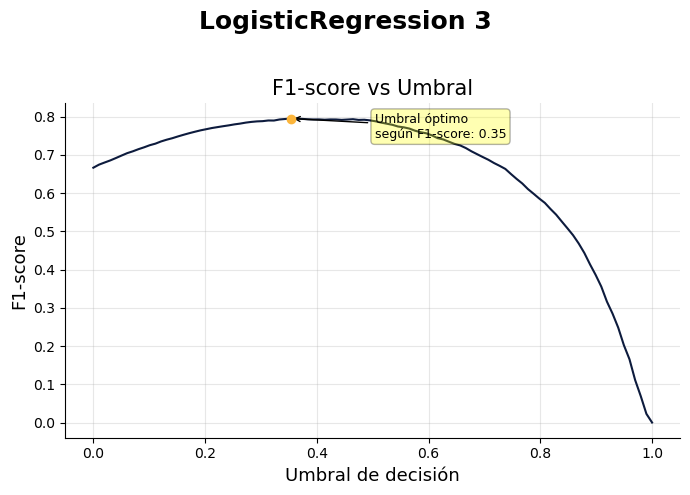

In [104]:
umbral_lr_3, plot_umbral_lr_3 = plot_umbrales(modelo=lr_3,
                                                      score='F1-score',
                                                      x=X_train,
                                                      y=y_train,
                                                      caja_x=0.15,
                                                      caja_y=0.05,
                                                      nombre='LogisticRegression 3')

In [105]:
lr_3_results_umbral = metricas_evaluacion(lr_3,
                                X_test,
                                y_test,
                                nombre='LogisticRegression 3',
                                umbral=umbral_lr_3)
lr_3_results_umbral

{'Model': 'LogisticRegression 3',
 'Accuracy': 0.6736,
 'Precision': 0.3515,
 'Recall': 0.8559,
 'F1-score': 0.4983,
 'AUC': 0.8268,
 'Umbral': 0.3535353535353536}

In [106]:
best_models.append(lr_3_results)

In [107]:
pd.DataFrame(best_models)

,Model,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,Baseline Model,0.8215,0.5234,0.6455,0.5781,0.7758,0.444444
1,LogisticRegression 3,0.7587,0.4235,0.7579,0.5434,0.8268,0.500000


## <font color='#8b1f1f'>**Conclusiones: Logistic Regression**</font>

Si bien el algoritmo de **Regresión Logística** consigue superar a **Decision Tree Classifier** (`Baseline Model`), especialmente en la métrica prioritaria de acuerdo al problema de negocios, aún incurre en demasiados falsos positivos.

Esto último podría llevar a campañas de retención ineficientes en costos, e incluso perjudicar la retención ya que se estaría "interviniendo" clientes que no lo necesitaban, y en ocasiones esto puede resultar **"molesto"**.

Uno de los beneficios de este tipo de algoritmo es que sus coeficientes permiten una interpretación directa de cuanto contribuye cada feature a la probabilidad de abandono *(Churn)*. Sin embargo, es prioritario que las campañas no solo sean efectivas sino también eficientes, por lo que se explorarán otras opciones en busca de modelos más complejos que permitan identificar patrones más complejos presentes en los datos.

## <font color='#c37171'>**Random Forest**</font>

### <font color='#FCB53B'>**Random Forest 1  - max_depth=10**</font>

In [108]:
rf_results_tracking = []

In [109]:
rf_1 = RandomForestClassifier(max_depth=10, random_state=42)

rf_1_cv_results = cross_validate(rf_1, X_train, y_train, cv=skf, scoring='recall')

In [110]:
cv_score_interval(results=rf_1_cv_results, 
                  nombre='RandomForest 1',
                  score='Recall')

Recall promedio de RandomForest 1: 0.9099
Desviación estándar del Recall de RandomForest 1: 0.0134
El Recall de RandomForest 1 estará entre [0.8831,0.9367] con un 95% de confianza


In [111]:
rf_1.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [112]:
rf_1_pred = rf_1.predict(X_test)

In [113]:
print(classification_report(y_test, rf_1_pred))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92      1485
           1       0.67      0.63      0.65       347

    accuracy                           0.87      1832
   macro avg       0.79      0.78      0.79      1832
weighted avg       0.87      0.87      0.87      1832



In [114]:
X_train.columns

Index(['Geography_Germany', 'Geography_Spain', 'Gender_Male', 'CreditScore',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'avg_tx_amount', 'std_tx_amount',
       'days_since_last_tx', 'tx_q1q2_rate_of_change',
       'tx_q2q3_rate_of_change', 'avg_ss_duration', 'std_ss_duration',
       'days_since_last_ss', 'ss_q1q2_rate_of_change',
       'ss_q2q3_rate_of_change', 'failed_ratio_spike_q2',
       'failed_ratio_spike_q3', 'failed_ratio_volatility'],
      dtype='object')

In [115]:
rf_1_train_results = metricas_evaluacion(rf_1,
                                         X_train,
                                         y_train,
                                         nombre='Train RandomForest 1')
rf_1_train_results

{'Model': 'Train RandomForest 1',
 'Accuracy': 0.9629,
 'Precision': 0.9675,
 'Recall': 0.9581,
 'F1-score': 0.9628,
 'AUC': 0.9948,
 'Umbral': 0.5}

In [116]:
rf_results_tracking.append(rf_1_train_results)

In [117]:
rf_1_results = metricas_evaluacion(rf_1,
                                   X_test,
                                   y_test,
                                   nombre='RandomForest 1')

rf_1_results

{'Model': 'RandomForest 1',
 'Accuracy': 0.8723,
 'Precision': 0.6728,
 'Recall': 0.634,
 'F1-score': 0.6528,
 'AUC': 0.8913,
 'Umbral': 0.5}

In [118]:
rf_results_tracking.append(rf_1_results)

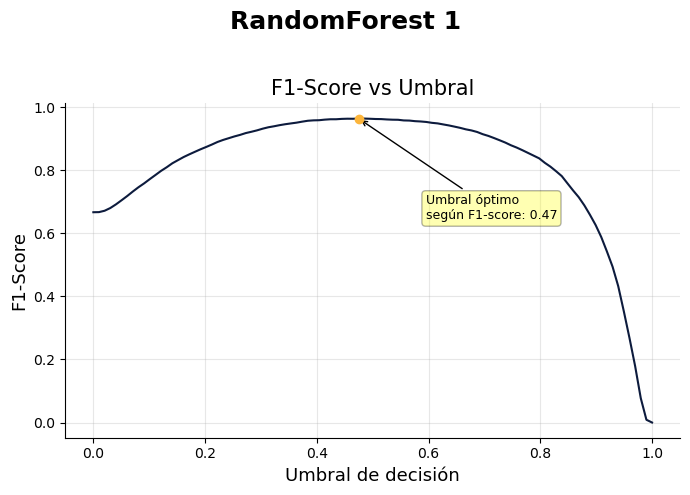

In [119]:
umbral_rf_1, plot_umbral_rf1 = plot_umbrales(modelo=rf_1, 
                                score='F1-Score',
                                x=X_train,
                                y=y_train,
                                caja_x=0.12, 
                                caja_y=0.32, 
                                nombre='RandomForest 1')

In [120]:
rf_1_results_umbral = metricas_evaluacion(rf_1,
                                          X_test,
                                          y_test,
                                          nombre='RandomForest 1',
                                          umbral=umbral_rf_1)
rf_1_results_umbral

{'Model': 'RandomForest 1',
 'Accuracy': 0.8608,
 'Precision': 0.6278,
 'Recall': 0.6513,
 'F1-score': 0.6393,
 'AUC': 0.8913,
 'Umbral': 0.4747474747474748}

In [121]:
rf_1_importances = rf_1.feature_importances_
df_rf_1_importances = pd.DataFrame({'Feature': X_train.columns, 'Importancia': rf_1_importances})
df_rf_1_importances = df_rf_1_importances.sort_values(by='Importancia', ascending=False)
df_rf_1_importances

,Feature,Importancia
4,Age,0.176902
20,ss_q2q3_rate_of_change,0.115794
9,IsActiveMember,0.103441
7,NumOfProducts,0.103034
0,Geography_Germany,0.066925
13,days_since_last_tx,0.062261
18,days_since_last_ss,0.053477
2,Gender_Male,0.050580
16,avg_ss_duration,0.028805
6,Balance,0.028230


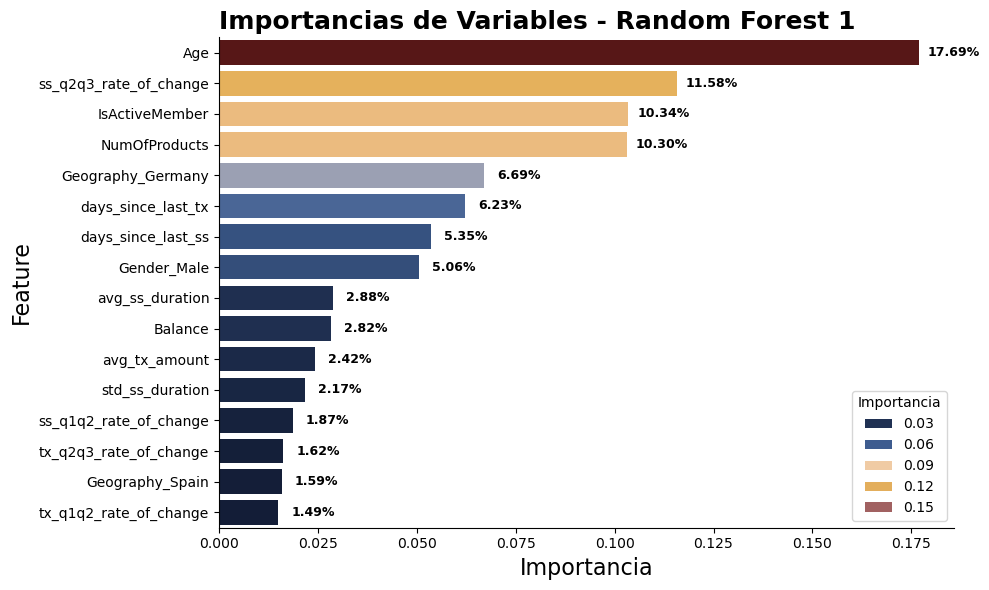

In [122]:
plot_analisis_variables(df=df_rf_1_importances,
                        analisis='Importancia',
                        nombre_modelo='Random Forest 1',
                        save='rf_1',
                        n_vars=16,
                        space=0.05,
                        cmap=reverse_custom_cmap)

In [123]:
pd.DataFrame(rf_results_tracking)

,Model,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,Train RandomForest 1,0.9629,0.9675,0.9581,0.9628,0.9948,0.5
1,RandomForest 1,0.8723,0.6728,0.6340,0.6528,0.8913,0.5


### <font color='#FDD2A9'>**Observaciones: RandomForest 1 - max_depth=10**</font>

A pesar de presentar un marcado sobreajuste ***(overfitting)***, el modelo `RandomForest 1` muestra mejoras significativas en los datos de evaluación.

Esto es una buena señal y prueba de que este tipo de modelo, al ser más complejo, consigue captar mejor el patrón presente en los datos.
Es posible observar que, si bien no consigue alcanzar el **Recall** de `LogisticRegression 3`, su **Precision** supera ampliamante la de este último. Esto permitirá, una vez optimizados sus hiperparámetros y así su desempeño, modificar el umbral de decisión para alcanzar los estándares necesarios en **Recall** y posiblemente manteniendo una buena eficiencia en cuanto a Falsos Positivos.

### <font color='#FCB53B'>**Random Forest 2  - GridSearch**</font>

Antes de hacer una búsqueda exhaustiva de hiperparámetros para esta familia de algoritmos, se realizará un GridSearch relativamente pequeño para observar que tanto mejoran las métricas y validar si será óptima la utilización de tiempo y recursos para llevar su performance al máximo.

In [124]:

warnings.filterwarnings('error')

param_grid = {
    'max_depth': [5, 7, 10],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 3],
    'n_estimators': [100, 150]
}

rf_2 = GridSearchCV(RandomForestClassifier(random_state=RANDOM_SEED),
                    param_grid=param_grid, scoring='recall',
                    cv=skf)

rf_2.fit(X_train, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [5, 7, 10], 'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 5],
                         'n_estimators': [100, 150]},
             scoring='recall')

In [125]:
#rf_2.best_params_

In [126]:
# Se conservará el resultado del GridSearch en caso de que se necesite reejecutar el script
#rf_2 = RandomForestClassifier(max_depth=10, min_samples_leaf=1, min_samples_split=5,
#                              n_estimators=150, random_state=RANDOM_SEED)

In [127]:
#rf_2.fit(X_train, y_train)

In [128]:
rf_2_train_results = metricas_evaluacion(rf_2,
                                         X_train,
                                         y_train,
                                         nombre='Train RandomForest 2')
rf_2_train_results

{'Model': 'Train RandomForest 2',
 'Accuracy': 0.9608,
 'Precision': 0.9664,
 'Recall': 0.9549,
 'F1-score': 0.9606,
 'AUC': 0.9942,
 'Umbral': 0.5}

In [129]:
rf_results_tracking.append(rf_2_train_results)

In [130]:
rf_2_results = metricas_evaluacion(rf_2,
                                   X_test,
                                   y_test,
                                   nombre='RandomForest 2')
rf_2_results

{'Model': 'RandomForest 2',
 'Accuracy': 0.8695,
 'Precision': 0.6646,
 'Recall': 0.6282,
 'F1-score': 0.6459,
 'AUC': 0.8936,
 'Umbral': 0.5}

In [131]:
rf_results_tracking.append(rf_2_results)

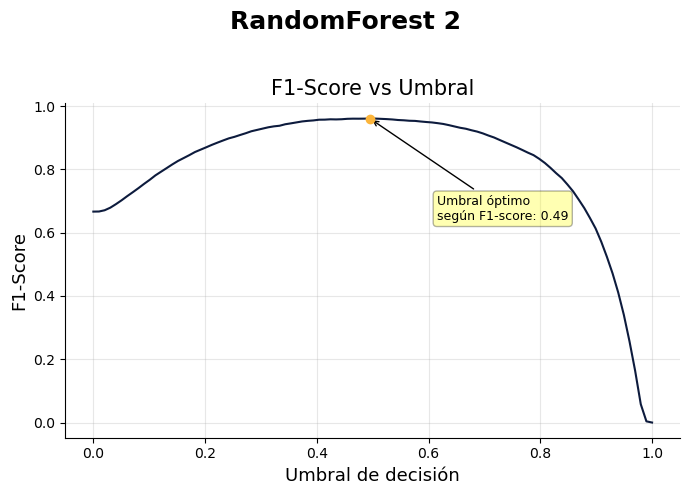

In [132]:
umbral_rf_2, plot_umbral_rf2 = plot_umbrales(modelo=rf_2, 
                                            score='F1-Score',
                                            x=X_train,
                                            y=y_train,
                                            caja_x=0.12, 
                                            caja_y=0.32, 
                                            nombre='RandomForest 2')

In [133]:
rf_2_results_umbral = metricas_evaluacion(rf_2,
                                          X_test,
                                          y_test,
                                          nombre='Train RandomForest 2',
                                          umbral=umbral_rf_2)
rf_2_results_umbral

{'Model': 'Train RandomForest 2',
 'Accuracy': 0.869,
 'Precision': 0.6597,
 'Recall': 0.6369,
 'F1-score': 0.6481,
 'AUC': 0.8936,
 'Umbral': 0.494949494949495}

In [134]:
pd.DataFrame(rf_results_tracking)

,Model,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,Train RandomForest 1,0.9629,0.9675,0.9581,0.9628,0.9948,0.5
1,RandomForest 1,0.8723,0.6728,0.6340,0.6528,0.8913,0.5
2,Train RandomForest 2,0.9608,0.9664,0.9549,0.9606,0.9942,0.5
3,RandomForest 2,0.8695,0.6646,0.6282,0.6459,0.8936,0.5


### <font color='#FDD2A9'>**Observaciones: RandomForest 2 - GridSearch**</font>

Después del **GridSearch** en busca de la optimización de hiperparámetros, no sólo se obtuvieron resultados ligeramente peores que en `RandomForest 1`, sino que el modelo aún sigue sobreajustando a los datos de entrenamiento.

Esto demuestra que el espacio de búsqueda definido no fue el apropiado para regularizar el comportamiento del modelo. Por ello se realizarán más experimentos referentes a esta familia de algoritmos.

### <font color='#FCB53B'>**Random Forest - Feature Selection**</font>

A continuación se buscará simplificar la dimensionalidad del modelo.

In [135]:
feature_selection = []

ct_features = [i if i != 0 else 1 for i in range(0, len(rf_1_importances) + 1, 3)]

for i in ct_features:
    model_features = RandomForestClassifier(max_depth=10, random_state=RANDOM_SEED)
    selected_features = df_rf_1_importances['Feature'].values[:i]
    X_train_sel = X_train[selected_features]
    X_test_sel = X_test[selected_features]
    model_features.fit(X_train_sel, y_train)
    metricas = metricas_evaluacion(model_features, X_test_sel, y_test, f'Features: {i}')
    feature_selection.append(metricas)

pd.DataFrame(feature_selection)

,Model,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,Features: 1,0.8095,0.4962,0.3718,0.4250,0.7297,0.5
1,Features: 3,0.8308,0.5476,0.6138,0.5788,0.8167,0.5
2,Features: 6,0.8630,0.6341,0.6542,0.6440,0.8720,0.5
3,Features: 9,0.8614,0.6303,0.6484,0.6392,0.8816,0.5
4,Features: 12,0.8684,0.6489,0.6657,0.6572,0.8902,0.5
5,Features: 15,0.8695,0.6561,0.6542,0.6551,0.8921,0.5
6,Features: 18,0.8674,0.6512,0.6455,0.6483,0.8925,0.5
7,Features: 21,0.8679,0.6531,0.6455,0.6493,0.8953,0.5
8,Features: 24,0.8695,0.6636,0.6311,0.6470,0.8934,0.5


### <font color='#FDD2A9'>**Observaciones: RandomForest - Feature Selection**</font>

Es posible observar que el modelo **Random Forest** consigue el mejor **Recall** utilizando solo las 12 variables principales determinadas por `RandomForest 1`.

Esto indica que se puede simplificar el modelo y aún así obtener resultados relevantes, de hecho muy similares a los obtenidos en `RandomForest 1`, con la mitad de características utilizadas.

El simplificar el modelo trae numerosos beneficios, tales como: 
* **Baja latencia** en entornos productivos.
* **Ahorro en computo y tiempo** necesario para el reentrenamiento debido al **data drift**.
* **Ahorro en computo y almacenamiento** para el procesamiento de datos necesarios para consumir el modelo.
* Entre otros..

Por estas razones, se buscará optimizar al máximo un modelo perteneciente a esta familia, utilizando las 12 variables más significativas y buscando maximizar su performance.

### <font color='#FCB53B'>**RandomForest 3 - Selected Features (12) - Randomized Search**</font>

In [136]:
selected_features = df_rf_1_importances['Feature'].values[:12]

In [137]:
df_rf_1_importances[df_rf_1_importances['Feature'].isin(selected_features)]

,Feature,Importancia
4,Age,0.176902
20,ss_q2q3_rate_of_change,0.115794
9,IsActiveMember,0.103441
7,NumOfProducts,0.103034
0,Geography_Germany,0.066925
13,days_since_last_tx,0.062261
18,days_since_last_ss,0.053477
2,Gender_Male,0.050580
16,avg_ss_duration,0.028805
6,Balance,0.028230


In [138]:
len(selected_features)

12

In [139]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

In [140]:
rf_3 = RandomForestClassifier(random_state=RANDOM_SEED)

In [141]:
from timeit import default_timer as timer
def print_timediff(start: float,
                   end: float,
                   nombre_modelo: str):
    
    """ 
    Función para medir el tiempo de entrenamiento
    """

    total_time = end - start
    model_timing = {'Modelo': nombre_modelo,
                    'Tiempo entrenamiento': np.round(total_time, 4)}
    
    print(f'Tiempo de entrenamiento de {nombre_modelo}: {total_time:.4f} seconds')
    return model_timing

In [142]:
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(5, 15),
    'min_samples_leaf': randint(1, 10),
    'min_samples_split': randint(2, 10),
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}


random_search = RandomizedSearchCV(
    rf_3,
    param_distributions=param_dist,
    n_iter=250,
    cv=skf,
    scoring='recall',
    random_state=RANDOM_SEED,
    n_jobs=-1
)


In [143]:

start_time = timer()
random_search.fit(X_train[selected_features], y_train)
end_time = timer()

rf_3_ttime = print_timediff(start=start_time,
                            end=end_time,
                           nombre_modelo='RandomForest 3')


Tiempo de entrenamiento de RandomForest 3: 1643.7659 seconds


In [144]:
random_search.best_params_

{'criterion': 'gini',
 'max_depth': 13,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 447}

In [145]:
best_rf_3 = random_search.best_estimator_

In [146]:
"""
rf_params = {
    'criterion': 'gini',
    'max_depth': 13,
    'max_features': 'sqrt',
    'min_samples_leaf': 1,
    'min_samples_split': 4,
    'n_estimators': 447
}
"""


"\nrf_params = {\n    'criterion': 'gini',\n    'max_depth': 13,\n    'max_features': 'sqrt',\n    'min_samples_leaf': 1,\n    'min_samples_split': 4,\n    'n_estimators': 447\n}\n"

In [147]:
#rf_3 = RandomForestClassifier(**rf_params, random_state=RANDOM_SEED)
#rf_3.fit(X_train, y_train)

In [148]:
rf_3_train_results = metricas_evaluacion(best_rf_3,
                                         X_train[selected_features],
                                         y_train,
                                         nombre='Train RandomForest 3')
rf_3_train_results

{'Model': 'Train RandomForest 3',
 'Accuracy': 0.9826,
 'Precision': 0.9877,
 'Recall': 0.9773,
 'F1-score': 0.9825,
 'AUC': 0.9991,
 'Umbral': 0.5}

In [149]:
rf_results_tracking.append(rf_3_train_results)

In [150]:
rf_3_results = metricas_evaluacion(best_rf_3,
                                         X_test[selected_features],
                                         y_test,
                                         nombre='RandomForest 3')
rf_3_results

{'Model': 'RandomForest 3',
 'Accuracy': 0.8739,
 'Precision': 0.6737,
 'Recall': 0.6484,
 'F1-score': 0.6608,
 'AUC': 0.893,
 'Umbral': 0.5}

In [151]:
rf_results_tracking.append(rf_3_results)

In [152]:
pd.DataFrame(rf_results_tracking)

,Model,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,Train RandomForest 1,0.9629,0.9675,0.9581,0.9628,0.9948,0.5
1,RandomForest 1,0.8723,0.6728,0.6340,0.6528,0.8913,0.5
2,Train RandomForest 2,0.9608,0.9664,0.9549,0.9606,0.9942,0.5
3,RandomForest 2,0.8695,0.6646,0.6282,0.6459,0.8936,0.5
4,Train RandomForest 3,0.9826,0.9877,0.9773,0.9825,0.9991,0.5
5,RandomForest 3,0.8739,0.6737,0.6484,0.6608,0.8930,0.5


### <font color='#FDD2A9'>**Observaciones: RandomForest 3 - Randomized Search**</font>

Las mejoras obtenidas a partir de **Randomized Search** no justifican el tiempo de entrenamiento: **1557.9017 seconds *(Más de 25 minutos)***.
Esto indica que el esta familia alcanza su máximo potencial con tan solo controlar levemente su profundidad máxima.

Para mejorar el rendimiento de este algoritmo, se debería abordar los datos utilizados, es decir, generar mayor cantidad de features que permitan al modelo aprender mejor las relaciones entre estos y mejorar su rendimiento.

Aún así, se conservará `RandomForest 3` entrenado con `X_train[selected_features]` como representante de esta familia. Sus hiperparámetros:

```
{
'criterion': 'gini',
 'max_depth': 13,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 447
 }
```

In [153]:
best_models.append(rf_3_results)

In [154]:
pd.DataFrame(best_models)

,Model,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,Baseline Model,0.8215,0.5234,0.6455,0.5781,0.7758,0.444444
1,LogisticRegression 3,0.7587,0.4235,0.7579,0.5434,0.8268,0.500000
2,RandomForest 3,0.8739,0.6737,0.6484,0.6608,0.8930,0.500000


## <font color='#8b1f1f'>**Conclusiones: Random Forest**</font>

La familia de **Random Forest** se mostró más robusta que la **Regresión Logística**. Si bien no consigue un nivel de **Recall** (métrica que se busca maximizar) lo suficientemente elevado. El resto de sus métricas presentan un mayor balance.

| Model	                | Accuracy	| Precision	| Recall	| F1-score	| AUC	    | Umbral    |
|-----------------------|-----------|-----------|-----------|-----------|-----------|-----------|
| LogisticRegression 3	| 0.7587	| 0.4235	| 0.7579	| 0.5434	| 0.8268	| 0.5       | 
| RandomForest 3	    | 0.8739	| 0.6737	| 0.6484	| 0.6608	| 0.8930	| 0.5       |


Particularmente es posible observar el **trade-off entre Precision y Recall**:

* **Regresión Logística**: para alcanzar un **Recall de 0.75**, requiere una **Precisión de 0.42**.
* **Random Forest**: para un **Recall de 0.64** *(-0.11 que su competidor hasta el momento)*, su **Precisión es de 0.67** *(0.25 mayor que `LogisticRegression`)*

Esto sugiere que al modificar el umbral de decisión en ambos modelos, `RandomForest 3` mostrará un desempeño general superior a `LogisticRegression 3`.

## <font color='#c37171'>**LightGBM Classifier**</font>

### <font color='#FCB53B'>**LightGBM 1 - Default**</font>

In [155]:
lgbm_results_tracking = []

In [156]:
lgbm_1 = lgb.LGBMClassifier(random_state=RANDOM_SEED)

In [157]:
lgbm_1.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 5936, number of negative: 5936
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6099
[LightGBM] [Info] Number of data points in the train set: 11872, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(random_state=42)

In [158]:
lgbm_1_train_results = metricas_evaluacion(lgbm_1,
                                           X_train,
                                           y_train,
                                           nombre='Train LightGBM 1')
lgbm_1_train_results

{'Model': 'Train LightGBM 1',
 'Accuracy': 0.9739,
 'Precision': 0.985,
 'Recall': 0.9624,
 'F1-score': 0.9736,
 'AUC': 0.9977,
 'Umbral': 0.5}

In [159]:
lgbm_results_tracking.append(lgbm_1_train_results)

In [160]:
lgbm_1_results = metricas_evaluacion(lgbm_1,
                                     X_test,
                                     y_test,
                                     nombre='LightGBM 1')
lgbm_1_results

{'Model': 'LightGBM 1',
 'Accuracy': 0.8979,
 'Precision': 0.7597,
 'Recall': 0.6744,
 'F1-score': 0.7145,
 'AUC': 0.9122,
 'Umbral': 0.5}

In [161]:
lgbm_results_tracking.append(lgbm_1_results)

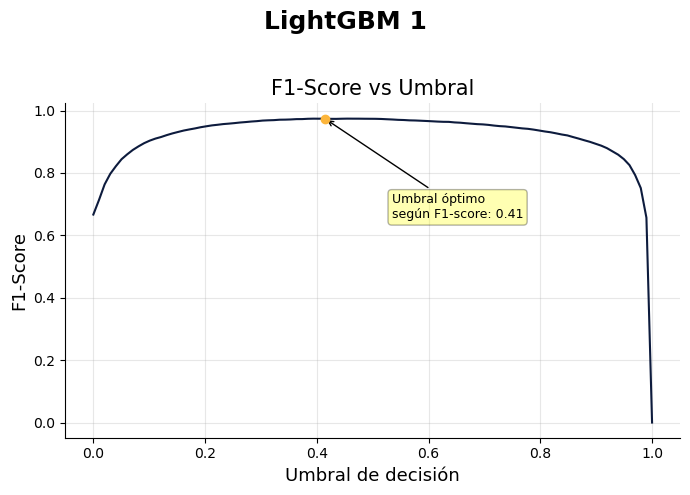

In [162]:
umbral_lgbm_1, plot_umbral_lgbm_1 = plot_umbrales(modelo=lgbm_1, 
                                                score='F1-Score',
                                                x=X_train,
                                                y=y_train,
                                                caja_x=0.12, 
                                                caja_y=0.32, 
                                                nombre='LightGBM 1')

In [163]:
lgbm_1_results_umbral = metricas_evaluacion(lgbm_1,
                                            X_test,
                                            y_test,
                                            nombre='LightGBM 1',
                                            umbral=umbral_lgbm_1)

In [164]:
pd.DataFrame([lgbm_1_train_results, lgbm_1_results, lgbm_1_results_umbral])

,Model,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,Train LightGBM 1,0.9739,0.9850,0.9624,0.9736,0.9977,0.500000
1,LightGBM 1,0.8979,0.7597,0.6744,0.7145,0.9122,0.500000
2,LightGBM 1,0.8908,0.7155,0.7032,0.7093,0.9122,0.414141


### <font color='#FDD2A9'>**Observaciones: LightGBM 1 - Default**</font>

El modelo **LightGBM** con sus hiperparámetros por defecto, alcanza el mejor rendimineto obtenido hasta el momento.

Sus métricas son lo suficientemente elevadas y estables. Esto es un indicador que el modelo consigue entender mejor los patrones compejos presente en los datos.

| Model         | Accuracy   | Precision  | Recall	  | F1-score   | AUC	  | Umbral   |
|---------------|------------|------------|-----------|------------|----------|----------|
| LightGBM 1	| 0.8908     | 0.7155	  | 0.7032	  | 0.7093	   | 0.9122	  | 0.414141 |


Al modificar el umbral de decisión, todas las métricas obtienen un score de al menos 0.7. Lo cual postula a esta familia como una muy buena candidata para modelo en producción.

Sin embargo, es posible observar en las métricas de entrenamiento que el modelo está sobreajustado a los datos de entrenamiento.
Por lo que se hará una investigación exhaustiva de los mejores hiperparámetros, y luego se entrenará haciendo uso de la funcionalidad `early_stopping` para evitar el sobreajuste.

### <font color='#FCB53B'>**LightGBM 2 - Hyperparameter Randomized Search**</font>

In [165]:
lgbm_2 = lgb.LGBMClassifier(random_state=RANDOM_SEED)

In [166]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)

In [167]:
param_dist = {
    'n_estimators': randint(100, 500),         
    'learning_rate': uniform(0.01, 0.05),      
    'num_leaves': randint(15, 40),             
    'max_depth': randint(5, 15),
    'min_child_samples': randint(20, 50),     
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
    'reg_alpha': uniform(0, 1), 
    'reg_lambda': uniform(0, 1) 
}

random_search = RandomizedSearchCV(
    lgbm_2,
    param_distributions=param_dist,
    n_iter=150,
    cv=skf,
    scoring='recall',
    random_state=RANDOM_SEED,
    n_jobs=-1
)

In [168]:
start_time = timer()
random_search.fit(X_train, y_train)
end_time = timer()

lgbm_2_ttime = print_timediff(start=start_time,
                              end=end_time,
                              nombre_modelo='LightGBM 2')

[LightGBM] [Info] Number of positive: 5936, number of negative: 5936
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6099
[LightGBM] [Info] Number of data points in the train set: 11872, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Tiempo de entrenamiento de LightGBM 2: 193.2604 seconds


In [169]:
lgbm_best_params = random_search.best_params_

In [170]:
best_lgbm_2 = random_search.best_estimator_

In [171]:
lgbm_2_train_results = metricas_evaluacion(best_lgbm_2,
                                           X_train,
                                           y_train,
                                           nombre='Train LightGBM 2')
lgbm_2_train_results

{'Model': 'Train LightGBM 2',
 'Accuracy': 0.9949,
 'Precision': 0.9985,
 'Recall': 0.9914,
 'F1-score': 0.9949,
 'AUC': 0.9999,
 'Umbral': 0.5}

In [172]:
lgbm_results_tracking.append(lgbm_2_train_results)

In [173]:
lgbm_2_results = metricas_evaluacion(best_lgbm_2,
                                           X_test,
                                           y_test,
                                           nombre='LightGBM 2')
lgbm_2_results

{'Model': 'LightGBM 2',
 'Accuracy': 0.9001,
 'Precision': 0.768,
 'Recall': 0.6772,
 'F1-score': 0.7198,
 'AUC': 0.9112,
 'Umbral': 0.5}

In [174]:
lgbm_results_tracking.append(lgbm_2_results)

In [175]:
pd.DataFrame(lgbm_results_tracking)

,Model,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,Train LightGBM 1,0.9739,0.9850,0.9624,0.9736,0.9977,0.5
1,LightGBM 1,0.8979,0.7597,0.6744,0.7145,0.9122,0.5
2,Train LightGBM 2,0.9949,0.9985,0.9914,0.9949,0.9999,0.5
3,LightGBM 2,0.9001,0.7680,0.6772,0.7198,0.9112,0.5


### <font color='#FDD2A9'>**Observaciones: LightGBM 2 - Hyperparameter Randomized Search**</font>

Si bien existe una leve mejora en las métricas obtenidas *(aproximadamente un promedio de 0.005)*, también es posible ver un mayor sobreajuste.

Esto posiblemente se debe al hecho de que al ajustar los hiperparámetros disponibles, el modelo se ha complejizado, memorizando aún más el patrón presente en los datos sobre los que fue entrenados.
Por lo qué, a continuación, se utilizarán los hiperparámetros obtenidos con **Randomized Search** para entrenar un nuevo modelo con `early_stopping` y así controlar el sobreajuste.



Hiperparámetros para LightGBM 3:


```
{'colsample_bytree': 0.8185450708005443,
 'learning_rate': 0.05633294328968971,
 'max_depth': 12,
 'min_child_samples': 33,
 'n_estimators': 314,
 'num_leaves': 39,
 'reg_alpha': 0.9611720243493491,
 'reg_lambda': 0.8445338486781514,
 'subsample': 0.9241960330412142}
```

### <font color='#FCB53B'>**LightGBM 3 - Early Stopping**</font>

Para poder utilizar la funcionalidad de `early_stopping` se necesita contar con un conjunto de validación que será el utilizado para monitorear las métricas durante el entrenamiento y determinar cuando el modelo comienza a sobreajustar.

In [176]:
lgbm_best_params

{'colsample_bytree': 0.8185450708005443,
 'learning_rate': 0.05633294328968971,
 'max_depth': 12,
 'min_child_samples': 33,
 'n_estimators': 314,
 'num_leaves': 39,
 'reg_alpha': 0.9611720243493491,
 'reg_lambda': 0.8445338486781514,
 'subsample': 0.9241960330412142}

In [177]:
X_train_sub, X_val, y_train_sub, y_val = tts(X_train, y_train, test_size=0.2, stratify=y_train, random_state=RANDOM_SEED)

In [178]:
lgbm_3 = lgb.LGBMClassifier(**lgbm_best_params, random_state=RANDOM_SEED)

In [179]:
start_time = timer()

lgbm_3.fit(
    X_train_sub,
    y_train_sub,
    eval_set=[(X_val, y_val)],
    eval_metric='recall',
    callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=True, min_delta=0.01)]
)
    
end_time = timer()

lgbm_3_ttime = print_timediff(start=start_time,
                              end=end_time,
                              nombre_modelo='LightGBM 3')

[LightGBM] [Info] Number of positive: 4749, number of negative: 4748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6091
[LightGBM] [Info] Number of data points in the train set: 9497, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500053 -> initscore=0.000211
[LightGBM] [Info] Start training from score 0.000211
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[77]	valid_0's binary_logloss: 0.204526
Tiempo de entrenamiento de LightGBM 3: 0.2675 seconds


In [180]:
lgb.early_stopping

<function lightgbm.callback.early_stopping(stopping_rounds: int, first_metric_only: bool = False, verbose: bool = True, min_delta: Union[float, List[float]] = 0.0) -> lightgbm.callback._EarlyStoppingCallback>

In [181]:
lgbm_3_train_results = metricas_evaluacion(lgbm_3,
                                           X_train_sub,
                                           y_train_sub,
                                           nombre='Train LightGBM 3')
lgbm_3_train_results

{'Model': 'Train LightGBM 3',
 'Accuracy': 0.9485,
 'Precision': 0.9616,
 'Recall': 0.9343,
 'F1-score': 0.9478,
 'AUC': 0.9897,
 'Umbral': 0.5}

In [182]:
lgbm_results_tracking.append(lgbm_3_train_results)

In [183]:
lgbm_3_results = metricas_evaluacion(lgbm_3,
                                           X_test,
                                           y_test,
                                           nombre='LightGBM 3')
lgbm_3_results

{'Model': 'LightGBM 3',
 'Accuracy': 0.881,
 'Precision': 0.6985,
 'Recall': 0.6542,
 'F1-score': 0.6756,
 'AUC': 0.903,
 'Umbral': 0.5}

In [184]:
lgbm_results_tracking.append(lgbm_3_results)

In [185]:
pd.DataFrame(lgbm_results_tracking)

,Model,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,Train LightGBM 1,0.9739,0.9850,0.9624,0.9736,0.9977,0.5
1,LightGBM 1,0.8979,0.7597,0.6744,0.7145,0.9122,0.5
2,Train LightGBM 2,0.9949,0.9985,0.9914,0.9949,0.9999,0.5
3,LightGBM 2,0.9001,0.7680,0.6772,0.7198,0.9112,0.5
4,Train LightGBM 3,0.9485,0.9616,0.9343,0.9478,0.9897,0.5
5,LightGBM 3,0.8810,0.6985,0.6542,0.6756,0.9030,0.5


### <font color='#FDD2A9'>**Observaciones: LightGBM 3 - Early Stopping**</font>

El resultado del entrenamiento con `early_stopping` permite obtener métricas un poco más realistas.

Como se observa en el DataFrame utilizado para mantener el registro de los experimentos, las métricas de `LightGBM 3` son las que **"más se alejan de ser perfectas"**. 

Buscando luchar con el problema presente en los datos, donde como se menciona al principio del notebook aún requiere mayor variabilidad, al establecer un **delta mínimo de 0.01** y un mecanismo para detener el entrenamiento (`early_stopping`), el sobreajuste en el entrenamiento se pudo controlar levemente.

## <font color='#8b1f1f'>**Conclusiones: LightGBM Classifier**</font>

LightGBM mostró un mejor balance dado que fue posible controlar el sobreajuste a los datos de entrenamiento:

| Model	                      | Accuracy	 | Precision   | Recall	   | F1-score  | AUC	 | Umbral  |
|-----------------------------|--------------|-------------|-----------|-----------|---------|---------|
| Train LogisticRegression 3  | 0.7886	     | 0.7856	   | 0.7938	   | 0.7897	   | 0.8663  | 0.5     |
| LogisticRegression 3	      | 0.7587	     | 0.4235	   | 0.7579	   | 0.5434	   | 0.8268	 | 0.5     |
| Train RandomForest 3        | 0.9826    	 | 0.9877	   | 0.9773	   | 0.9825	   | 0.9991	 | 0.5     |
| RandomForest 3	          | 0.8739	     | 0.6737	   | 0.6484	   | 0.6608	   | 0.8930	 | 0.5     |
| Train LightGBM 3	          | 0.9485	     | 0.9616	   | 0.9343	   | 0.9478    | 0.9897	 | 0.5     |
| LightGBM 3	              | 0.8810	     | 0.6985	   | 0.6542	   | 0.6756	   | 0.9030	 | 0.5     |

Si se compara con los modelos `LogisticRegression 3` y `RandomForest 3`, el primero es el que muestra las métricas más realistas, y por ende, las más inestables. Pero su Precisión es extremadamente baja, por lo cual no es ideal.

Dado que existe falta de variabilidad en los datos, el objetivo es encontrar un modelo que presente un buen desempeño, pero que a su vez pueda ser confiable en entorno productivo y con datos reales, ya que aquí los datos han sido confeccionados artificialmente. `LightGBM 3` se postula como el modelo para producción hasta el momento.

In [186]:
best_models.append(lgbm_3_results)
pd.DataFrame(best_models)

,Model,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,Baseline Model,0.8215,0.5234,0.6455,0.5781,0.7758,0.444444
1,LogisticRegression 3,0.7587,0.4235,0.7579,0.5434,0.8268,0.500000
2,RandomForest 3,0.8739,0.6737,0.6484,0.6608,0.8930,0.500000
3,LightGBM 3,0.8810,0.6985,0.6542,0.6756,0.9030,0.500000


## <font color='#c37171'>**XGBoost Classifier**</font>

In [187]:
xgb_results_tracking = []

### <font color='#FCB53B'>**XGB Classifier 1 - max_depth=10 - early_stopping_rounds=10**</font>

In [188]:
xgb_1 = XGBClassifier(max_depth=10, random_state=RANDOM_SEED, early_stopping_rounds=10, eval_metric='logloss')

xgb_1.fit(X_train_sub, y_train_sub, eval_set=[(X_val, y_val)], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [189]:
xgb_1_train_results = metricas_evaluacion(xgb_1,
                                          X_train_sub,
                                          y_train_sub,
                                          nombre='Train XGB 1')
xgb_1_train_results

{'Model': 'Train XGB 1',
 'Accuracy': 1.0,
 'Precision': 1.0,
 'Recall': 1.0,
 'F1-score': 1.0,
 'AUC': 1.0,
 'Umbral': 0.5}

In [190]:
xgb_results_tracking.append(xgb_1_train_results)

In [191]:
xgb_1_results = metricas_evaluacion(xgb_1,
                                    X_test,
                                    y_test,
                                    nombre='XGB 1')
xgb_1_results

{'Model': 'XGB 1',
 'Accuracy': 0.8794,
 'Precision': 0.6994,
 'Recall': 0.6369,
 'F1-score': 0.6667,
 'AUC': 0.8941,
 'Umbral': 0.5}

In [192]:
xgb_results_tracking.append(xgb_1_results)

### <font color='#FDD2A9'>**Observaciones: XGB Classifier 1 - max_depth=10 - early_stopping_rounds=10**</font>

Si bien las métricas en el conjunto de evaluación podrían parecer competitivas, el hecho de que estas en los datos de entrenamiento presenten absoluta perfección es lo único necesario para establecer que este modelo no puede ser juzgado de manera justa.

Para poder obtener un modelo de esta familia que pueda compararse con el resto, será necesario establecer buenas técnicas de regularización y control del sobreajuste.

### <font color='#FCB53B'>**XGB Classifier 2 - GridSearch - early_stopping_rounds=5**</font>

Ya se vió en ocasiones anteriores que una optimización excesiva complejiza tanto el modelo que resulta demasiado para los datos generados artificialmente, por lo que se explorarán inicialmente algunas opciones de regularización en busca de controlar el sobreajuste.

In [193]:
param_grid = {
    'max_depth': [10, 15],
    'min_child_weight': [2, 5],
    'reg_alpha': [0.8, 1.0, 1.2],
    'gamma': [0, 0.1, 0.2, 0.5],
    'learning_rate': [0.05, 0.1]
}


xgb_gs = XGBClassifier(random_state=RANDOM_SEED, early_stopping_rounds=5, eval_metric='logloss', n_estimators=500)

xgb_2 = GridSearchCV(xgb_gs, param_grid=param_grid, scoring='recall', cv=skf)

fit_params =  {'eval_set': [(X_val, y_val)], 'verbose': False}

start_time = timer()
xgb_2.fit(X_train_sub, y_train_sub, **fit_params)
end_time = timer()

xgb_2_ttime = print_timediff(start=start_time,
                            end=end_time,
                            nombre_modelo='XGB 2')

Tiempo de entrenamiento de XGB 2: 228.6018 seconds


In [194]:
xgb_2.best_params_

{'gamma': 0.1,
 'learning_rate': 0.1,
 'max_depth': 15,
 'min_child_weight': 2,
 'reg_alpha': 1.0}

In [195]:
xgb_2_train_results = metricas_evaluacion(xgb_2,
                                          X_train_sub,
                                          y_train_sub,
                                          nombre='Train XGB 2')
xgb_2_train_results

{'Model': 'Train XGB 2',
 'Accuracy': 0.9999,
 'Precision': 1.0,
 'Recall': 0.9998,
 'F1-score': 0.9999,
 'AUC': 1.0,
 'Umbral': 0.5}

In [196]:
xgb_results_tracking.append(xgb_2_train_results)

In [197]:
xgb_2_results = metricas_evaluacion(xgb_2,
                                    X_test,
                                    y_test,
                                    nombre='XGB 2')
xgb_2_results

{'Model': 'XGB 2',
 'Accuracy': 0.881,
 'Precision': 0.7129,
 'Recall': 0.6225,
 'F1-score': 0.6646,
 'AUC': 0.9018,
 'Umbral': 0.5}

In [198]:
xgb_results_tracking.append(xgb_2_results)

### <font color='#FDD2A9'>**Observaciones: XGB Classifier 2 - GridSearch - early_stopping_rounds=5**</font>

Si bien las métricas de evaluación mejoraron, el sobreajuste sigue siendo excesivo. Mostrando métricas perfectas.

```
{'gamma': 0.1,
 'learning_rate': 0.1,
 'max_depth': 15,
 'min_child_weight': 2,
 'reg_alpha': 1.0}
```

Dado que se alcanzó el valor máximo de reg_alpha y gamma no fue utilizado, se obligará a que el modelo utilice este último hiperparámetro y se otorgará un mayor rango de reg_alpha. 

### <font color='#FCB53B'>**XGB Classifier 3 - Randomized Search - early_stopping_rounds=5**</font>

In [199]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

In [200]:
xgb_rs = XGBClassifier(random_state=RANDOM_SEED, early_stopping_rounds=5, eval_metric='logloss')

param_dist = {
    'n_estimators': randint(100, 500),         
    'learning_rate': uniform(0.01, 0.09),      
    'max_depth': randint(5, 15),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0.1, 0.9),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'reg_alpha': uniform(0, 2.5), 
    'reg_lambda': uniform(0, 2.5) 
}


random_search = RandomizedSearchCV(
    xgb_rs,
    param_distributions=param_dist,
    n_iter=250,
    cv=skf,
    scoring='recall',
    random_state=RANDOM_SEED,
    n_jobs=-1
)


fit_params =  {'eval_set': [(X_val, y_val)], 'verbose': False}

start_time = timer()
random_search.fit(X_train_sub, y_train_sub, **fit_params)
end_time = timer()

xgb_3_ttime = print_timediff(start=start_time,
                              end=end_time,
                              nombre_modelo='XGB 3')

Tiempo de entrenamiento de XGB 3: 460.0958 seconds


In [201]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

In [202]:
xgb_3 = random_search.best_estimator_

In [203]:
xgb_3_params = random_search.best_params_

In [204]:
xgb_3_train_results = metricas_evaluacion(xgb_3,
                                          X_train_sub,
                                          y_train_sub,
                                          nombre='Train XGB 3')
xgb_3_train_results

{'Model': 'Train XGB 3',
 'Accuracy': 0.9959,
 'Precision': 0.9989,
 'Recall': 0.9928,
 'F1-score': 0.9959,
 'AUC': 0.9999,
 'Umbral': 0.5}

In [205]:
xgb_results_tracking.append(xgb_3_train_results)

In [206]:
xgb_3_results = metricas_evaluacion(xgb_3,
                                          X_test,
                                          y_test,
                                          nombre='XGB 3')
xgb_3_results

{'Model': 'XGB 3',
 'Accuracy': 0.8848,
 'Precision': 0.7179,
 'Recall': 0.6455,
 'F1-score': 0.6798,
 'AUC': 0.9078,
 'Umbral': 0.5}

In [207]:
xgb_results_tracking.append(xgb_3_results)

In [208]:
xgb_3_params

{'colsample_bytree': 0.8097488757037938,
 'gamma': 0.36761954341315506,
 'learning_rate': 0.048730345975802905,
 'max_depth': 13,
 'min_child_weight': 3,
 'n_estimators': 248,
 'reg_alpha': 0.30346234855607224,
 'reg_lambda': 0.7581878689189889,
 'subsample': 0.5505229055053233}

In [209]:
pd.DataFrame(xgb_results_tracking)

,Model,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,Train XGB 1,1.0000,1.0000,1.0000,1.0000,1.0000,0.5
1,XGB 1,0.8794,0.6994,0.6369,0.6667,0.8941,0.5
2,Train XGB 2,0.9999,1.0000,0.9998,0.9999,1.0000,0.5
3,XGB 2,0.8810,0.7129,0.6225,0.6646,0.9018,0.5
4,Train XGB 3,0.9959,0.9989,0.9928,0.9959,0.9999,0.5
5,XGB 3,0.8848,0.7179,0.6455,0.6798,0.9078,0.5


### <font color='#FDD2A9'>**Observaciones: XGB Classifier 3 - Randomized Search - early_stopping_rounds=5**</font>

Al realizar una búsqueda de hiperparámetros más amplia, se consiguió disminuir levemente las métricas de entrenamiento, sin embargo, estas siguen siendo demasiado cercanas a 1. Por lo que se utilizará una regularización más severa con el objetivo de reducir las mismas aún más.

### <font color='#FCB53B'>**XGB Classifier 4 - GridSearch - early_stopping_rounds=5 - mayor regularización**</font>

In [212]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

In [213]:
xgb_gs = XGBClassifier(random_state=RANDOM_SEED, early_stopping_rounds=5, eval_metric='logloss')

param_dist = {
    'n_estimators': [100, 150, 200, 250],       
    'learning_rate': [0.1, 0.5],      
    'max_depth': [5, 7, 10],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0.2, 0.3, 0.5],
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'reg_alpha': uniform(1.5, 2.5), 
    'reg_lambda': uniform(1.5, 2.5) 
}


random_search = RandomizedSearchCV(
    xgb_gs,
    param_distributions=param_dist,
    n_iter=250,
    cv=skf,
    scoring='recall',
    random_state=RANDOM_SEED,
    n_jobs=-1
)

fit_params =  {'eval_set': [(X_val, y_val)], 'verbose': False}

start_time = timer()
random_search.fit(X_train_sub, y_train_sub, **fit_params)
end_time = timer()

xgb_4_ttime = print_timediff(start=start_time,
                              end=end_time,
                              nombre_modelo='XGB 4')

Tiempo de entrenamiento de XGB 4: 141.9475 seconds


In [214]:
xgb_4 = random_search.best_estimator_

In [215]:
xgb_4_train_results = metricas_evaluacion(xgb_4,
                                          X_train_sub,
                                          y_train_sub,
                                          nombre='Train XGB 4')
xgb_4_train_results

{'Model': 'Train XGB 4',
 'Accuracy': 0.988,
 'Precision': 0.9947,
 'Recall': 0.9813,
 'F1-score': 0.9879,
 'AUC': 0.9994,
 'Umbral': 0.5}

In [216]:
random_search.best_params_

{'colsample_bytree': 0.8803925243084487,
 'gamma': 0.3,
 'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 3,
 'n_estimators': 200,
 'reg_alpha': 1.6010839738460785,
 'reg_lambda': 3.2766572242144685,
 'subsample': 0.5554454104059157}

In [217]:
xgb_results_tracking.append(xgb_4_train_results)

In [218]:
xgb_4_results = metricas_evaluacion(xgb_4,
                                    X_test,
                                    y_test,
                                    nombre='XGB 4')
xgb_4_results 

{'Model': 'XGB 4',
 'Accuracy': 0.8876,
 'Precision': 0.7196,
 'Recall': 0.6657,
 'F1-score': 0.6916,
 'AUC': 0.8992,
 'Umbral': 0.5}

In [219]:
xgb_results_tracking.append(xgb_4_results)

In [220]:
pd.DataFrame(xgb_results_tracking)

,Model,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,Train XGB 1,1.0000,1.0000,1.0000,1.0000,1.0000,0.5
1,XGB 1,0.8794,0.6994,0.6369,0.6667,0.8941,0.5
2,Train XGB 2,0.9999,1.0000,0.9998,0.9999,1.0000,0.5
3,XGB 2,0.8810,0.7129,0.6225,0.6646,0.9018,0.5
4,Train XGB 3,0.9959,0.9989,0.9928,0.9959,0.9999,0.5
5,XGB 3,0.8848,0.7179,0.6455,0.6798,0.9078,0.5
6,Train XGB 4,0.9880,0.9947,0.9813,0.9879,0.9994,0.5
7,XGB 4,0.8876,0.7196,0.6657,0.6916,0.8992,0.5


### <font color='#FDD2A9'>**Observaciones: XGB Classifier 4 - max_depth=10 - early_stopping_rounds=10**</font>

La regularización más severa no solo consigue reducir las métricas de entrenamiento para alejarlas de la perfección lo más posible, sino que esto deriva en un mejor desempeño en los datos de entrenamiento.

Al observar el F1-score de `XGB 4`, vemos que obtiene las métricas más altas de todos los experimentos realizados dentro de esta familia de algoritmos, lo cual lo postula como representante de la misma.

In [221]:
best_models.append(xgb_4_results)

In [222]:
pd.DataFrame(best_models)

,Model,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,Baseline Model,0.8215,0.5234,0.6455,0.5781,0.7758,0.444444
1,LogisticRegression 3,0.7587,0.4235,0.7579,0.5434,0.8268,0.500000
2,RandomForest 3,0.8739,0.6737,0.6484,0.6608,0.8930,0.500000
3,LightGBM 3,0.8810,0.6985,0.6542,0.6756,0.9030,0.500000
4,XGB 4,0.8876,0.7196,0.6657,0.6916,0.8992,0.500000


## <font color='#8b1f1f'>**Conclusiones: XGBoost Classifier**</font>

El modelo **XGBoost Classifier** consigue un mejor desempeño entre todos los modelos entrenados hasta el momento. 

Se debe tener en cuenta que la búsqueda de los hiperparámetros adecuados requirió un manejo bastante manual para poder establecer una regularización adecuada para los datos disponibles, lo cual podría implicar compliaciones a la hora de automatizar el proceso de reentrenamiento. Aún así, fue gracias a esto que se consigue un modelo con un desempeño aceptable, habiendo solucionado la perfección en sus metricas de entrenamiento.

## <font color='#c37171'>**PyTorch Neural Network**</font>

Si bien se observó que los modelos demasiado complejos sobreajustan demasiado debido a la falta de variabilidad en los datos disponibles, se entrenará una pequeña Red Neuronal *(Neural Network)* para observar su rendimiento.

In [223]:
nn_results_tracking = []

### <font color='#FCB53B'>**Pytorch NN 1**</font>

In [224]:
import torch
from torch import nn

In [225]:
features = X_train.columns

In [226]:
# Device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [227]:
X_train_torch = X_train.to_numpy()
X_test_torch = X_test.to_numpy()
y_train_torch = y_train.to_numpy()
y_test_torch = y_test.to_numpy()

In [228]:
X_train_torch = torch.from_numpy(X_train_torch).type(torch.float).to(device)
X_test_torch = torch.from_numpy(X_test_torch).type(torch.float).to(device)
y_train_torch = torch.from_numpy(y_train_torch).type(torch.float).to(device)
y_test_torch = torch.from_numpy(y_test_torch).type(torch.float).to(device)

In [229]:
print('\nVisualizar shapes de los tensores:\n')
print(f'X_train: {X_train_torch.shape}\nX_test: {X_test_torch.shape}\ny_train: {y_train_torch.shape}\ny_test: {y_test_torch.shape}')


Visualizar shapes de los tensores:

X_train: torch.Size([11872, 24])
X_test: torch.Size([1832, 24])
y_train: torch.Size([11872])
y_test: torch.Size([1832])


In [230]:
def accuracy_fn(y_true, y_pred):
    """
    Calcula Accuracy entre predicciones y etiquetas reales (y_test)

    (Se utilizará para medir el entrenamiento ya que las clases están balanceadas)
    --------------------------------------------------------------------------------
    Parámetros:
        y_true: (torch.Tensor)
            Etiquetas reales de prueba (y_test).
        y_pred: (torch.Tensor)
            Predicciones de la red neuronal para ser comparadas con y_test.
    --------------------------------------------------------------------------------
    Returns:
        [torch.float]: Accuracy score
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [231]:
def metricas_evaluacion_pytorch(modelo: torch.nn, 
                                x_test: torch.tensor,
                                y_test: torch.tensor,
                                nombre: str,
                                umbral: float=None):
    """
    Funcion que calcula métricas de redes neuronales de clasificación binarias de PyTorch

    Esta función será utilizada para evaluar las redes neuronales y poder comprarlas
    de la misma manera que las otras familias de algoritmos
    ------------------------------------------------------------
    Parámetros:
    
        modelo: torch.nn
            Red Neuronal de PyTorch (subclasses NN)
            
        x_test: torch.tensor
            Tensor con los datos de prueba
            
        y_test:
            Tensor con las etiquetas reales para evaluación.
            
        nombre: str
            Nombre que identificará el modelo para comparaciones

        umbral: float
            Umbral de decisión para clasificar una observacion como positiva (1)
            
    ------------------------------------------------------------
    Returns:
        Diccionario con nombre del modelo, umbral utilizado y metricas: Accuracy, Precision, Recall, F1-score, AUC
    """

    modelo.eval()
    with torch.inference_mode():
        test_logits = modelo(x_test).squeeze()
        y_pred_proba = torch.sigmoid(test_logits)
        if umbral is None:
            y_pred_binary = torch.round(y_pred_proba)
            current_umbral = 0.5
        else:
            current_umbral = umbral
            y_pred_binary = (y_pred_proba >= umbral).int()

    # Llevar tensores a cpu y convertir en arrays numpy
    y_pred_proba_np = y_pred_proba.cpu().numpy()
    y_pred_binary_np = y_pred_binary.cpu().numpy()
    

    # Calcular métricas
    metricas = {}
    metricas['Model'] = nombre
    
    metricas['Accuracy'] = np.round(accuracy_score(y_test, y_pred_binary_np), 4)
    metricas['Precision'] = np.round(precision_score(y_test, y_pred_binary_np), 4)
    metricas['Recall'] = np.round(recall_score(y_test, y_pred_binary_np), 4)
    metricas['F1-score'] = np.round(f1_score(y_test, y_pred_binary_np), 4)
    metricas['AUC'] = np.round(roc_auc_score(y_test, y_pred_proba_np), 4)
    
    metricas['Umbral'] = current_umbral

    return metricas

In [232]:
def plot_umbrales_pytorch(modelo: torch.nn,
                          score: str,
                          x: torch.tensor,
                          y: torch.tensor,
                          caja_x: float,
                          caja_y: float,
                          nombre: str):
    """
    Función que genera gráfico para determinar el mejor umbral de decisión según F1-score
    ----------------------------------------------------------------------------------------------
    Parámetros:
    
        modelo: Scikit-learn model
            Para que la función trabaje correctamente debe contar con el método predict_proba
            
        score: str
            Toma solo valores: 'F1-score', 'Recall' y 'Precision'. Determina la métrica sobre la cual se quieren evaluar
            los umbrales de decisión.
            
        x: pandas.core.frames.DataFrame
            DataFrame con el conjunto de variables explicativas para realizar predicciones
            
        y: pandas.core.series.Series
            Serie con las etiquetas correspondientes a cada observación.
            
        caja_x:
            Valor para desplazar hacia la derecha la caja de texto con el valor del mejor umbral (usar valor negativo para 
            desplazar a la izquierda)
            
        caja_y:
            Valor para desplazar hacia abajo la caja de texto con el valor del mejor umbral (usar valor negativo para
            desplazar hacia arriba)
            
        nombre:
            Nombre del modelo sobre el cual se está calculando el umbral (SuperTitle)
    ----------------------------------------------------------------------------------------------
    Returns:
        Gráfico matpltolib con curva de umbrales de decisión y punto óptimo según F1-Score.
    """
    umbrales = np.linspace(0.0, 1.0, 100)
    scores = []

    modelo.eval()
    with torch.inference_mode():
        test_logits = modelo(x).squeeze()
        y_pred_proba = torch.sigmoid(test_logits)


    # Llevar tensores a cpu y convertir en arrays numpy
    y_pred_proba_np = y_pred_proba.cpu().numpy()

    for t in umbrales:        
        y_pred = (y_pred_proba_np >= t).astype(int)
        scores.append(f1_score(y, y_pred))
    
    fig, ax = plt.subplots(figsize=(7,5))
    plt.suptitle(nombre, fontsize=18, fontweight='bold')
    
    plt.plot(umbrales, scores, label='F1-Score', color=AZUL_1)
    plt.title(f'{score} vs Umbral', fontsize=15)
    plt.xlabel("Umbral de decisión", fontsize=13)
    plt.ylabel(score, fontsize=13)
    
    plt.grid(True, alpha=0.3)


    idx_max = np.argmax(scores)
    mejor_umbral = umbrales[idx_max]
    mejor_valor = scores[idx_max]
    plt.scatter(mejor_umbral, mejor_valor, color=CREMA_1, zorder=5)
    plt.annotate(
        f'Umbral óptimo\nsegún F1-score: {mejor_umbral:.2f}',
        xy=(mejor_umbral, mejor_valor),
        xytext=(mejor_umbral + caja_x, mejor_valor - caja_y),
        arrowprops=dict(facecolor='black', arrowstyle='->'),
        bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.3),
        fontsize=9
    )
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
    return mejor_umbral, fig

In [233]:
nn_1 = nn.Sequential(
    nn.Linear(in_features=24,
              out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16,
              out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16,
              out_features=1)
)

In [234]:
loss_fn_1 = nn.BCEWithLogitsLoss()

optimizer_1 = torch.optim.Adam(nn_1.parameters(),
                               lr=0.01)

In [235]:
if device == 'cuda':
    torch.cuda.manual_seed(42)
else:
    torch.manual_seed(42)


X_train_torch, y_train_torch = X_train_torch.to(device), y_train_torch.to(device)
X_test_torch, y_test_torch = X_test_torch.to(device), y_test_torch.to(device)

epochs = 100

for epoch in range(epochs):

    nn_1.train()

    y_logits = nn_1(X_train_torch).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))
        
    loss = loss_fn_1(y_logits, y_train_torch)

    optimizer_1.zero_grad()

    loss.backward()

    optimizer_1.step()


    if epoch % 10 == 0:
        nn_1.eval()
        with torch.inference_mode():
            test_logits = nn_1(X_test_torch).squeeze()
            test_loss = loss_fn_1(test_logits, y_test_torch)
            test_preds = torch.round(torch.sigmoid(test_logits))

        print(f'Epoch: {epoch}\nTrain Loss: {np.round(loss.item(), 5)} | Test Loss: {np.round(test_loss.item(), 5)}')

Epoch: 0
Train Loss: 0.69274 | Test Loss: 0.70108
Epoch: 10
Train Loss: 0.55819 | Test Loss: 0.4878
Epoch: 20
Train Loss: 0.46199 | Test Loss: 0.5189
Epoch: 30
Train Loss: 0.41345 | Test Loss: 0.46299
Epoch: 40
Train Loss: 0.37508 | Test Loss: 0.43157
Epoch: 50
Train Loss: 0.34553 | Test Loss: 0.40014
Epoch: 60
Train Loss: 0.32861 | Test Loss: 0.3902
Epoch: 70
Train Loss: 0.31558 | Test Loss: 0.3896
Epoch: 80
Train Loss: 0.30419 | Test Loss: 0.39025
Epoch: 90
Train Loss: 0.29476 | Test Loss: 0.39783


In [236]:
nn_1_results = metricas_evaluacion_pytorch(modelo=nn_1,
                                            x_test=X_test_torch,
                                            y_test=y_test_torch,
                                            nombre='PyTorch NN 1')

In [237]:
nn_results_tracking.append(nn_1_results)

In [238]:
pd.DataFrame(best_models)

,Model,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,Baseline Model,0.8215,0.5234,0.6455,0.5781,0.7758,0.444444
1,LogisticRegression 3,0.7587,0.4235,0.7579,0.5434,0.8268,0.500000
2,RandomForest 3,0.8739,0.6737,0.6484,0.6608,0.8930,0.500000
3,LightGBM 3,0.8810,0.6985,0.6542,0.6756,0.9030,0.500000
4,XGB 4,0.8876,0.7196,0.6657,0.6916,0.8992,0.500000


In [239]:
pd.DataFrame(nn_results_tracking)

,Model,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,PyTorch NN 1,0.8275,0.5311,0.7637,0.6265,0.8843,0.5


### <font color='#FDD2A9'>**Observaciones: PyTorch NN 1**</font>

La primera red neuronal entrenada devuelve un score de Recall muy bueno, esto muestra de este tipo de modelos. 

El **Recall** obtenido es el más elevado hasta el momento, con un score de 0.7954, es decir, identificaría correctamente casi 8/10 clientes que planean irse, y con una precisión del 0.51. Lo cual implicaría que se intervendría incorrectamente 1 de cada 2 clientes que no planeaban irse. Esto último debe mejorarse, si bien podría conseguirse con una simple modificación en su umbral de decisión, es posible observar que el **F1-score** no es de los más elevados. Solo supera a `Baseline Model` y `Logistic Regression`.


Por lo que se diseñaran los ajustes necesarios en busca de optimizar este modelo lo máximo posible y comprar sus resultados con los representantes de cada familia anteriormente evaluados.

### <font color='#FCB53B'>**PyTorch NN 2**</font>

In [240]:
def set_seed(seed: int=42, device: str=device):
    """
    Sets a manual random seed for reproducibility on the specified device.
    ---------------------------------------------------------------------
    Args:
        seed: int
            Seed value
        device: str
            'cpu' o 'cuda'
    ---------------------------------------------------------------------
    Returns:
        None
    """
    if device == 'cuda':
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # For multiple GPUs
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [241]:
def train_step(model: torch.nn.Module,
               X_train_step: torch.tensor,
               y_train_step: torch.tensor,
               loss_fn: torch.nn.Module,
               optim: torch.optim.Optimizer,
               accuracy_fn=accuracy_fn,
               device: str='cpu'):

    """
    Function to train a Multiclass Classification Neural Network
    ------------------------------------------------------------
    Parámetros
    ----------
        model: torch.nn.Module
            Neural network to train.
        loss_fn: torch.nn.Module
            Loss function used to calculate training loss.
        optim: torch.optim
            Optimizer to update model parameters.
        accuracy_fn: function
            Function to compute accuracy. Defaults to a custom accuracy function.
        device: str
            Device to use ('cpu' or 'cuda').
    ------------------------------------------------------------
    Returns
    ---------
        train_loss: float
            Average Loss for one epoch (all batches in the DataLoader)
        train_acc: float
            Average Accuracy for one epoch
    """

    # Send data to target device
    X_train_step, y_train_step = X_train_step.to(device), y_train_step.to(device)
    # Make predictions
    train_logits = model(X_train_step).squeeze()
    # Calculate the loss
    train_loss = loss_fn(train_logits, y_train_step)
    # Train probs
    y_pred_proba = torch.sigmoid(train_logits)
    # Train preds
    y_pred_binary = torch.round(y_pred_proba)
    # Caculate accuracy
    #train_acc = accuracy_fn(y_true=y_train_step,
    #                        y_pred=torch.round(torch.sigmoid(train_logits))
    #                       )

    y_np = y_train_step.cpu().detach().numpy()
    y_pred_proba_np = y_pred_proba.cpu().detach().numpy()
    y_pred_binary_np = y_pred_binary.cpu().detach().numpy()
    
    train_f1 = np.round(f1_score(y_np, y_pred_binary_np), 4)
    train_auc = np.round(roc_auc_score(y_np, y_pred_proba_np), 4)
    # Reset optimizer
    optim.zero_grad()

    # Backpropagate the loss
    train_loss.backward()

    # Optimizer Step
    optim.step()

    return train_loss, train_f1, train_auc

In [242]:
def test_step(model: torch.nn.Module,
              X_test_step: torch.tensor,
              y_test_step: torch.tensor,
              loss_fn: torch.nn.Module,
              accuracy_fn=accuracy_fn,
              device: str='cpu'):

    """
    Function to test a Multiclass Classification Neural Network
    ------------------------------------------------------------
    Args:
        model: torch.nn.Module
            Object from a class that subclasses nn.Module
        data_loader: torch.utils.data.DataLoader
            Iterable containing the dataset as a DataLoader class
        loss_fn: torch.nn.Module
            Loss Function to calculate model's performance
        accuracy_fn: function
            Default: Custom accuracy function
        device: str
            Target device of model and data
    ------------------------------------------------------------
    Returns:
        test_loss: torch.Tensor
            Calculated model's loss for 1 step (all batches in the DataLoader)
        test_acc: float
            Accuracy calculated thorugh the test step
    """


    # Set model into evaluation mode
    model.eval()
    with torch.inference_mode():
        X_test_step, y_test_step = X_test_step.to(device), y_test_step.to(device)
        test_logits = model(X_test_step).squeeze()
        test_loss = loss_fn(test_logits, y_test_step)

        # Test probs
        y_pred_proba = torch.sigmoid(test_logits)
        # Test preds
        y_pred_binary = torch.round(y_pred_proba)

    
        y_np = y_test_step.cpu().detach().numpy()
        y_pred_proba_np = y_pred_proba.cpu().detach().numpy()
        y_pred_binary_np = y_pred_binary.cpu().detach().numpy()
        
        test_f1 = np.round(f1_score(y_np, y_pred_binary_np), 4)
        test_auc = np.round(roc_auc_score(y_np, y_pred_proba_np), 4)
        #test_acc = accuracy_fn(y_true=y_test_step,
        #                       y_pred=torch.round(torch.sigmoid(test_logits))
        #                      )

    return test_loss, test_f1, test_auc

In [243]:
class ModelCheckpoint:
    """
    Saves the model whenever the monitored metric improves.

    This utility is useful during training to persist the best-performing model 
    according to a specified evaluation metric, such as validation accuracy or loss.

    Parameters
    --------------------------------------------------------------------------------
    save_path : str or Path
        Full path where the model's state_dict will be saved when an improvement is detected.
        Example: `BEST_MODEL_X = MODEL_PATH / 'best_model_x.pth'`.

    monitor : str, default='test_acc'
        Name of the metric to monitor. This should match a key in the metrics dictionary 
        returned by the training/validation loop (e.g., 'val_loss', 'val_acc').

    mode : {'min', 'max'}, default='max'
        Determines whether the monitored metric should be minimized or maximized.
        - 'min' for metrics like loss.
        - 'max' for metrics like accuracy.

    delta : float, default=0.0
        Minimum change in the monitored metric to qualify as an improvement.

    verbose : bool, default=True
        If True, logs when a model is saved due to an improvement in the monitored metric.

    Attributes
    --------------------------------------------------------------------------------
    best_score : float
        The best score seen so far, initialized to -inf or +inf depending on mode.

    compare : callable
        A function that determines whether the current score is an improvement over the best.

    Methods
    --------------------------------------------------------------------------------
    __call__(model: torch.nn.Module, current_score: float)
        Checks if the current score improves the monitored metric.
        If it does, saves the model's state_dict to `save_path`.
    """

    def __init__(self, save_path, monitor: str='test_acc', mode: str='max', delta: float=0.0, verbose: bool=True):
    
        self.save_path = save_path
        self.monitor = monitor
        self.mode = mode
        self.verbose = verbose
        self.best_score = None
        self.delta = delta

        if mode == 'min':
            self.compare = lambda current, best: current < best - self.delta
            self.best_score = float('inf')
        elif mode == 'max':
            self.compare = lambda current, best: current > best + self.delta
            self.best_score = float('-inf')
        else:
            raise ValueError("`mode` must be 'min' or 'max'")

    def __call__(self, model, current_score):
        if self.compare(current_score, self.best_score):
            if self.verbose:
                print(f'\n[ModelCheckpoint]: {self.monitor} improved: {self.best_score:.4f} -> {current_score:.4f}.\nSaving model.\n')
            self.best_score = current_score
            torch.save(model.state_dict(), self.save_path)

In [244]:
class EarlyStopping:
    """
    Implements early stopping logic to halt training when the monitored score
    has stopped improving.

    Parameters:
    --------------------------------------------------------------------------------
    mode : str, default='max'
        Specifies whether to maximize or minimize the monitored score.
        Accepts 'max' for metrics like accuracy or 'min' for metrics like loss.
    
    patience : int, default=3
        Number of epochs with no significant improvement after which training will be stopped.
    
    delta : float, default=0.0
        Minimum change in the monitored score to qualify as an improvement.
    
    verbose : bool, default=True
        If True, prints updates during the process.

    Attributes:
    --------------------------------------------------------------------------------
    best_score : float or None
        Best score observed so far, depending on the mode.
    
    counter : int
        Counts the number of epochs with no improvement.
    
    should_stop : bool
        Becomes True when early stopping criteria are met.

    Methods:
    --------------------------------------------------------------------------------
    update(score: float)
        Updates the internal state based on the new score. Increments the counter if no improvement.
        Sets `should_stop` to True if the counter exceeds `patience`.

    load_model(model: torch.nn.Module, path: str)
        Loads the best-performing model weights from the given path.

    Raises:
    --------------------------------------------------------------------------------
    ValueError
        If `mode` is not 'min' or 'max'.
    """
    
    def __init__(self, mode='max', patience=3, delta=0.0, verbose=True):
        self.mode = mode
        self.patience = patience
        self.delta = delta
        self.verbose = verbose

        self.best_score = None
        self.counter = 0
        self.should_stop = False

    def update(self, score):
        
        if self.best_score is None:
            self.best_score = score
            if self.verbose:
                print(f'[EarlyStopping] Initial best score set to {score:.4f}')
            return
                
        if self.mode == 'max':
            if self.best_score + self.delta < score:
                self.best_score = score
                self.counter = 0
            else:
                self.counter += 1
                if self.counter == self.patience:
                    self.should_stop = True
        elif self.mode == 'min':
            if self.best_score - self.delta > score:
                self.best_score = score
                self.counter = 0
            else:
                self.counter += 1
                if self.counter == self.patience:
                    self.should_stop = True
        else:
            raise ValueError('`mode` must be "min" or "max", depending if you looking for minimizing or maximizing score')

    def load_model(self, model, path):
        if self.verbose:
            print(f'\nLoading best performing model from {path}.\n')
        model.load_state_dict(torch.load(path, weights_only=True))
        print('\nModel updated.\n')

In [245]:
def train_test_loop(model: torch.nn.Module,
                    X_train_step: torch.tensor,
                    y_train_step: torch.tensor,
                    X_test_step: torch.tensor,
                    y_test_step: torch.tensor,
                    loss_fn: torch.nn.Module,
                    optim: torch.optim.Optimizer,
                    epochs: int,
                    train_fn=train_step,
                    test_fn=test_step,
                    accuracy_fn=accuracy_fn,
                    device: str='cpu',
                    best_model_save: str=None,
                    delta: float=0.3,
                    patience: int=10,
                    nombre: str=None):


    """
    Trains and evaluates a multiclass classification model for a given number of epochs.
    --------------------------------------------------------------------------------
    Args:
        model: torch.nn.Module 
            The model to train and evaluate.
        train_data: torch.utils.data.DataLoader
            Training dataset.
        test_data: torch.utils.data.DataLoader
            Test dataset.
        loss_fn: torch.nn.Module
            Loss function used for training and evaluation.
        optim: torch.optim.Optimizer
            Optimizer for model parameter updates.
        epochs: int
            Number of training epochs.
        train_fn: Callable
            Function used to perform a training step. Defaults to `train_step`.
        test_fn: Callable
            Function used to perform a test step. Defaults to `test_step`.
        accuracy_fn: Callable
            Function used to calculate accuracy. Defaults to a custom accuracy function.
        device: str
            Device to use ('cpu' or 'cuda').
    --------------------------------------------------------------------------------
    Returns:
        Tuple[Dict[str, List[float]], float] 
            - A dictionary with training history (loss and accuracy per epoch).
            - Float representing how many seconds it took to train the model
    """
    
    history = {
        'epochs': [],
        'train_loss': [],
        #'train_acc': [],
        'train_f1': [],
        'train_auc': [],
        'test_loss': [],
        #'test_acc': []
        'test_f1': [],
        'test_auc': []
    }
    
    from tqdm.auto import tqdm
    
    set_seed(RANDOM_SEED, device)
    
    train_start = timer()

    best_model_path = MODELS_PATH / best_model_save
    
    checkpoint = ModelCheckpoint(best_model_path, monitor='test_f1', mode='max', delta=delta)
    early_stopper = EarlyStopping(patience=patience, delta=delta)
    
    for epoch in tqdm(range(epochs)):

        train_loss, train_f1, train_auc = train_fn(model=model,
                                                   X_train_step=X_train_torch,
                                                   y_train_step=y_train_torch,
                                                   loss_fn=loss_fn,
                                                   optim=optim,
                                                   accuracy_fn=accuracy_fn,
                                                   device=device)

        test_loss, test_f1, test_auc = test_fn(model=model,
                                               X_test_step=X_test_torch,
                                               y_test_step=y_test_torch,
                                               loss_fn=loss_fn,
                                               accuracy_fn=accuracy_fn,
                                               device=device)

        checkpoint(model, test_f1)
        early_stopper.update(test_f1)
        
        
        history['epochs'].append(epoch)
        history['train_loss'].append(train_loss)
        history['train_f1'].append(train_f1)
        history['train_auc'].append(train_auc)
        #history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_f1'].append(test_f1)
        history['test_auc'].append(test_auc)
        #history['test_acc'].append(test_acc)

        if epoch % 50 == 0:
            print(f'\nEpoch: {epoch}\n')
            print('==================================================================')
            print(f'Train Loss: {train_loss:.5f} | Train F1-Score: {test_f1:.2f}% | Train AUC: {train_auc:.2f}')
            print(f'Test Loss:  {test_loss:.5f} | Test F1-Score:  {test_f1:.2f}% | Test AUC:  {test_auc:.2f}')
            print('==================================================================')

        if early_stopper.should_stop:
            print(f'[EarlyStopping] activado: No hubo mejoras en las últimas {early_stopper.patience} epochs.\nTraining stopped.')
            early_stopper.load_model(model, best_model_path)
            break
        
    train_end = timer()
    print('\n')
    model_training_time = print_timediff(start=train_start, end=train_end, nombre_modelo=nombre)
    print('\n\n')
    return history, model_training_time

In [246]:
nn_2 = nn.Sequential(
    nn.Linear(in_features=24,
              out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16,
              out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16,
              out_features=1)
)

In [247]:
loss_fn_2 = nn.BCEWithLogitsLoss()

optimizer_2 = torch.optim.Adam(nn_2.parameters(),
                              lr=0.01)

In [248]:
EPOCHS = 10000

In [249]:
MODEL_NAME = 'pytorch_nn_2.pth'

nn_2_history, nn_2_training_time = train_test_loop(model=nn_2,
                                                   X_train_step=X_train_torch,
                                                   y_train_step=y_train_torch,
                                                   X_test_step=X_test_torch,
                                                   y_test_step=y_test_torch,
                                                   loss_fn=loss_fn_2,
                                                   optim=optimizer_2,
                                                   epochs=EPOCHS,
                                                   best_model_save=MODEL_NAME,
                                                   device=device,
                                                   nombre='PyTorch NN 2',
                                                   delta=0.001,
                                                   patience=50)

  0%|          | 0/10000 [00:00<?, ?it/s]


[ModelCheckpoint]: test_f1 improved: -inf -> 0.0635.
Saving model.

[EarlyStopping] Initial best score set to 0.0635

Epoch: 0

Train Loss: 0.69762 | Train F1-Score: 0.06% | Train AUC: 0.51
Test Loss:  0.64627 | Test F1-Score:  0.06% | Test AUC:  0.64

[ModelCheckpoint]: test_f1 improved: 0.0635 -> 0.3212.
Saving model.


[ModelCheckpoint]: test_f1 improved: 0.3212 -> 0.4220.
Saving model.


[ModelCheckpoint]: test_f1 improved: 0.4220 -> 0.4455.
Saving model.


[ModelCheckpoint]: test_f1 improved: 0.4455 -> 0.4495.
Saving model.


[ModelCheckpoint]: test_f1 improved: 0.4495 -> 0.4569.
Saving model.


[ModelCheckpoint]: test_f1 improved: 0.4569 -> 0.4677.
Saving model.


[ModelCheckpoint]: test_f1 improved: 0.4677 -> 0.4856.
Saving model.


[ModelCheckpoint]: test_f1 improved: 0.4856 -> 0.4956.
Saving model.


[ModelCheckpoint]: test_f1 improved: 0.4956 -> 0.5158.
Saving model.


[ModelCheckpoint]: test_f1 improved: 0.5158 -> 0.5256.
Saving model.


[ModelCheckpoint]: test_f1 improved:

In [250]:
nn_2_results = metricas_evaluacion_pytorch(modelo=nn_2,
                                            x_test=X_test_torch,
                                            y_test=y_test_torch,
                                            nombre='PyTorch NN 2')
nn_2_results

{'Model': 'PyTorch NN 2',
 'Accuracy': 0.8248,
 'Precision': 0.5238,
 'Recall': 0.8242,
 'F1-score': 0.6405,
 'AUC': 0.8974,
 'Umbral': 0.5}

In [251]:
nn_1_train_results = metricas_evaluacion_pytorch(modelo=nn_1,
                                                 x_test=X_train_torch,
                                                 y_test=y_train_torch,
                                                 nombre='Train PyTorch NN 1')

In [252]:
nn_2_train_results = metricas_evaluacion_pytorch(modelo=nn_2,
                                                 x_test=X_train_torch,
                                                 y_test=y_train_torch,
                                                 nombre='Train PyTorch NN 2')

In [253]:
pd.DataFrame([nn_1_train_results, nn_1_results, nn_2_train_results, nn_2_results])

,Model,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,Train PyTorch NN 1,0.8770,0.8709,0.8853,0.8780,0.9495,0.5
1,PyTorch NN 1,0.8275,0.5311,0.7637,0.6265,0.8843,0.5
2,Train PyTorch NN 2,0.8599,0.8528,0.8699,0.8613,0.9388,0.5
3,PyTorch NN 2,0.8248,0.5238,0.8242,0.6405,0.8974,0.5


### <font color='#FDD2A9'>**Observaciones: PyTorch NN 2**</font>

Para entrenar la segunda **Red Neuronal**, se implementaron mecanísmos de **early stopping** y **model checkpoint**. Estos permitireron tanto controlar el sobreajuste como preservar el modelo en su desempeño más elevado.

Al observar las métricas tanto de entranamiento como de prueba de ambos modelos, vemos que `PyTorch NN 2` no solo obtiene las métricas relevantes más elevadas en los datos de prueba (**Recall, F1-Score, AUC**), sino que la caida de estas entre los datos de entrenamiento y los datos de prueba, es menor que en `PyTorch NN 1`, lo que confirma el control de sobreajuste a los datos de entrenamiento.

Se experimentará con algunas arquitecturas más profundas para evaluar si el desempeño del modelo consigue mejorar estos resultados.

In [254]:
nn_results_tracking.append(nn_2_results)

### <font color='#FCB53B'>**PyTorch NN 3**</font>

In [255]:
nn_3 = nn.Sequential(
    nn.Linear(in_features=24,
              out_features=48),
    nn.ReLU(),
    nn.Linear(in_features=48,
              out_features=96),
    nn.ReLU(),
    nn.Linear(in_features=96,
              out_features=48),
    nn.ReLU(),
    nn.Linear(in_features=48,
              out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16,
              out_features=1)
)

In [256]:
loss_fn_3 = nn.BCEWithLogitsLoss()

optimizer_3 = torch.optim.Adam(nn_3.parameters(),
                              lr=0.01)

In [257]:
MODEL_NAME = 'pytorch_nn_3.pth'

nn_3_history, nn_3_training_time = train_test_loop(model=nn_3,
                                                   X_train_step=X_train_torch,
                                                   y_train_step=y_train_torch,
                                                   X_test_step=X_test_torch,
                                                   y_test_step=y_test_torch,
                                                   loss_fn=loss_fn_3,
                                                   optim=optimizer_3,
                                                   epochs=EPOCHS,
                                                   best_model_save=MODEL_NAME,
                                                   device=device,
                                                   nombre='PyTorch NN 3',
                                                   delta=0.0001,
                                                   patience=50)

  0%|          | 0/10000 [00:00<?, ?it/s]


[ModelCheckpoint]: test_f1 improved: -inf -> 0.4671.
Saving model.

[EarlyStopping] Initial best score set to 0.4671

Epoch: 0

Train Loss: 0.69331 | Train F1-Score: 0.47% | Train AUC: 0.55
Test Loss:  0.68663 | Test F1-Score:  0.47% | Test AUC:  0.76

[ModelCheckpoint]: test_f1 improved: 0.4671 -> 0.4776.
Saving model.


[ModelCheckpoint]: test_f1 improved: 0.4776 -> 0.5034.
Saving model.


[ModelCheckpoint]: test_f1 improved: 0.5034 -> 0.5243.
Saving model.


[ModelCheckpoint]: test_f1 improved: 0.5243 -> 0.5323.
Saving model.


[ModelCheckpoint]: test_f1 improved: 0.5323 -> 0.5393.
Saving model.


[ModelCheckpoint]: test_f1 improved: 0.5393 -> 0.5601.
Saving model.


[ModelCheckpoint]: test_f1 improved: 0.5601 -> 0.5798.
Saving model.


[ModelCheckpoint]: test_f1 improved: 0.5798 -> 0.5917.
Saving model.


[ModelCheckpoint]: test_f1 improved: 0.5917 -> 0.5935.
Saving model.


[ModelCheckpoint]: test_f1 improved: 0.5935 -> 0.5945.
Saving model.


[ModelCheckpoint]: test_f1 improved:

In [258]:
nn_3_results = metricas_evaluacion_pytorch(modelo=nn_3,
                                            x_test=X_test_torch,
                                            y_test=y_test_torch,
                                            nombre='PyTorch NN 3')
nn_3_results

{'Model': 'PyTorch NN 3',
 'Accuracy': 0.8515,
 'Precision': 0.5954,
 'Recall': 0.6744,
 'F1-score': 0.6324,
 'AUC': 0.8809,
 'Umbral': 0.5}

In [259]:
nn_results_tracking.append(nn_3_results)

### <font color='#FDD2A9'>**Observaciones: PyTorch NN 3**</font>

Se construyó una **Red Neuronal** más profunda (+2 hidden layers) y con mayor cantidad de nodos en todas ellas.

Si bien las métricas obtenidas son más estables, este resultado no supera a `PyTorch NN 2`, por lo que se buscará reducir la complejidad del model para verificar si es posible superar las métricas de esta.

### <font color='#FCB53B'>**PyTorch NN 4**</font>

In [260]:
nn_4 = nn.Sequential(
    nn.Linear(in_features=24,
              out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16,
              out_features=32),
    nn.ReLU(),
    nn.Linear(in_features=32,
              out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16,
              out_features=1)
)

loss_fn_4 = nn.BCEWithLogitsLoss()

optimizer_4 = torch.optim.Adam(nn_4.parameters(),
                              lr=0.01)


MODEL_NAME = 'pytorch_nn_4.pth'

nn_4_history, nn_4_training_time = train_test_loop(model=nn_4,
                                                   X_train_step=X_train_torch,
                                                   y_train_step=y_train_torch,
                                                   X_test_step=X_test_torch,
                                                   y_test_step=y_test_torch,
                                                   loss_fn=loss_fn_4,
                                                   optim=optimizer_4,
                                                   epochs=EPOCHS,
                                                   best_model_save=MODEL_NAME,
                                                   device=device,
                                                   nombre='PyTorch NN 4',
                                                   delta=0.001,
                                                   patience=100)

  0%|          | 0/10000 [00:00<?, ?it/s]


[ModelCheckpoint]: test_f1 improved: -inf -> 0.0000.
Saving model.

[EarlyStopping] Initial best score set to 0.0000

Epoch: 0

Train Loss: 0.69806 | Train F1-Score: 0.00% | Train AUC: 0.51
Test Loss:  0.64662 | Test F1-Score:  0.00% | Test AUC:  0.65

[ModelCheckpoint]: test_f1 improved: 0.0000 -> 0.0228.
Saving model.


[ModelCheckpoint]: test_f1 improved: 0.0228 -> 0.3094.
Saving model.


[ModelCheckpoint]: test_f1 improved: 0.3094 -> 0.4797.
Saving model.


[ModelCheckpoint]: test_f1 improved: 0.4797 -> 0.4855.
Saving model.


[ModelCheckpoint]: test_f1 improved: 0.4855 -> 0.4981.
Saving model.


[ModelCheckpoint]: test_f1 improved: 0.4981 -> 0.5025.
Saving model.


[ModelCheckpoint]: test_f1 improved: 0.5025 -> 0.5188.
Saving model.


[ModelCheckpoint]: test_f1 improved: 0.5188 -> 0.5310.
Saving model.


[ModelCheckpoint]: test_f1 improved: 0.5310 -> 0.5433.
Saving model.


[ModelCheckpoint]: test_f1 improved: 0.5433 -> 0.5501.
Saving model.


[ModelCheckpoint]: test_f1 improved:

In [261]:
nn_4_results = metricas_evaluacion_pytorch(modelo=nn_4,
                                            x_test=X_test_torch,
                                            y_test=y_test_torch,
                                            nombre='PyTorch NN 4')
nn_4_results

{'Model': 'PyTorch NN 4',
 'Accuracy': 0.845,
 'Precision': 0.5677,
 'Recall': 0.7608,
 'F1-score': 0.6502,
 'AUC': 0.888,
 'Umbral': 0.5}

In [262]:
nn_results_tracking.append(nn_4_results)

In [263]:
pd.DataFrame(nn_results_tracking)

,Model,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,PyTorch NN 1,0.8275,0.5311,0.7637,0.6265,0.8843,0.5
1,PyTorch NN 2,0.8248,0.5238,0.8242,0.6405,0.8974,0.5
2,PyTorch NN 3,0.8515,0.5954,0.6744,0.6324,0.8809,0.5
3,PyTorch NN 4,0.8450,0.5677,0.7608,0.6502,0.8880,0.5


### <font color='#FDD2A9'>**Observaciones: PyTorch NN 4**</font>

Al reducir la profundidad de la red, `PyTroch NN 4 `obtienen mejores resultados que el experimento anterior. Sin embargo, esta non consigue superar a la red aún más sencilla. Es posible que la complejidad de los datos no requiera una arquitectura tan profunda. 

## <font color='#8b1f1f'>**Conclusiones: PyTorch Neural Network**</font>

Tras entrenar 4 **Redes Neuronales**, se puede concluir que para los datos disponibles, el modelo que mejor se adapta a estos es el más sencillo, utilizando mecanismos de **early stopping** y **model checkpoint** para presevar el modelo con mejor desempeño.

Particularmente, las Redes Neuronales mostraron menor sobreajuste a los datos de entrenamiento, lo cual sugiere que esta pueda tener mejor capacidad de generalización en entornos prooductivos, convirtiendola en un modelo confiable y robusto.

Además que el tiempo de entrenamiento es veloz, lo cual reduce costos en entornos productivos al necesitar re-entrenamiento debido al drift.

In [264]:
best_models.append(nn_2_results)
pd.DataFrame(best_models)

,Model,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,Baseline Model,0.8215,0.5234,0.6455,0.5781,0.7758,0.444444
1,LogisticRegression 3,0.7587,0.4235,0.7579,0.5434,0.8268,0.500000
2,RandomForest 3,0.8739,0.6737,0.6484,0.6608,0.8930,0.500000
3,LightGBM 3,0.8810,0.6985,0.6542,0.6756,0.9030,0.500000
4,XGB 4,0.8876,0.7196,0.6657,0.6916,0.8992,0.500000
5,PyTorch NN 2,0.8248,0.5238,0.8242,0.6405,0.8974,0.500000


## <font color='#c37171'>**Guardado de Modelos**</font>

In [265]:
import pickle

In [266]:
try:
    with open(MODELS_PATH / 'logistic_regression.pkl', 'wb') as f:
        pickle.dump(lr_3, f)
except Exception as e:
    print(e)
    print('No se pudo guardar Logistic Regression')

In [267]:
try:
    with open(MODELS_PATH / 'random_forest.pkl', 'wb') as f:
        pickle.dump(best_rf_3, f)
except Exception as e:
    print(e)
    print('No se pudo guardar Random Forest')

In [268]:
try:
    with open(MODELS_PATH / 'light_gbm.pkl', 'wb') as f:
        pickle.dump(lgbm_3, f)
except Exception as e:
    print(e)
    print('No se pudo guardar LightGBM')

In [269]:
try:
    with open(MODELS_PATH / 'xgboost.pkl', 'wb') as f:
        pickle.dump(xgb_4, f)
except Exception as e:
    print(e)
    print('No se pudo guardar XGBoost')

In [270]:
try:
    with open(MODELS_PATH / 'pytorch_nn.pkl', 'wb') as f:
        pickle.dump(nn_2, f)
except Exception as e:
    print(e)
    print('No se pudo guardar Pytorch NN')

In [271]:
try:
    with open(MODELS_PATH / 'one_hot_encoder.pkl', 'wb') as f:
        pickle.dump(one_hot, f)
except Exception as e:
    print(e)
    print('No se pudo guardar OneHotEncoder')

# <font color='#315aa0'>**Evaluación Best Models**</font>

In [312]:
with open(MODELS_PATH / 'logistic_regression.pkl', 'rb') as f:
    lr = pickle.load(f)

with open(MODELS_PATH / 'random_forest.pkl', 'rb') as f:
    rf = pickle.load(f)

with open(MODELS_PATH / 'light_gbm.pkl', 'rb') as f:
    lgbm = pickle.load(f)

with open(MODELS_PATH / 'xgboost.pkl', 'rb') as f:
    xgb = pickle.load(f)

with open(MODELS_PATH / 'pytorch_nn.pkl', 'rb') as f:
    nn = pickle.load(f)

## <font color='#c37171'>**Métricas Generales y Umbrales de Decisión**</font>

### <font color='#FCB53B'>**Métricas Generales**</font>

In [313]:
lr_eval = metricas_evaluacion(lr, 
                              X_test, 
                              y_test, 
                              nombre='Logistic Regression'
                              )

rf_eval = metricas_evaluacion(rf, 
                              X_test[selected_features],
                              y_test, 
                              nombre='Random Forest', 
                             )


lgbm_eval = metricas_evaluacion(lgbm,
                               X_test,
                               y_test, 
                               nombre='LightGBM Classifier'
                               )

xgb_eval = metricas_evaluacion(xgb, 
                               X_test, 
                               y_test, 
                               nombre='XGBoost Classifier'
                              )



nn_eval = metricas_evaluacion_pytorch(nn, 
                                      X_test_torch, 
                                      y_test_torch, 
                                      nombre='PyTorch NN'
                                      )


metricas_eval = [lr_eval, rf_eval, lgbm_eval, xgb_eval, nn_eval]

pd.DataFrame(metricas_eval)

,Model,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,Logistic Regression,0.7587,0.4235,0.7579,0.5434,0.8268,0.5
1,Random Forest,0.8739,0.6737,0.6484,0.6608,0.8930,0.5
2,LightGBM Classifier,0.8810,0.6985,0.6542,0.6756,0.9030,0.5
3,XGBoost Classifier,0.8876,0.7196,0.6657,0.6916,0.8992,0.5
4,PyTorch NN,0.8248,0.5238,0.8242,0.6405,0.8974,0.5


### <font color='#FCB53B'>**Umbrales de decisión**</font>

In [314]:
modelos = [lr, rf, lgbm, xgb]

nombres = ['Logistic Regression', 
           'Random Forest', 
           'LightGBM Classifier', 
           'XGBoost Classifier'
          ]

X_conjuntos = [X_test, 
               X_test[selected_features],
               X_test,
               X_test
              ]

y_conjuntos = [y_test, 
               y_test,
               y_test,
               y_test
              ]


rango_umbrales = np.round(np.linspace(0.49, 0.30, 20), 2)

resultados_umbrales = []

for i, modelo in enumerate(modelos):
    for umbral in rango_umbrales:
        resultado_umbral = metricas_evaluacion(modelo=modelo,
                                               x_test = X_conjuntos[i],
                                               y_test = y_conjuntos[i],
                                               nombre=nombres[i],
                                               umbral=umbral)
        
        if resultado_umbral['Recall'] > 0.75:
            resultados_umbrales.append(resultado_umbral)
            break
            
pd.DataFrame(resultados_umbrales)

,Model,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,Logistic Regression,0.7560,0.4206,0.7637,0.5425,0.8268,0.49
1,Random Forest,0.8390,0.5551,0.7550,0.6398,0.8930,0.35
2,LightGBM Classifier,0.8635,0.6141,0.7522,0.6762,0.9030,0.37
3,XGBoost Classifier,0.8674,0.6244,0.7522,0.6824,0.8992,0.31


In [315]:
modelos = [nn]

nombres = ['PyTorch NN']

X_conjuntos = [X_test_torch]

y_conjuntos = [y_test_torch]


rango_umbrales = np.round(np.linspace(0.5, 0.69, 20), 2)



for i, modelo in enumerate(modelos):
    for umbral in rango_umbrales:
        resultado_umbral = metricas_evaluacion_pytorch(modelo=modelo,
                                               x_test = X_conjuntos[i],
                                               y_test = y_conjuntos[i],
                                               nombre=nombres[i],
                                               umbral=umbral)
        
        if resultado_umbral['Recall'] < 0.76:
            resultados_umbrales.append(resultado_umbral)
            break
            
pd.DataFrame(resultados_umbrales)

,Model,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,Logistic Regression,0.7560,0.4206,0.7637,0.5425,0.8268,0.49
1,Random Forest,0.8390,0.5551,0.7550,0.6398,0.8930,0.35
2,LightGBM Classifier,0.8635,0.6141,0.7522,0.6762,0.9030,0.37
3,XGBoost Classifier,0.8674,0.6244,0.7522,0.6824,0.8992,0.31
4,PyTorch NN,0.8515,0.5831,0.7579,0.6591,0.8974,0.60


### <font color='#FDD2A9'>**Observaciones: Umbrales de decisión**</font>

Como es posible observar, el modelo XGBoost Classifier, a pesar de obtener el AUC más elevado, no consigue alcanzar un recall de 0.75 siquiera al bajar su umbral de decisión a 0.30. Ya que el estándar planteado por el equipo fue identificar al menos 3 de cada 4 casos de abandono, este modelo será el primero en ser descartado para futuras evaluaciones

Al evaluar las métricas generales, el que presenta mejor balance es `LightGBM Classifier`, siendo capaz de identificar correctamente el 75% de los casos de clientes que efectivamente planean irse, y e interviniendo 4/10 de clientes que realmente no pensaban irse.
Este balance resulta de suma importancia, ya que no solo se busca disminuir la tasa de evasión, sino también ejecutar campañas de retención eficientes.

`PyTorch NN` consigue un **Recall** superior, pero podemos ver gracias a su F1-score que el balance en precisión no es tan robusto como el de `LightGBM` cayendo así en mayor cantidad de Falsos Positivos.
Aquí vemos que aun elevando el umbral de decisión de le Red Neuronal a **0.6**, su **Recall** se posicióna al mismo nivel que el resto de modelos, pero no consigue alcanzar la **Precisión** de `LightGBM Classifier`

In [316]:
pd.DataFrame(metricas_eval)

,Model,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,Logistic Regression,0.7587,0.4235,0.7579,0.5434,0.8268,0.5
1,Random Forest,0.8739,0.6737,0.6484,0.6608,0.8930,0.5
2,LightGBM Classifier,0.8810,0.6985,0.6542,0.6756,0.9030,0.5
3,XGBoost Classifier,0.8876,0.7196,0.6657,0.6916,0.8992,0.5
4,PyTorch NN,0.8248,0.5238,0.8242,0.6405,0.8974,0.5


### <font color='#FCB53B'>**Variación de métricas**</font>

In [317]:
#metricas_diff = [metricas_val, metricas_eval]
recall = []
precision = []

for metrica in metricas_eval:
    modelo_rec = {}
    modelo_prec = {}
    for key, value in metrica.items():
        
        if key == 'Model':
            modelo_rec[key] = value
            modelo_prec[key] = value
        if key == 'Recall':
            modelo_rec['Recall (Umbral=0.5)'] = value
        if key == 'Precision':
            modelo_prec['Precision (Umbral=0.5)'] = value

    recall.append(modelo_rec)
    precision.append(modelo_prec)

for i, metrica in enumerate(resultados_umbrales):
    modelo_rec = recall[i]
    modelo_prec = precision[i]
    for key, value in metrica.items():
        if key == 'Recall':
            name = 'Recall (Umbral modificado)'
            modelo_rec[name] = value
        if key == 'Precision':
            name = 'Precision (Umbral modificado)'
            modelo_prec[name] = value

In [318]:
df_recall_diff = pd.DataFrame(recall)
df_precision_diff = pd.DataFrame(precision)

In [319]:
diff = (df_recall_diff["Recall (Umbral modificado)"] - df_recall_diff["Recall (Umbral=0.5)"])
df_recall_diff['Variación'] = diff.apply(lambda x: f'{x * 100:.2f}%')

diff = (df_precision_diff["Precision (Umbral modificado)"] - df_precision_diff["Precision (Umbral=0.5)"])
df_precision_diff['Variación'] = diff.apply(lambda x: f'{x * 100:.2f}%')

In [320]:
df_recall_diff

,Model,Recall (Umbral=0.5),Recall (Umbral modificado),Variación
0,Logistic Regression,0.7579,0.7637,0.58%
1,Random Forest,0.6484,0.7550,10.66%
2,LightGBM Classifier,0.6542,0.7522,9.80%
3,XGBoost Classifier,0.6657,0.7522,8.65%
4,PyTorch NN,0.8242,0.7579,-6.63%


In [321]:
df_precision_diff

,Model,Precision (Umbral=0.5),Precision (Umbral modificado),Variación
0,Logistic Regression,0.4235,0.4206,-0.29%
1,Random Forest,0.6737,0.5551,-11.86%
2,LightGBM Classifier,0.6985,0.6141,-8.44%
3,XGBoost Classifier,0.7196,0.6244,-9.52%
4,PyTorch NN,0.5238,0.5831,5.93%


## <font color='#8b1f1f'>**Conclusiones: Métricas generales y Umbrales de decisión**</font>

Dado que el objetivo de Velarion es identificar correctamente con anticipación al menos **3 de cada 4 casos de abandono**, se buscó llevar las métricas de los modelos entrenados a un **Recall score de 0.75**, buscando así identificar aquel que cumpliera con los requisitos del cliente, y que a su vez **asegurara mayor eficiencia en las campañas de retención**, no solo en relación a costos, sino también al **evitar intervenir clientes que no planeaban irse**, ya que esto puede resultar en una experiencia negativa y contribuir indirectamente al abandono.

| Model	               | Accuracy  | Precision	| Recall    | F1-score	| AUC	    | Umbral  |
|----------------------|-----------|------------|-----------|-----------|-----------|---------|
| Logistic Regression  | 0.7587	   | 0.4235	    | 0.7579    | 0.5434	| 0.8268	| 0.5     |
| Random Forest	       | 0.8739	   | 0.6737	    | 0.6484	| 0.6608	| 0.8930	| 0.5     |
| LightGBM Classifier  | 0.8810	   | 0.6985	    | 0.6542	| 0.6756	| 0.9030	| 0.5     |
| XGBoost Classifier   | 0.8854	   | 0.7175	    | 0.6513	| 0.6828	| 0.9048	| 0.5     |
| PyTorch NN	       | 0.8248	   | 0.5238	    | 0.8242	| 0.6405	| 0.8974	| 0.5     |


De los 5 modelos entrenados, se descartó inicialmente el modelo `XGBoost Classifier`, dado que, a pesar de presentar las métricas más elevadas en las etapas de entrenamiento y evaluación, no consiguió alcanzar un **Recall de 0.75** dentro del rango de umbrales establecidos.<br>
Por lo que se prosiguió evaluando los siguientes modelos con sus respectivos umbrales de decisión modificados:

| Model	                 | Accuracy	  | Precision  | Recall	  | F1-score   | AUC	  | Umbral   |
|------------------------|------------|------------|----------|------------|----------|----------|
| Logistic Regression	 | 0.7560	  | 0.4206	   | 0.7637	  | 0.5425	   | 0.8268	  | 0.49     | 
| Random Forest	         | 0.8390	  | 0.5551     | 0.7550	  | 0.6398	   | 0.8930	  | 0.35     | 
| LightGBM Classifier	 | 0.8635	  | 0.6141	   | 0.7522	  | 0.6762	   | 0.9030	  | 0.37     |
| PyTorch NN	         | 0.8515	  | 0.5831	   | 0.7579	  | 0.6591	   | 0.8974   | 0.60     | 


Al ver la variación en las métricas evaluadas, destaca que `LightGBM Classifier` es el que tiene un trade-off final positivo. Con una ganancia en **Recall de 9.8** a cambio de un **-8.44 en Precisión**.

Esto es gracias a que entre los 4 modelos observados, es el que tiene el mayor AUC, es decir, la mejor capacidad para diferenciar las clases independientemente del umbral utilizado.

## <font color='#c37171'>**Subajuste (Underfitting) y Sobreajuste (Overfitting)**</font>

In [322]:
lr_train = metricas_evaluacion(lr, 
                               X_train, 
                               y_train, 
                               'Logistic Regression'
                               )

rf_train = metricas_evaluacion(rf, 
                               X_train[selected_features], 
                               y_train, 
                              'Random Forest'
                              )

lgbm_train = metricas_evaluacion(lgbm, 
                                 X_train, 
                                 y_train, 
                                 'LightGBM Classifier'
                                )

xgb_train = metricas_evaluacion(xgb, 
                                 X_train, 
                                 y_train, 
                                 'XGBoost Classifier'
                                )

nn_train = metricas_evaluacion_pytorch(nn,
                                       X_train_torch,
                                       y_train_torch,
                                       'PyTorc NN'
                                      )

metricas_train = [lr_train, rf_train, lgbm_train, xgb_train, nn_train]

pd.DataFrame(metricas_train)

,Model,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,Logistic Regression,0.7886,0.7856,0.7938,0.7897,0.8663,0.5
1,Random Forest,0.9826,0.9877,0.9773,0.9825,0.9991,0.5
2,LightGBM Classifier,0.9447,0.9575,0.9308,0.9440,0.9875,0.5
3,XGBoost Classifier,0.9773,0.9848,0.9695,0.9771,0.9967,0.5
4,PyTorc NN,0.8599,0.8528,0.8699,0.8613,0.9388,0.5


In [323]:
#metricas_diff = [metricas_val, metricas_eval]
recall = []
f1 = []

for metrica in metricas_train:
    modelo_rec = {}
    modelo_f1 = {}
    for key, value in metrica.items():
        
        if key == 'Model':
            modelo_rec[key] = value
            modelo_f1[key] = value
        if key == 'Recall':
            modelo_rec['Recall Train'] = value
        if key == 'F1-score':
            modelo_f1['F1-score Train'] = value

    recall.append(modelo_rec)
    f1.append(modelo_f1)

for i, metrica in enumerate(metricas_eval):
    modelo_rec = recall[i]
    modelo_f1 = f1[i]
    for key, value in metrica.items():
        if key == 'Recall':
            modelo_rec['Recall Test'] = value
        if key == 'F1-score':
            modelo_f1['F1-score Test'] = value

In [324]:
for modelo in recall:
    diff = np.round(modelo['Recall Test'] - modelo['Recall Train'], 4)
    modelo['Variación'] = f'{diff * 100:.2f}%'

for modelo in f1:
    diff = np.round(modelo['F1-score Test'] - modelo['F1-score Train'], 4)
    modelo['Variación'] = f'{diff * 100:.2f}%'

df_recall_diff = pd.DataFrame(recall)
df_f1_diff = pd.DataFrame(f1)

### <font color='#FCB53B'>**Variación Recall**</font>

In [325]:
df_recall_diff

,Model,Recall Train,Recall Test,Variación
0,Logistic Regression,0.7938,0.7579,-3.59%
1,Random Forest,0.9773,0.6484,-32.89%
2,LightGBM Classifier,0.9308,0.6542,-27.66%
3,XGBoost Classifier,0.9695,0.6657,-30.38%
4,PyTorc NN,0.8699,0.8242,-4.57%


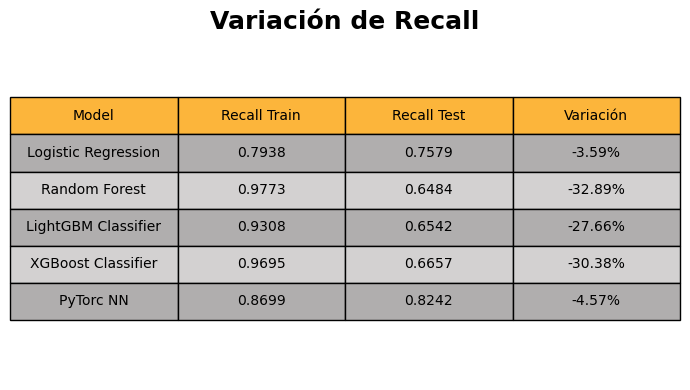

In [326]:
generar_tabla(df_recall_diff,
              title='Variación de Recall',
              save='recall_train_test',
              figsize=(7,4))

### <font color='#FCB53B'>**Variación F1-Score**</font>

In [327]:
df_f1_diff

,Model,F1-score Train,F1-score Test,Variación
0,Logistic Regression,0.7897,0.5434,-24.63%
1,Random Forest,0.9825,0.6608,-32.17%
2,LightGBM Classifier,0.9440,0.6756,-26.84%
3,XGBoost Classifier,0.9771,0.6916,-28.55%
4,PyTorc NN,0.8613,0.6405,-22.08%


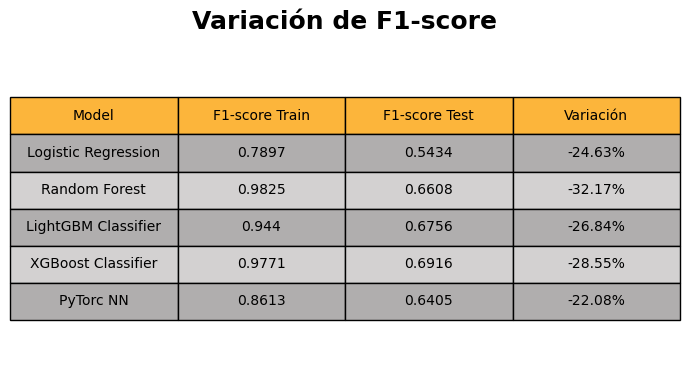

In [328]:
generar_tabla(df_f1_diff,
              title='Variación de F1-score',
              save='f1_train_test',
              figsize=(7,4))

## <font color='#8b1f1f'>**Conclusiones: Subajuste (Underfitting) y Sobreajuste (Overfitting)**</font>

Uno de los desafíos más grandes del presente proyecto fue luchar contra la falta de variabilidad en los datos.

Al no contar con los datos referentes a las transacciones e interacciones con la aplicación de la empresa, estos debieron ser confeccionados, lo cual tiene varias implicaciones.<br>
La variabilidad del comportamiento de cada cliente fue construido siguiendo cierta lógica, sin embargo, captar cada aspecto de la realidad hubiese requerido cierto tiempo adicional, además de que lo más probable es que **nunca se llegue a confeccionar la realidad en su totalidad de forma sintética**.

Por dicha razón, uno de los desafíos de este proyecto fue poder luchar contra un modelo **"perfecto y poco realista"**. Los datos pasaron por diversas etapas y modificaciones, con el objetivo de evitar que los modelos pudieran diferenciar de forma determinística, qué clientes planeaban abandonar la empresa y cuáles no. 

Así, el sobreajuste en los datos de entrenamiento fue un gran desafío. Como es posible ver en la variación de las métricas, particularmente el la métrica **F1-score**, vemos una caida general en un rango entre aproximadamente **-22% y -32%**, mostrando un fuerte sobreajuste.

Indicamos a Velarion que esto puede ser mejorado con un poco más de tiempo para trabajar los datos. Los modelos cumplen el objetivo de identificar correctamente 3 de cada 4 casos de abandono, considerando la intervención de 4 de cada 10 casos que no debieron ser contactados. Ofrecemos usar el prototipo y extendemos el plazo de entrega del modelo definitivo.


## <font color='#c37171'>**Matrices de Confusión**</font>

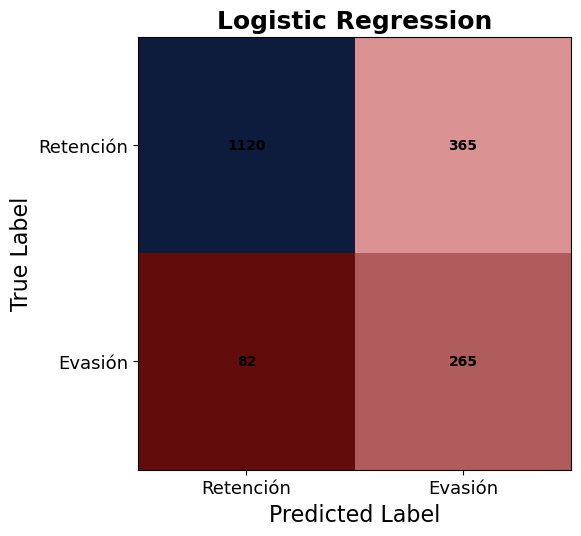

In [329]:
plot_conf_mat(model=lr,
              x=X_test,
              y=y_test,
              name='Logistic Regression',
              save='confmat_lr',
              umbral=0.49)

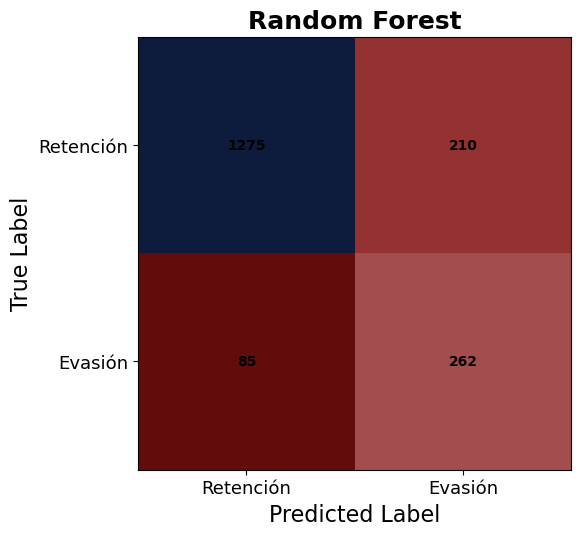

In [330]:
plot_conf_mat(model=rf,
              x=X_test[selected_features],
              y=y_test,
              name='Random Forest',
              save='confmat_rf',
              umbral=0.35)

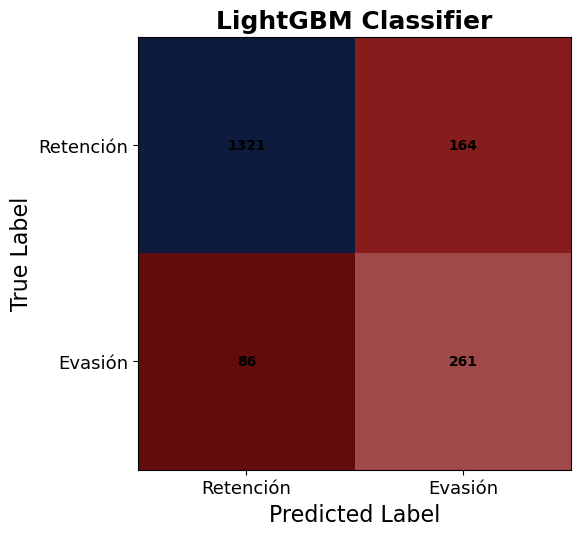

In [331]:
plot_conf_mat(model=lgbm,
              x=X_test,
              y=y_test,
              name='LightGBM Classifier',
              save='confmat_lgbm',
              umbral=0.37)

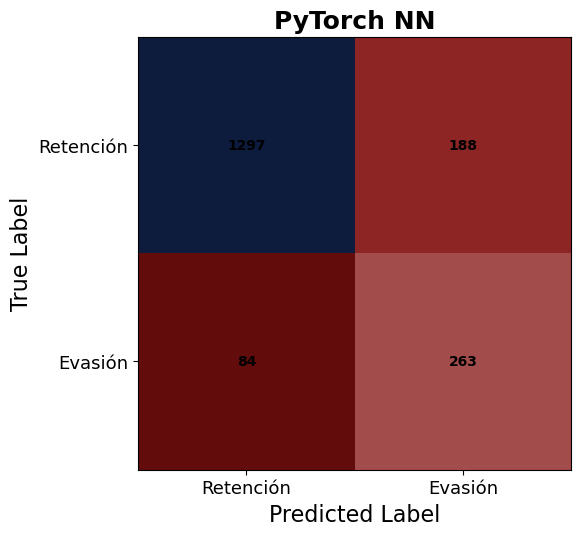

In [332]:
nn.eval()
with torch.inference_mode():
    test_logits = nn(X_test_torch).squeeze()
    y_pred_proba = torch.sigmoid(test_logits)
    y_pred_binary = (y_pred_proba >= 0.6).int()
    
confmat = confusion_matrix(y_true=y_test_torch.cpu().detach().numpy(), y_pred=y_pred_binary.cpu().detach().numpy())

confmat_plot = ConfusionMatrixDisplay(confmat, display_labels=['Retención', 'Evasión'])

fig, ax = plt.subplots(figsize=(10,6))
confmat_plot.plot(ax=ax, cmap=custom_cmap, colorbar=False, text_kw={'color': 'black', 'fontweight': 'bold'})

plt.title('PyTorch NN', fontsize=18, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=16)
plt.ylabel('True Label', fontsize=16)
plt.tick_params(axis='both', labelsize=13)

plt.subplots_adjust(right=0.88)
plt.tight_layout(pad=3.0)

fig.savefig(IMG_PATH / f'confmat_nn.png',
            transparent=True,
            dpi=300,
            bbox_inches=None)
plt.show()

## <font color='#8b1f1f'>**Conclusiones: Matrices de Confusión**</font>

Las **Matrices de Confusión** permiten visualizar de forma gráfica como son las proporciones de aciertos y errores de cada uno de los modelos.

* **CUADRANTE SUPERIOR IZQUIERDO *(VERDADEROS NEGATIVOS):*** Observaciones negativas (`Exited = 0`) clasificadas correctamente como negativas por el modelo.
  
* **CUADRANTE SUPERIOR DERECHO *(FALSOS POSITIVOS):*** Observaciones negativas (`Exited = 0`) clasificadas erroneamente como positivas por el modelo. Es decir, el modelo clasificó -> `Exited = 1` a una observación que realmente tenía `Exited = 0`.

* **CUADRANTE INFERIOR IZQUIERDO *(FALSOS NEGATIVOS):*** Observaciones positivas (`Exited = 1`) clasificadas erroneamente como negativas por el modelo. Es decir, el modelo clasificó -> `Exited = 0` a una observación que realmente tenía `Exited = 1`.

* **CUADRANTE INFERIOR DERECHO *(VERDADEROS POSITIVOS):*** Observaciones positivas (`Exited = 1`) clasificadas correctamente como positivas por el modelo. Esto es lo que buscamos maximizar.



Dado que se modificaron los umbrales de decisión para obtener un ratio de verdaderos positivos de 0.75 (**Recall**), todos los modelos aciertan aproximadamente la misma cantidad de observaciones clasificadas como positivas.<br>
La diferencia se observa en la cantidad de Falsos Positivos en los cuales cada uno incurre, afirmado que `LightGBM Classifier` es el modelo que mejor se desempeña en términos generales.

Por lo tanto se conservará dicho modelo como candidato a entorno productivo.

# <font color='#315aa0'>**Champion Model: LightGBM Classifier**</font>

## <font color='#c37171'>**Importancias**</font>

In [333]:
lgbm.feature_importances_

array([160,  43, 149,  77, 241, 104, 225, 330,  64, 180,  60,  69,  59,
       230,  74,  70,  67,  46, 222, 129, 214,  28,  31,  54])

In [334]:
split_importancias = lgbm.feature_importances_

total_importancias = split_importancias.sum()

importancias_norm = split_importancias / total_importancias


df_importancias = pd.DataFrame({'Feature': X_train.columns, 'Importancia': importancias_norm})
df_importancias.sort_values(by='Importancia', ascending=False, inplace=True)

In [335]:
df_importancias

,Feature,Importancia
7,NumOfProducts,0.112782
4,Age,0.082365
13,days_since_last_tx,0.078606
6,Balance,0.076897
18,days_since_last_ss,0.075871
20,ss_q2q3_rate_of_change,0.073137
9,IsActiveMember,0.061517
0,Geography_Germany,0.054682
2,Gender_Male,0.050923
19,ss_q1q2_rate_of_change,0.044087


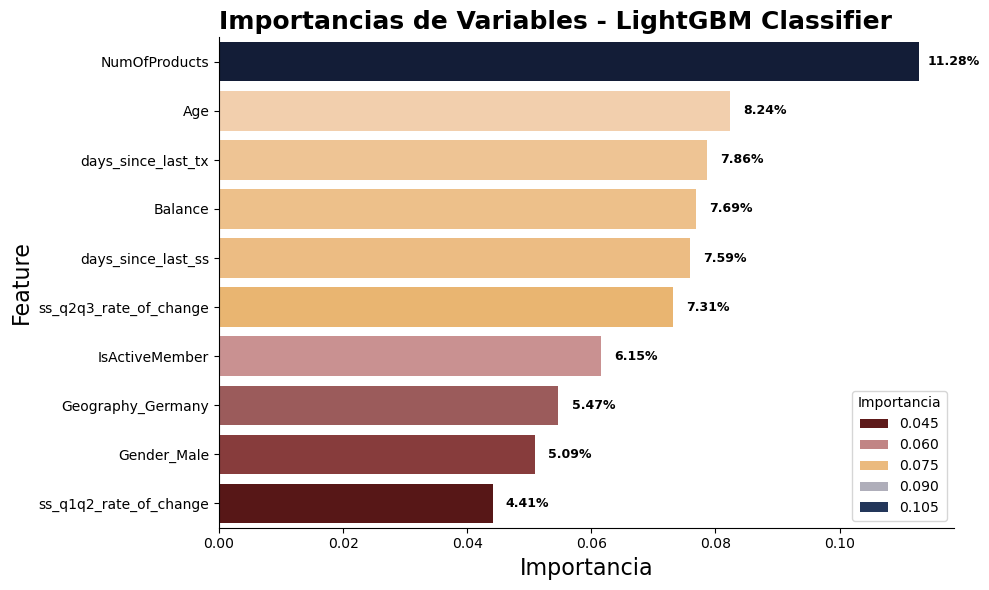

In [336]:
plot_analisis_variables(df=df_importancias,
                        analisis='Importancia',
                        nombre_modelo='LightGBM Classifier',
                        n_vars=10,
                        save='lgbm_importances',
                        save_path=IMG_PATH,
                        space=0.05
                       )
                        

## <font color='#c37171'>**Análisis SHAP**</font>

In [337]:
import shap

In [338]:
explainer = shap.TreeExplainer(lgbm)

In [339]:
import warnings

try:

    with warnings.catch_warnings():
        warnings.filterwarnings(
            'ignore', 
            message='LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray', 
            category=UserWarning
        )
        
        shap_values = explainer.shap_values(X_test)
        print('Cálculo SHAP completado.')
        
    shap_values_churn = shap_values[1] 
    print('Acceso a shap_values[1] exitoso.')
        
except Exception as e:
    print(f'Error durante el cálculo o acceso a SHAP!: {e}')
    import traceback
    traceback.print_exc()

Cálculo SHAP completado.
Acceso a shap_values[1] exitoso.


In [340]:
shap_values_churn

array([-0.12241179, -0.01318811,  0.14513621,  0.00720983, -0.99631586,
        0.13981819,  0.11099297,  0.63040317, -0.01697471,  0.29386301,
       -0.01200353,  0.00895076, -0.02792765, -0.28203302,  0.05746158,
       -0.04038714, -0.05217905, -0.03646454,  0.68033113,  0.1631261 ,
       -0.04367265,  0.00496691, -0.00334157, -0.16159125])

In [341]:
len(shap_values_churn)

24

### <font color='#FCB53B'>**SHAP Summary**</font>

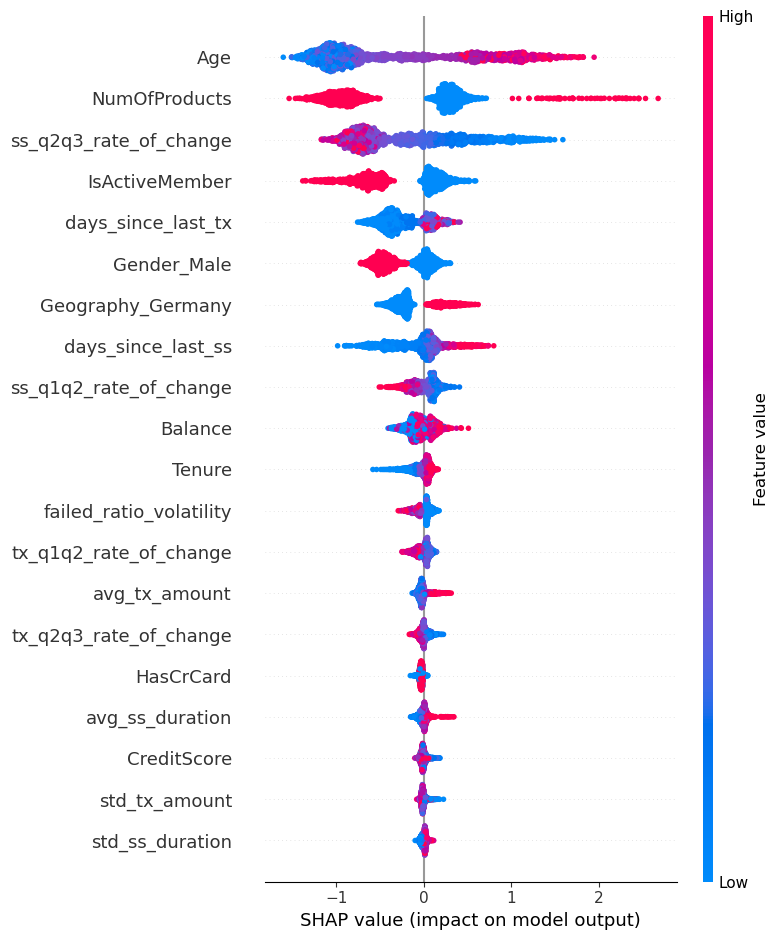

In [342]:
shap.summary_plot(shap_values, X_test, plot_type='dot')
plt.show()

### <font color='#FDD2A9'>**Observaciones: Shap Summary**</font>

A partir del resumen de valores shap, podemos observar la importancia global de cada feature y como los valores de cada variable influyen en las predicciones del modelo. 

Antes de desarrollar el análisis, se consideran los siguientes aspectos del gráfico:

* Valores negativos de SHAP indica que dichas observaciones contribuyen a la retención (o impactan de forma negativa en el abandono). Valores positivos de SHAP contribuyen al abandono (impactan de forma postiva en el Churn).
* Escala de colores:
  - Rojos para valores altos de la variable observada.
  - Azules para valores bajos de la variable observada.
* La concentración de puntos representa la cantidad de observaciones en dicho valor SHAP.

De mayor a menor relevancia

> **`Age`:** Es el mayor predictor individual. Se puede observar que valores elevados en dicha variable conllevan un fuerte SHAP positivo, los cuales contribuyen a la evasión. Esto confirma lo que se visualizó en el script de EDA: existe una gran concentración de clientes que abandonan entre 38 y 51 años. 

> **`NumOfProducts`:** Si bien es posible observar que gran concentración de puntos rojos presentan valores negativos de SHAP, también existe un grupo que contribuyen positivamente al abandono. Esto podría indicar descontento con la integración de servicios, o quizás con algun servicio en particular.

> **`ss_q2q3_rate_of_change`:** Valores altos contribuyen a la retención, mientras que valores bajos están fuertemente asociados al abandono. Una dimsinución en la frecuencia del uso de la aplicación en el último período (este feature evalúa la tasa de cambio entre en segundo y tercer trimestre) es una fuerte señal de abandono.

> **`IsActiveMember`:** Como es de esperarse, que un cliente esté clasificado como "Activo", contribuye a la retención, mientras aquellos que no interactúan con la empresa tienen valores SHAP positivos.

> **`days_since_last_tx`:** Valores altos contribuyen al abandono. Mientras más tiempo lleva un cliente sin realizar transacciones, más probable es que este abandone.

> **`Gender_Male`:** Dado que esta variable es binaria, los puntos rojos representan **Gender_Male = 1**, por lo que, a partir de los valores SHAP de esta variable, podemos confirmar lo que se analizó en el Análisis Exploratorio de Datos (EDA): ser mujer contribuye al abandono. Lo cual podría indicar sesgos o desigualdad en oportunidades, productos u ofertas.

> **`Geography_Germany`:** También siendo una variable binaria, se observa que para valores **Geography_Germany = 1**, el SHAP value es positivo, lo cual refleja que ser alemán aumenta las probabilidades de abandono. Reflejando que existen problemas dentro de este país en particular.

> **`days_since_last_ss`:** Al igual que con **days_since_last_tx**, valores elevados en esta variable tienen un impacto positivo en las probabilidades de abandono, es decir, aumentan. Mientras más tiempo lleva un cliente sin conectarse a la aplicación, más probabilidades hay de que abandone.

> **`ss_q1q2_rate_of_change`:** Mide lo mismo que **ss_q2q3_rate_of_change** pero entre el primer y segundo trimestre. De aquí destaca que, el hecho de que ambas tasas de cambio en la cantidad de sesiones aparezcan entre los 10 mayores predictores, indica que monitorear el cambio en el comportamiento del cliente referente al uso de la aplicación será clave para predecir el abandono e intervenir clientes efectivamente para aplicar estrategias de retención.

> **`Balance`:** Aquí surge un factor contraintuitivo, y posiblemente crítico. Valores elevados en el Balance contribuyen a aumentar las probabilidades de abandono del cliente. Esto refleja el hecho de que la mayoría de clientes que decidieron abandonar, eran clientes de alto valor (factor observado en el script de Análisis Exploratorio de Datos (EDA)). 

In [343]:
shap.summary_plot(shap_values, X_test, plot_type='dot', show=False) 
plt.savefig(IMG_PATH /'shap_summary_plot.png', bbox_inches='tight', dpi=150)
plt.close()

### <font color='#FCB53B'>**Dependence Plot: *Age* - Interacción: *NumOfProducts***</font>

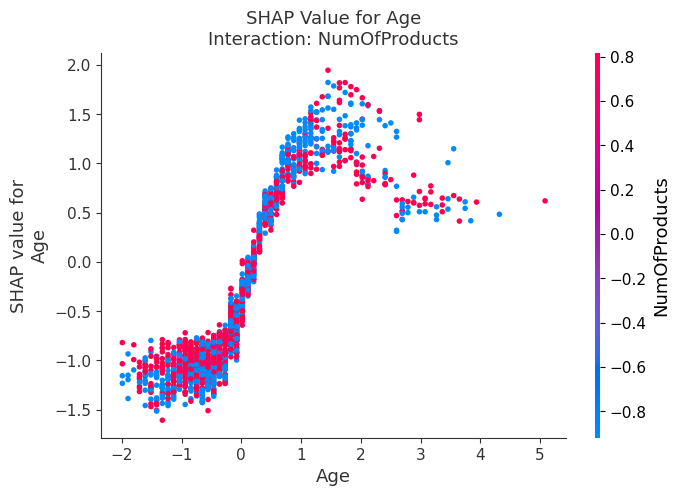

In [344]:
shap.dependence_plot('Age', shap_values, X_test, interaction_index='NumOfProducts',
                     title='SHAP Value for Age\nInteraction: NumOfProducts')
plt.show()

### <font color='#FDD2A9'>**Observaciones: Dependence Plot: *Age* - Interacción: *NumOfProducts***</font>

Cofirmando lo anteriormente mencionado, se produce un aumento pronunciado en la contribución a las probabilidades de abandono en valores de **Age *(normalizada)*** entre 0 y 2.<br>
Para **valores de Age menores a 0 *(jóvenes)*** los valores SHAP se concentran entre -0.5 y -1.5, lo que indica que ser joven actúa como factor de retención.<br>
Sin embargo, para valores entre 0 y 2 el SHAP value aumenta considerablemente, lo que demuestra que clientes de mediana edad son propensos a abandonar.


En cuanto a la relación entre `Age` y `NumOfProducts`, y su impacto en las probabilidades de abandono, podemos ver que al analizar dichos valores de forma vertical, es decir, para un mismo valor de Age: ¿cómo se distribuyen los valores SHAP en relación a la cantidad de productos contratados?.
Se observa que los puntos rojos suelen asociarse a valores SHAP menores, por lo que, un cliente de mediana edad *(Age entre 0 y 2)* que además cuenta con pocos productos, representa un cliente de ALTO riesgo.

In [345]:
shap.dependence_plot('Age', shap_values, X_test, interaction_index='NumOfProducts', 
                     title='SHAP Value for Age\nInteraction: NumOfProducts',                     
                     show=False)
plt.savefig(IMG_PATH/'shap_dependance_age_numofproducts.png', dpi=300)
plt.close()

### <font color='#FCB53B'>**Dependence Plot: *Age* - Interacción: *Balance***</font>

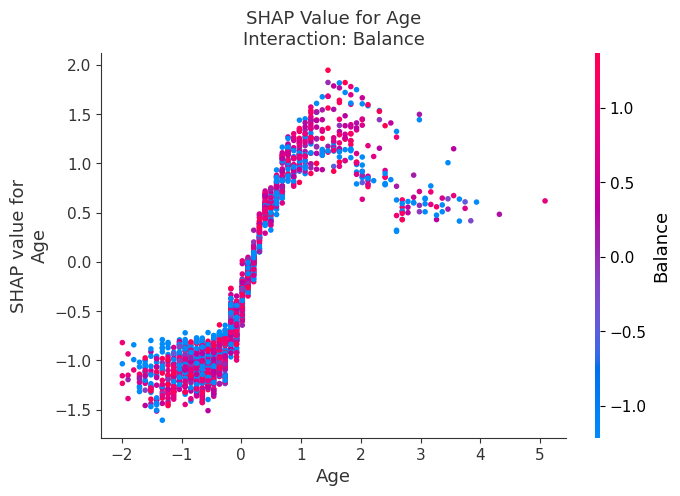

In [346]:
shap.dependence_plot('Age', shap_values, X_test, interaction_index='Balance',
                     title='SHAP Value for Age\nInteraction: Balance')
plt.show()

### <font color='#FDD2A9'>**Observaciones: Dependence Plot: *Age* - Interacción: *Balance***</font>

Este análisis muestra un factor clave para las acciones de negocio. Vemos que, según la edad, los clientes jóvenes tienden con balance alto tienen los valores SHAP más negativos (entre -1.0 y -1.5). Mientras que los clientes de mediana edad con balance alto se posicionan en los SHAP values más elevados.

Dado que Velarion es una FinTech, el sector demográfico de **mediana edad (entre 35 y 50 años)**, es en general, el sector que se encuentra en su **etapa de mayores ingresos, con planificaciones más estructuradas y estratégicas**: jubilación, educación de hijos e hijas, hipotecas, etc. Por lo que, podría decirse que este es un **grupo de alto valor** especialmente para el tipo de negocio, sin embargo, son estos clientes los que son **más propensos a abandonar.**

In [347]:
shap.dependence_plot('Age', shap_values, X_test, interaction_index='Balance', 
                     title='SHAP Value for Age\nInteraction: Balance',
                     show=False,
                    )
plt.savefig(IMG_PATH/'shap_dependance_age_balance.png', dpi=300)
plt.close()

### <font color='#FCB53B'>**Dependence Plot: *ss_q2q3_rate_of_change* - Interacción: *IsActiveMember***</font>

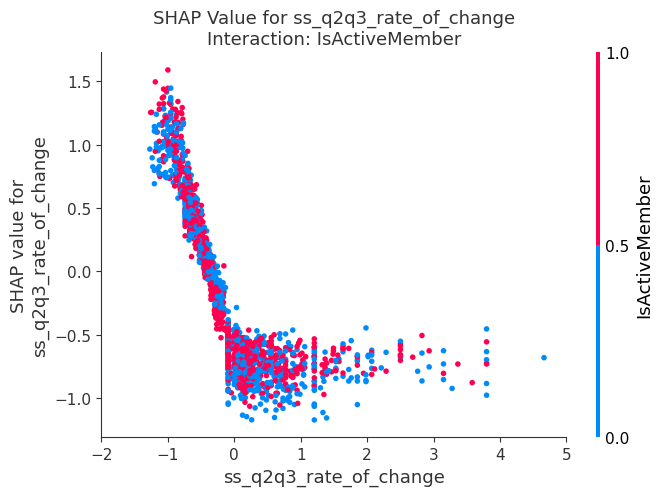

In [348]:
shap.dependence_plot('ss_q2q3_rate_of_change', shap_values, X_test, 
                     interaction_index='IsActiveMember', 
                     xmin=-2, xmax=5,
                     title='SHAP Value for ss_q2q3_rate_of_change\nInteraction: IsActiveMember')
plt.show()

### <font color='#FDD2A9'>**Observaciones: ss_q2q3_rate_of_change - Interacción: IsActiveMember***</font>

Es posible observar que este es un fuerte predictor de evasión. Un valor negativo (en desviación estándar) para este feature, actúa fuertemente como contribuyente a las probabilidades relativas de abandono.
Los **valores críticos** se encuentran **entre -0.5 y -1.5** aproximadamente. Mientras que una leve caida en la interacciones con la aplicacion ya no representan un riesgo significativo.

La mayor concentración de puntos rojos parece ubicarse por debajo de 0 en el eje Y, por lo que, si la tasa de cambio en interacción con la aplicación entre el segundo y tercer trimestre es leve (-0.5 <) y el cliente es un miembro activo (`IsActiveMember = 1`), el modelo se inclinará fuertemente a un clasificar a dicho cliente como baja probabilidad de abandono.

In [349]:
shap.dependence_plot('ss_q2q3_rate_of_change', shap_values, X_test, 
                     interaction_index='IsActiveMember',
                     xmin=-2, xmax=5,
                     title='SHAP Value for ss_q2q3_rate_of_change',
                     show=False)

plt.savefig(IMG_PATH/'shap_dependance_ss_q2q3_rc_activemember.png', dpi=300)
plt.close()

### <font color='#FCB53B'>**Force Plot: No Churner - Index = 0**</font>

In [350]:
# Necesario para mostrar los force plots en Jupyter
shap.initjs() 

# 1. Obten el valor base (predicción promedio para Churn)
base_value = explainer.expected_value

# 2. Elige un cliente para explicar (ej., el primero del set de prueba, índice 0)
cliente_index = 0
features_cliente = X_test.iloc[cliente_index, :]
shap_values_cliente = shap_values[cliente_index, :] 

# Selecciona las features para ESE MISMO cliente (esto ya estaba bien)
features_cliente = X_test.iloc[cliente_index, :]
force_plot_obj = shap.force_plot(
    base_value, 
    shap_values_cliente, 
    features_cliente,
    show=False # Importante: No lo mostramos todavía
)
shap.save_html('shap_force_plot_idx_0.html', force_plot_obj)

In [351]:
display(force_plot_obj)

### <font color='#FCB53B'>**Force Plot: Churner - Index = 158**</font>

In [352]:
# Necesario para mostrar los force plots en Jupyter
shap.initjs() 

# 1. Obten el valor base (predicción promedio para Churn)
base_value = explainer.expected_value

# 2. Elige un cliente para explicar (ej., el primero del set de prueba, índice 0)
cliente_index = 158
features_cliente = X_test.iloc[cliente_index, :]
shap_values_cliente = shap_values[cliente_index, :] 

# Selecciona las features para ESE MISMO cliente (esto ya estaba bien)
features_cliente = X_test.iloc[cliente_index, :]
force_plot_obj = shap.force_plot(
    base_value, 
    shap_values_cliente, 
    features_cliente,
    show=False # Importante: No lo mostramos todavía
)
shap.save_html('shap_force_plot_idx_158.html', force_plot_obj)

In [353]:
display(force_plot_obj)

### <font color='#FDD2A9'>**Observaciones: Force Plot**</font>

| Customer Index (X_test) | Predicted Exited | f(x)   | Age    | ss_q2q3_rate_of_change | days_since_last  | IsActiveMember |
|-------------------------|------------------|--------|--------|------------------------|------------------|----------------|
| 0                       | 0                | -2.68  | -0.65  | 0.55                   | tx = -0.39       | 1              | 
| 158                     | 1                |  1.79  | 0.30   | -0.9571                | ss = 3.127       | 0              |


Al comparar estos dos clientes individuales, podemos observar algunos factores interesantes:

* **Cliente 0: No Churner**
* **Cliente 158: Churner**

> El cliente 0 (Index = 0 en X_test) esta 0.65 desviaciones estándar por debajo de la media, es decir, es bastante joven, por lo que para este caso, Age actúa como un fuerte protector contra el abandono, mientras que en el cliente 158 (Index = 158 en X_test) tiene una edad 0.30 desviaciones estándar por encima de la media, siendo este el tercer factor más contribuyente a la probabilidad de abandono.

> El cliente 0 tuvo un aumento en el tercer trimestre en sus interacciones con la aplicacion en relación al segundo trimestre, es decir, su *engagement* aumentó, lo cual actúa como protector de evasión. Mientras que la tasa de cambio del cliente 158, con un valor negativo de -0.95 desviaciones estándar debajo de la media, muestra una disminución del uso de la aplicación, lo cual aumenta considerablemente el riesgo (mayor factor de riesgo para este cliente).

> Aun evaluando transacciones e inicios de sesión en la aplicación (manzanas y peras), ambos son factores que miden qué tan activo es un cliente. Por lo tanto, el cliente 0, tiene un valor negativo para days_since_last_tx, es decir, los días que han pasado desde su última transacción están 0.39 desviaciones estándar por debajo de la media, lo cual implica que ha operado recientemente. Mientras que el cliente 158, el cual el modelo predice que abandonará, tiene days_since_last_ss, días que han pasado desde la última sesión, 3.12 desviaciones estándar por encima de la media, lo cual significa un gran riesgo de abandono ya que es un cliente que lleva demasiado tiempo sin entrar a la aplicación en comparación al resto.

> IsActiveMember actua como el segundo mayor reductor de la probabilidad relativa de abandono para el cliente 0, mientras que, para el cliente 158, el hecho de no ser un miembro activo (`IsActiveMember = 0`) actúa como contribuyente a las probabilidades relativas de abandono.

## <font color='#8b1f1f'>**Conclusiones: Importancias y Análisis SHAP**</font>

A partir del análisis SHAP se logró identificar no solo el peso de cada variable y su contribución a la probabilidad relativa de abandono. Sino también descubrir ciertos umbrales que permitan monitorear y entender que valores son críticos para anticipar el abandono.


> `Age`: Mayor predictor. La contribución a las probabilidades relativas de abandono aumentan drásticamente cuando la edad del cliente se encuentra por encima de la media.

> `NumOfProducts`: Si bien valores elevados para este feautre parece actuar como protector contra el abandono, también se observa que valores altos pero no máximos contribuyen al abandono, esto podría indicar insatisfacción con algún producto en particular.

> `ss_q2q3_rate_of_change`: Fuerte predictor de Churn. Si este ratio tiene un valor negativo (estandarizado) entre -1.5 y -0.5, las probabilidades relativas de abandono aumentan considerablemente -> **-0.5 UMBRAL CRÍTICO DE MONITOREO**

> `IsActiveMember`: Gran protector contra el abandono, será esencial generar estrategias que mantengan al cliente en un estado activo.

> `days_since_last_tx`: Factor de alto riesgo, a medida que pasan los días sin que el cliente realize transacciones, más aumentan las probabilidades relativas de abandono.

> `Gender_Male`: El hecho de ser mujer (`Gender_Male = 0`) actúa como potenciador en las probabilidades relativas de Churn. Este es un punto crítico a investigar dado que puede haber sesgos de género en productos, ofertas y/o condiciones -> **IMPORTANTE REVISAR POLÍTICAS DE EMPRESA**.

> `Geography_Germany`: Ser alemán aumenta las probabilidades relativas de abandono. Será necesario investigar las razones por las cuales los clientes de este país son más propensos a abandonar la empresa.

> `days_since_last_ss`: Al igual que días desde la última transacción, mientras más días pasa un cliente sin conectarse a la aplicación de la empresa, más aumenta el riesgo de abandono.

> `Balance`: CRÍTICO -> Tener un alto balance contribuye a las probabilidades relativas de abandono, esto refleja que los clientes que deciden dejar la empresa son de alto valor. Resulta de suma importancia investigar este fenómeno en profundidad.

In [354]:
try:
    with open(CHAMPION_PATH / 'champion_model.pkl', 'wb') as f:
        pickle.dump(lgbm, f)
except Exception as e:
    print(e)
    print('No se pudo guardar Champion Model: LightGBM')

In [355]:
try:
    with open(CHAMPION_PATH / 'one_hot_encoder.pkl', 'wb') as f:
        pickle.dump(one_hot, f)
except Exception as e:
    print(e)
    print('No se pudo guardar OneHotEncoder')